# Notebook 2:  Laser evolution


LWFA Workbook II

This is the second notebook on LWFA where we explore the evolution of the laser using 1D moving window simulations to understand the effects of pump depletion and dephasing.



OSIRIS simulations are done in normalized units. 

* Time:  $t' = t \omega_{p}$

* Frequency: $\omega' = \frac{\omega}{\omega_{p}}$ 

* Position: $\vec{x}' = \frac{\omega_{p}}{c} \vec{x}$  

* Momenta: $\vec{u}' = \frac{\vec{p}}{m_{e} c} = \frac{\vec{\gamma v}}{c} = \frac{\vec{u}} {c}$  

* Electric field: $\vec{E}' = e \frac{c / \omega_{p}}{m_{e} c^2} \vec{E}$  

* Magnetic field: $\vec{B}' = e \frac{c / \omega_{p}}{m_{e} c^2} \vec{B}$  


In [1]:
# **********************************
# First Run This Cell to 
# import the necessary libraries
# **********************************
#
# Please run this cell before running anything, and run this cell again if you have restarted the 
# python kernel.
#
# This cell imports useful routines to diagnose the simulations here
#

# %matplotlib notebook
import osiris
from osiris import tajima
from tajima_helper import plot_maxgamma_t, newifile, newifile2, laser_envelope, tajima_widget2, tajima_moving_widget, xt_and_energy_plot,xt_and_energy_plot2,k_plot2
from tajima_helper import ml_deckmaker
import numpy as np
import matplotlib.pyplot as plt
from osh5vis import osplot
from osh5io import read_h5
from osh5utils import fft
import osh5utils
import osh5io
import osh5def


from ipywidgets import interact_manual,Layout,interact, FloatSlider
import ipywidgets as widgets

interact_calc=interact_manual.options(manual_name="Make New Input and Run")

%load_ext autoreload
%autoreload 2

/usr/local/oshun/osh5def.py:417: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if axes is () or axes[0] is None:  # axes is none, numpy default is to reverse the order


## Here we illustrate and explore the OSIRIS pulse shape:

In these 1D simulations the laser envelope has a shape in time.  This shape is often approximated by a Gaussian with a width $\sigma_t$.  However, in a simulation the laser envelope cannot be a Gaussian because it will lead to infinitely long pulses in time.  To make the laser shape finite OSIRIS uses a polynomial function 

In [2]:
# This cell shows the laser envelope shape for given t_rise, t_fall, and Lt.  
#
interact(laser_envelope, trise=FloatSlider(min=0.00, max=5, step=.05, description='$t_{rise}$', value = 1.57),
         tflat=FloatSlider(min=0.00, max=5, step=.05, description='$Lt$', value = 0),
         tfall=FloatSlider(min=0.00, max=5, step=.05, description='$t_{fall}$', value = 1.57));

interactive(children=(FloatSlider(value=1.57, description='$t_{rise}$', max=5.0, step=0.05), FloatSlider(value…

## Wakefield exitation

$$ \Psi = \int_{-\infty} ^ {\infty} d\xi^\prime \frac{a_0^2 (\xi^\prime)}{4} \sin{k_p}(\xi - \xi^\prime) $$

# Laser Evolution in Propagation:

There are many different effects which can cause a laser to evolve in time or space. Here we will look at a couple different ways the laser can evolve in a 1D wake, namely dephasing and pump depletion from a couple points of view.

## Dephasing

First we look at the light dispersion in a plasma, and look at the effects of dephasing, where the energetic electrons outrun the laser and the plasma waves.  

In an unmagnetized plasma, the dispersion for light wave is:

$\omega^2 = \omega_p^2 + k^2 c^2$

and a laser packet moves at the group velocity which can be derived from the above relation:

$v_g = \frac{c^2} {v_{\phi}}$

and the wake, which is created by the ponderomotive pressure of the laser (i.e., the laser packet/envelope) also moves at $v_g$.  

Laser dephasing describes the process where the energetic electrons outrun the laser.  This is an important consideration in the design of plasma based LWFA's as it is important to take the electrons out of the accelerating structure as soon as it has reached the highest possible energy.  The length of the plasma in LWFA's is typically on the order of the dephasing length, which is the distance for energetic electrons (moving at the speed of light) to outrun the laser packet and the accelerating structure.  

$L = c \frac{\lambda_p/4 }{c - v_g}$

where we assumed the electrons are injected at the point of highest gradient and it outruns the wake after it has traveled $\lambda/4$ in the wake frame and reaches the decelerating part of the plasma wake.

## Pump Depletion

Another aspect of laser evolution in a wake is pump depletion. In order for a laser to excite a wake in a plasma, energy must be transferred from the laser to the wake. This introduces a physical limit on the total amount of energy in the wake, which in turn limits the ability of a LWFA to accelerate particles. This begs the question - how quickly does our pump laser lose energy? This is the same as asking over what distance our accelerator accelerates particles. 

We will look at the issue of laser pump depletion length from two points of view. First, we will look at global energy conservation, where all of the energy contained in the laser pulse is transferred to the wake. Next, we will use the local acceleration/deceleration of photons, equivalent to the local conservation of photon number, to arrive at the same conclusion.  

### Global Conservation of Energy

The energy of the laser field is 
\begin{equation}
     w_{L}^{2}c\tau_{L}\frac{E_{L}^{2}}{8\pi},
\end{equation}
where $w_{L}$ and $\tau_{L}$ are the spot size and pulse length of the laser, respectively, and $E_{L}$ is the average electric field of the laser. Meanwhile, the wake will have a similar expression for its energy:
\begin{equation}
    w_{w}^{2}L_{pd}\frac{E_{w}^{2}}{8\pi},
\end{equation}
where instead of $c\tau_{L}$ for the longitudinal extent of the laser, we have used $L_{pd}$, the pump depletion length. Setting these energies equal to each other (100\% pump depletion - does this make physical sense?), an expression for the pump depletion length is found:
\begin{equation}
    L_{pd} = \frac{w_{L}^{2}}{w_{w}^{2}}\frac{E_{L}^{2}}{E_{w}^{2}}c\tau_{L}.
\end{equation}

With the usual normalizations $a = eE_{L}/mc\omega_{0}$ and $\epsilon = eE_{w}/mc\omega_{p}$, and rewriting in terms of the ponderomotive potential $\phi_{p} = a^{2}/4$, the pump depletion length becomes
\begin{equation}
    L_{pd} = \frac{w_{L}^{2}}{w_{w}^{2}}\frac{4\phi_{p}}{\epsilon^{2}}\frac{\omega_o^2}{\omega_p^2}\frac{c}{\omega_{p}}\tau_{L}\omega_{p}.
\end{equation}
Taking the reasonable assumptions that $\tau_{L}\omega_{p} \approx 1$ and $\frac{w_{L}^{2}}{w_{w}^{2}} \approx 2$, our final pump depletion length is given by 
\begin{equation}\label{eq:length1}
    L_{pd} = \frac{8}{\epsilon} \frac{\omega_o^2}{\omega_p^2} \frac{c}{\omega_p}.
\end{equation}
When laser and wake dephasing occurs over a length longer than pump depletion, $L_{pd}$ will be the acceleration length and the particles being accelerated (e.g. electrons) will gain energy $eE_{w}L_{pd}$.

### Photon Acceleration

Now let's derive the same answer from a different perspective. If we assume that the total photon number, or action, is conserved, we can look at how long it takes to fully deplete the energy of each drive photon. To proceed, we need to know how $v_\phi$ of the laser evolves with the wake via the refractive index $\eta$:

\begin{equation}
    \eta = \sqrt{1-\frac{\omega_p^2}{\omega_0^2}\frac{1}{1+\Phi}} = \frac{c}{v_\phi}
\end{equation}
\begin{equation}
    \Phi = -\frac{\delta n}{n_0} + \frac{a_0^2}{2}
\end{equation}
\begin{equation}\label{eq:vphase}
    \frac{v_\phi}{c} \approx 1 + \frac{\omega_p^2}{2\omega_0^2}(1-\Phi)
\end{equation}
Next we'll look at two phase fronts of the laser that are separated by $\lambda$.
\begin{equation}\label{eq:deltav}
    \Delta v_\phi = v_{\phi 2}-v_{\phi 1} = \lambda \frac{\partial v_\phi}{\partial s} = -\lambda \frac{\partial v_\phi}{\partial\xi}
\end{equation}
As these phase fronts propagate over a distance $\Delta$s, their spacing will change.
\begin{equation}
    \Delta\lambda = \Delta v_\phi \left(\frac{\Delta s}{c}\right)
\end{equation}
Plug in our equation for $\Delta v_{\phi}$ and divide by $\lambda$,
\begin{equation*}
    -\frac{\Delta \lambda}{\lambda} = \frac{\partial v_\phi}{\partial\xi} \left(\frac{\Delta s}{c}\right) = \frac{\Delta\omega}{\omega}
\end{equation*}
Let's assume that the photon deceleration is limited by the laser frequency, i.e., the photons lose all of their energy: $\Delta\omega = -\omega_0$. Is this a reasonable assumption to make?
\begin{equation*}
    \frac{\Delta\omega}{\omega_o} = -1 = -\frac{\partial v_\phi}{\partial\xi} \left(\frac{\Delta s}{c}\right)
\end{equation*}
Using the derivative of our equation for $v_{\phi}/c$,
\begin{equation*}
    \left(\frac{\Delta s}{c}\right) \frac{\partial v_\phi}{\partial\xi} = \frac{1}{2} \frac{\omega_p^2}{\omega_0^2} \frac{\partial\Phi}{\partial\xi}\Delta s = 1
\end{equation*}
Now set our propagation length $\Delta s$ equal to the pump depletion length $L_{pd}$,
\begin{equation*}
    \frac{1}{2} \frac{\omega_p^2}{\omega_0^2}\frac{\partial\Phi}{\partial\xi} L_{pd} = 1
\end{equation*}
\begin{equation}\label{eq:length2}
    L_{pd} = \frac{2}{\epsilon} \frac{\omega_o^2}{\omega_p^2} \frac{c}{\omega_p}
\end{equation}
In reality, $v_g$ of the laser will come to rest before all of their energy is transferred to the wake. When will this happen?

In the following sections, we will run simulations with different laser parameters that clearly show each of these effects. After the examples, there will be a chance to fiddle with the simulation parameters to see how they affect the results.

## Case 1:  Linear ($v_{osc}/c=0.3$, $\omega_0/\omega_p = 10$)

In [3]:
## Hit <shift>+<return> to run

dirname = 'linear-a03-w10'
inputfile = dirname + '.txt'
osiris.runosiris(rundir=dirname,inputfile=inputfile)
plot_maxgamma_t(dirname)    

runosiris completed normally
max gamma =  1.0071742649611337


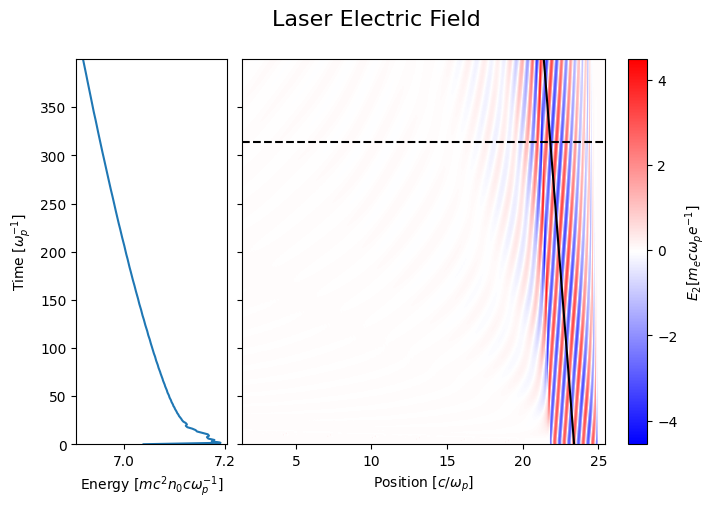

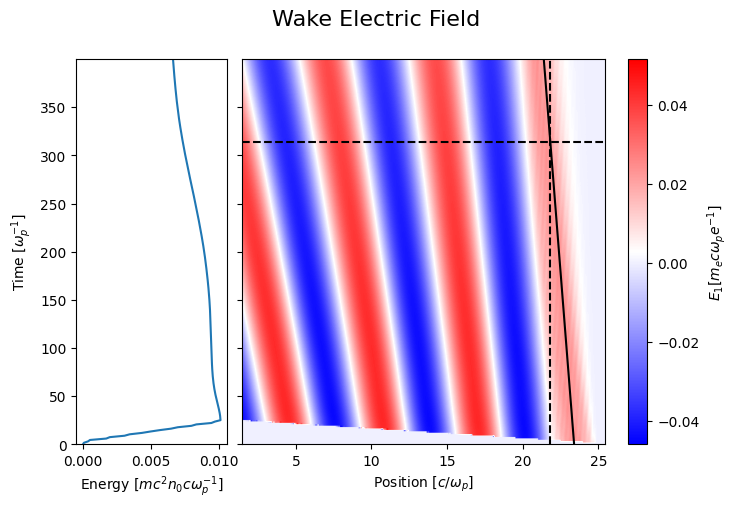

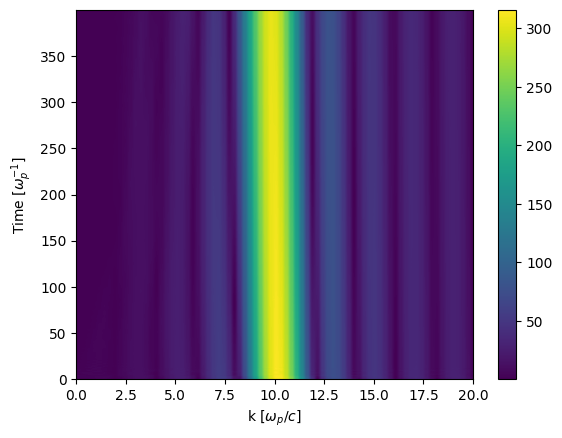

In [4]:
dirname = './linear-a03-w10'
xt_and_energy_plot2(rundir=dirname, field = 'e2')
xt_and_energy_plot2(rundir=dirname, field = 'e1')
k_plot2(rundir = dirname)

/home/jovyan/dev/data-exploration
./linear-a03-w10/MS/FLD/e3/


<Figure size 500x500 with 0 Axes>

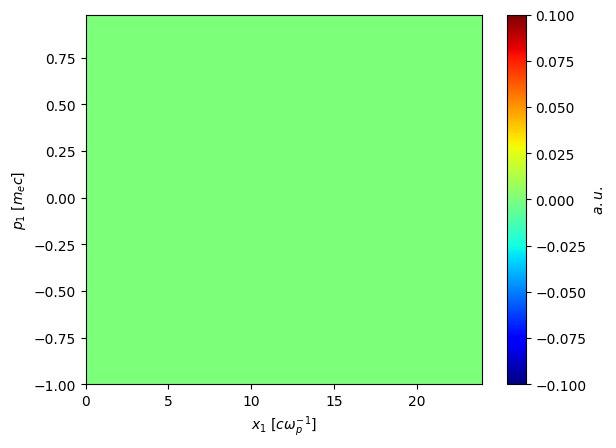

In [5]:
# 
# STEP 1:  Take a look at the electron phase space (using the PyVisOS package)
#


# %matplotlib notebook
import osh5def
import osh5io
import ipywidgets
import osh5visipy
import osh5vis
import os
plt.figure(figsize=(5,5))
print(os.getcwd())
print(dirname+'/MS/FLD/e3/')
osh5visipy.slicer_w(dirname+'/MS/PHA/p1x1/electrons')

In [4]:
# 
# STEP 2:  Construct something slightly more sophiscated
#

import analysis
import scipy

#
#
# Here are some basic functions to generate filenames for Grid, Phase Space, and Particle data, respectively
#
#

def file_name_field(path,field,file_no):
    filename=path+'/FLD/'+field+'/'+field+'-'+repr(file_no).zfill(6)+'.h5'
    # print(filename)
    return(filename)
    
 
def file_name_phase(path,field,species,file_no):
    filename=path+'/PHA/'+field+'/'+species+'/'+field+'-'+species+'-'+repr(file_no).zfill(6)+'.h5'
    # print(filename)
    return(filename)

def file_name_density(path,field,species,file_no):
    filename=path+'/DENSITY/'+species+'/'+field+'/'+field+'-'+species+'-'+repr(file_no).zfill(6)+'.h5'
    # print(filename)
    return(filename)




def laser_basic(rundir,file_no,show=False,*args,**kwpassthrough):
    #
    #
        plasma_field_name = 'e1'
        laser_field_name = 'e3'
    #
    #

        
        e1=file_name_field(rundir,'e1',file_no)
        e2=file_name_field(rundir,'e2',file_no)
      
        # b1_data=osh5io.read_h5(b1)
        # b2_data=osh5io.read_h5(b2)
        # b3_data=osh5io.read_h5(b3)
        
        e1_data=osh5io.read_h5(e1)
        e2_data=osh5io.read_h5(e2)
        
        
        # bsq=b1
        # bsq=(b1_data*b1_data+b2_data*b2_data+b3_data*b3_data)


        # electron_rho = osh5io.read_h5(electron_density)
        
        # ion_p1x1 = osh5io.read_h5(ion_phase)
        # ion_p1p2 = osh5io.read_h5(ion_dist)
        # ion_phase_perp = osh5io.read_h5(ion_p2x1)
        
        # rho_i = osh5io.read_h5(ion_density)
        # rho_i_0 = osh5io.read_h5(ion_density_init)
   
        
      

        fig = plt.figure(figsize=(8,4) )
    
        # electron_phase_plot = plt.subplot(223)
        # electron_p1x1=np.abs(electron_p1x1)
        # data_max=electron_p1x1.max()
        # osh5vis.osplot(electron_p1x1, title='Electron Phase Space (x1,p1)', *args,**kwpassthrough,
        #                norm=matplotlib.colors.LogNorm(vmax=data_max,vmin=data_max/10000))
        # electron_rho=np.abs(electron_rho)
        
        # osh5vis.osplot(np.abs(electron_rho),title='Electron Density (x1,x2)',ylim=[10.9,20.9],cmap='terrain')
        # plt.axhline(y=15.901939,color='r')
        # osh5vis.osplot(np.abs(electron_rho[0,:]),title='Electron Density (x1,x2)',*args,**kwpassthrough,ylim=[-1,0.2])

     
        
        
        
        plt.title('Time = '+str(e1_data.run_attrs['TIME'][0])  )
        plt.subplot(121)
        plt.plot(e2_data.axes[0],e2_data)    
            

        plt.subplot(122)
        # print(e1_data)
        plt.plot(e1_data.axes[0],e1_data)
        if(show == True):
            plt.tight_layout()
            plt.show()
        else:
            print('saving file')
            fig.savefig(rundir+'/movie-1-'+repr(file_no).zfill(6)+'.png')
            plt.close(fig)
#


def laser_basic_2(rundir,file_no,show=False,*args,**kwpassthrough):
    #
    #
        plasma_field_name = 'e1'
        laser_field_name = 'e3'
    #
    #
        species_1_name = 'electrons'


        electron_phase = file_name_phase(rundir,'p1x1',species_1_name,file_no)
        electron_dist = file_name_phase(rundir,'p1p2',species_1_name,file_no)
        
        
        # ion_phase = file_name_phase(rundir,'p1x1',species_2_name,file_no)
        # ion_dist = file_name_phase(rundir,'p1p2',species_2_name,file_no)
        # ion_p2x1 = file_name_phase(rundir,'p2x1',species_2_name,file_no)
        
        
        # ion_density = file_name_density(rundir,'charge',species_2_name,file_no)
        electron_density = file_name_density(rundir,'charge',species_1_name,file_no)
        # ion_density_init = file_name_density(rundir,'charge',species_2_name,0)
        
        
        # b1=file_name_field(rundir,'b1',file_no)
        # b2=file_name_field(rundir,'b2',file_no)
        # b3=file_name_field(rundir,'b3',file_no)
        
        e1=file_name_field(rundir,'e1',file_no)
        e2=file_name_field(rundir,'e2',file_no)
        e3=file_name_field(rundir,'e3',file_no)
        
        # b1_data=osh5io.read_h5(b1)
        # b2_data=osh5io.read_h5(b2)
        # b3_data=osh5io.read_h5(b3)
        
        e1_data=osh5io.read_h5(e1)
        e2_data=osh5io.read_h5(e2)
        e3_data=osh5io.read_h5(e3)
        
        ele_phase = osh5io.read_h5(electron_phase)
        
        
        # bsq=b1
        # bsq=(b1_data*b1_data+b2_data*b2_data+b3_data*b3_data)


        # electron_rho = osh5io.read_h5(electron_density)
        
        # ion_p1x1 = osh5io.read_h5(ion_phase)
        # ion_p1p2 = osh5io.read_h5(ion_dist)
        # ion_phase_perp = osh5io.read_h5(ion_p2x1)
        
        # rho_i = osh5io.read_h5(ion_density)
        # rho_i_0 = osh5io.read_h5(ion_density_init)
   
        
      

        fig = plt.figure(figsize=(8,8) )
    
        # electron_phase_plot = plt.subplot(223)
        # electron_p1x1=np.abs(electron_p1x1)
        # data_max=electron_p1x1.max()
        # osh5vis.osplot(electron_p1x1, title='Electron Phase Space (x1,p1)', *args,**kwpassthrough,
        #                norm=matplotlib.colors.LogNorm(vmax=data_max,vmin=data_max/10000))
        # electron_rho=np.abs(electron_rho)
        
        # osh5vis.osplot(np.abs(electron_rho),title='Electron Density (x1,x2)',ylim=[10.9,20.9],cmap='terrain')
        # plt.axhline(y=15.901939,color='r')
        # osh5vis.osplot(np.abs(electron_rho[0,:]),title='Electron Density (x1,x2)',*args,**kwpassthrough,ylim=[-1,0.2])

     
        plt.subplot(221)
        plt.title('Laser (Raw), Time = '+str(e1_data.run_attrs['TIME'][0])  )
        # e2_data = np.abs(osh5utils.hilbert(e2_data))
        plt.plot(e2_data.axes[0],e2_data.data)
        
        plt.subplot(223)
        plt.title('Laser FFT, Time = '+str(e1_data.run_attrs['TIME'][0])  )
        e2_data = np.abs(osh5utils.fft(e2_data))
        # e2_data = np.abs(osh5utils.hilbert(e2_data))
        plt.plot(e2_data.axes[0],e2_data.data) 
        plt.xlim(0,20)
            

        plt.subplot(222)
        # print(e1_data)
        plt.title('Wake, Time = '+str(e1_data.run_attrs['TIME'][0])  )
        plt.plot(e1_data.axes[0],e1_data)
        
        plt.subplot(224)
        osh5vis.osplot(ele_phase)

       
        if(show == True):
            plt.tight_layout()
            plt.show()
        else:
            print('saving file')
            fig.savefig(rundir+'/movie-2-'+repr(file_no).zfill(6)+'.png')
            plt.close(fig)
#




def laser_basic_3(rundir,file_no,show=False,*args,**kwpassthrough):
    #
    #
        plasma_field_name = 'e1'
        laser_field_name = 'e3'
    #
    #
        species_1_name = 'electrons'


        electron_phase = file_name_phase(rundir,'p1x1',species_1_name,file_no)
        electron_dist = file_name_phase(rundir,'p1p2',species_1_name,file_no)
        
        
        # ion_phase = file_name_phase(rundir,'p1x1',species_2_name,file_no)
        # ion_dist = file_name_phase(rundir,'p1p2',species_2_name,file_no)
        # ion_p2x1 = file_name_phase(rundir,'p2x1',species_2_name,file_no)
        
        
        # ion_density = file_name_density(rundir,'charge',species_2_name,file_no)
        electron_density = file_name_density(rundir,'charge',species_1_name,file_no)
        # ion_density_init = file_name_density(rundir,'charge',species_2_name,0)
        
        
        # b1=file_name_field(rundir,'b1',file_no)
        # b2=file_name_field(rundir,'b2',file_no)
        # b3=file_name_field(rundir,'b3',file_no)
        
        e1=file_name_field(rundir,'e1',file_no)
        e2=file_name_field(rundir,'e2',file_no)
        e3=file_name_field(rundir,'e3',file_no)
        
        # b1_data=osh5io.read_h5(b1)
        # b2_data=osh5io.read_h5(b2)
        # b3_data=osh5io.read_h5(b3)
        
        e1_data=osh5io.read_h5(e1)
        e2_data=osh5io.read_h5(e2)
        e3_data=osh5io.read_h5(e3)
        
        ele_phase = osh5io.read_h5(electron_phase)
        
        
        # bsq=b1
        # bsq=(b1_data*b1_data+b2_data*b2_data+b3_data*b3_data)


        # electron_rho = osh5io.read_h5(electron_density)
        
        # ion_p1x1 = osh5io.read_h5(ion_phase)
        # ion_p1p2 = osh5io.read_h5(ion_dist)
        # ion_phase_perp = osh5io.read_h5(ion_p2x1)
        
        # rho_i = osh5io.read_h5(ion_density)
        # rho_i_0 = osh5io.read_h5(ion_density_init)
   
        
      

        fig = plt.figure(figsize=(8,8) )
    
        # electron_phase_plot = plt.subplot(223)
        # electron_p1x1=np.abs(electron_p1x1)
        # data_max=electron_p1x1.max()
        # osh5vis.osplot(electron_p1x1, title='Electron Phase Space (x1,p1)', *args,**kwpassthrough,
        #                norm=matplotlib.colors.LogNorm(vmax=data_max,vmin=data_max/10000))
        # electron_rho=np.abs(electron_rho)
        
        # osh5vis.osplot(np.abs(electron_rho),title='Electron Density (x1,x2)',ylim=[10.9,20.9],cmap='terrain')
        # plt.axhline(y=15.901939,color='r')
        # osh5vis.osplot(np.abs(electron_rho[0,:]),title='Electron Density (x1,x2)',*args,**kwpassthrough,ylim=[-1,0.2])

     
        plt.subplot(221)
        plt.title('Laser (Raw), Time = '+str(e1_data.run_attrs['TIME'][0])  )
        # e2_data = np.abs(osh5utils.hilbert(e2_data))
        plt.plot(e2_data.axes[0],e2_data.data)
        
        plt.subplot(223)
        plt.title('Laser Envelope, Time = '+str(e1_data.run_attrs['TIME'][0])  )
        # e2_data = np.abs(osh5utils.fft(e2_data))
        e2_data = np.abs(osh5utils.hilbert(e2_data))
        plt.plot(e2_data.axes[0],e2_data.data) 
        # plt.xlim(0,20)
            

        plt.subplot(222)
        # print(e1_data)
        plt.title('Wake, Time = '+str(e1_data.run_attrs['TIME'][0])  )
        plt.plot(e1_data.axes[0],e1_data)
        
        plt.subplot(224)
        osh5vis.osplot(ele_phase)

       
        if(show == True):
            plt.tight_layout()
            plt.show()
        else:
            print('saving file')
            fig.savefig(rundir+'/movie-3-'+repr(file_no).zfill(6)+'.png')
            plt.close(fig)
#


#
# Here we enhance the plotting routine by adding Hilbert Transform
# to look at the laser envelope only
#



NameError: name 'osh5vis' is not defined

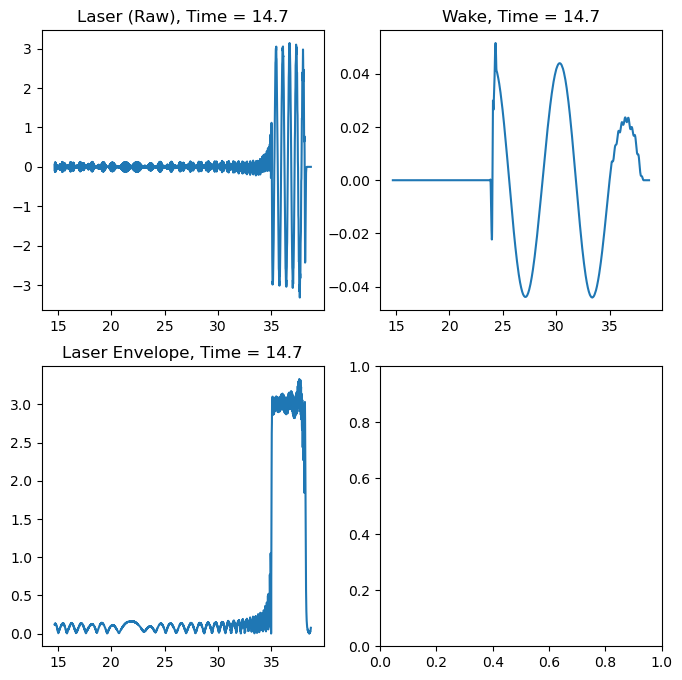

In [5]:
dirname = './linear-a03-w10'

# laser_basic(dirname+'/MS/',0,show=True)
# laser_basic_2(dirname+'/MS/',0,show=True)
laser_basic_3(dirname+'/MS/',500,show=True)

In [6]:
# Here we build upon the basic script to make a GUI
#
#
def laser_slider(rundir,*args,**kwpassthrough):
    
    import os
    my_path=os.getcwd()
    working_dir = my_path+'/'+rundir
    wake_dir=rundir+'/FLD/e1/'
    files=sorted(os.listdir(wake_dir))
    # DEBUG
    # print(files[1])
    # DEBUG
    start=files[1].find('e1-')+3
    end=files[1].find('.')
    file_interval=int(files[1][start:end])
    file_max=(len(files)-1)*file_interval
    
    interact(laser_basic,rundir=(rundir),file_no=widgets.IntSlider(min=0,max=file_max,step=file_interval,value=0),show=True)
  


def laser_slider_2(rundir,*args,**kwpassthrough):
    
    import os
    my_path=os.getcwd()
    working_dir = my_path+'/'+rundir
    wake_dir=rundir+'/FLD/e1/'
    files=sorted(os.listdir(wake_dir))
    # DEBUG
    # print(files[1])
    # DEBUG
    start=files[1].find('e1-')+3
    end=files[1].find('.')
    file_interval=int(files[1][start:end])
    file_max=(len(files)-1)*file_interval
    
    interact(laser_basic_2,rundir=(rundir),file_no=widgets.IntSlider(min=0,max=file_max,step=file_interval,value=0),show=True)

    
    
def laser_slider_3(rundir,*args,**kwpassthrough):
    
    import os
    my_path=os.getcwd()
    working_dir = my_path+'/'+rundir
    wake_dir=rundir+'/FLD/e1/'
    files=sorted(os.listdir(wake_dir))
    # DEBUG
    # print(files[1])
    # DEBUG
    start=files[1].find('e1-')+3
    end=files[1].find('.')
    file_interval=int(files[1][start:end])
    file_max=(len(files)-1)*file_interval
    
    interact(laser_basic_3,rundir=(rundir),file_no=widgets.IntSlider(min=0,max=file_max,step=file_interval,value=0),show=True)    
    

In [7]:
laser_slider(dirname+'/MS/')

interactive(children=(Text(value='./linear-a03-w10/MS/', description='rundir'), IntSlider(value=0, description…

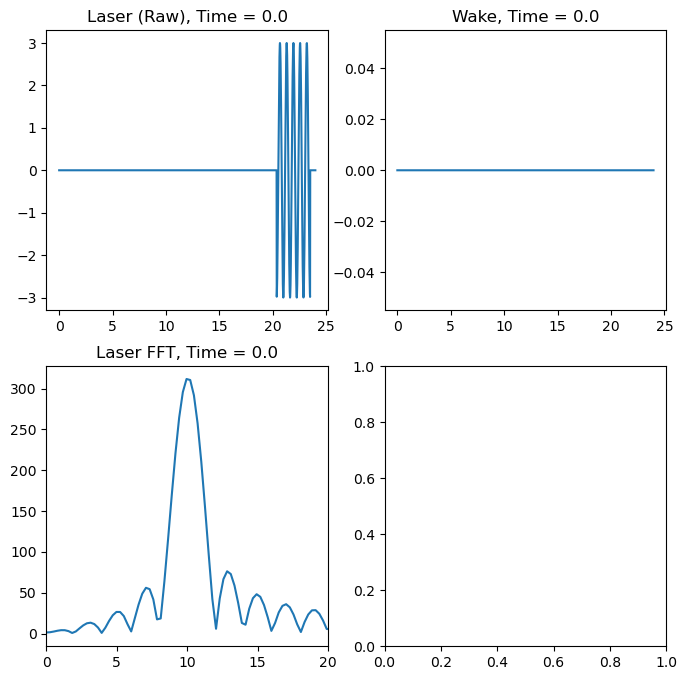

interactive(children=(Text(value='./linear-a03-w10/MS/', description='rundir'), IntSlider(value=0, description…

In [8]:
laser_slider_2(dirname+'/MS/')

In [9]:
import osh5vis
laser_slider_3(dirname+'/MS/')

interactive(children=(Text(value='./linear-a03-w10/MS/', description='rundir'), IntSlider(value=0, description…

In [13]:
# Here we used the basic functions defined above, and make a loop to produce movies.  In this case, turn off the display 
# to allow the program to quietly write the images to the disk.
#

for i in range(0,13600,50):
    laser_basic(dirname+'/MS/',i,show=False)

saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
savi

In [16]:
# Here we used the basic functions defined above, and make a loop to produce movies.  In this case, turn off the display 
# to allow the program to quietly write the images to the disk.
#
import osh5vis
for i in range(0,13600,50):
    laser_basic_2(dirname+'/MS/',i,show=False)

saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
savi

In [17]:
# Here we used the basic functions defined above, and make a loop to produce movies.  In this case, turn off the display 
# to allow the program to quietly write the images to the disk.
#

for i in range(0,13600,50):
    laser_basic_3(dirname+'/MS/',i,show=False)

saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
saving file
savi

In [10]:
#
# Here we are make a Wigner Transform and plot it
#


import numpy as np
import matplotlib
# the rwigner function takes a 1D numpy array and makes a wigner transform. 
#

# import osh5io
# import osh5def
# import osh5vis
# import osh5utils

# Han Wen's pyVisOS
# sys.path.append('/Volumes/Lacie-5TB/codes/pyVisOS/')

def rwigner(data):
    nx=data.shape[0]
    nxh = int( (nx+1)/2 )
    temp=np.zeros((nx,nx))
    wdata=np.zeros((nx,nx))
    temp1d=np.zeros(nx)
    dataplus=np.zeros(nx)
    dataminus=np.zeros(nx)
    temp[:,0]=data[:]*data[:]
    
    for j in range(1,nx):
        dataplus=np.roll(data,j)
        dataminus=np.roll(data,-j)
        temp[:,j] = dataplus[:] * dataminus[:]
        
    
    for i in range(nx):
        temp1d=np.abs(np.fft.fft(temp[i,:]))
        wdata[:,i]=temp1d[0:nx]
        
    return wdata
    
    
  


def os_rwigner(real_array,xaxis):

    nx=real_array.shape[0]
    nxh=int((nx+1)/2)
    print(xaxis.max)
    print(xaxis.min)
    dx=(xaxis.max-xaxis.min)/nx
    kmax=(np.pi)/dx
    dk=(2.0*np.pi)/(xaxis.max-xaxis.min)
    stretch_array=np.zeros(nx*2)
    stretch_array[0:nx]=real_array
    w_data= np.abs(rwigner(stretch_array))
    w_data_2=np.zeros((nx,nx))
    w_data_2 = w_data[0:nx,0:nx]

    kaxis=osh5def.DataAxis(0,kmax/2.0,nx,
                           attrs={'NAME':'k','LONG_NAME':'wave number'})

    data_attrs = { 'NAME': '$W_{\phi}$', 'LONG_NAME': 'Wigner Transform', 'UNITS': '$a.u.$' }
    run_attrs = {'XMAX' : np.array( [xaxis.max, kmax/2.0 ] ) , 
                 'XMIN' : np.array( [xaxis.min, 0 ] ) }

    os5data_wigner=osh5def.H5Data(w_data_2,timestamp='x', data_attrs=data_attrs, axes=[kaxis,xaxis])
    
    return os5data_wigner


def laser_basic_ver4(rundir,file_no,show=False,*args,**kwpassthrough):
    #
    #
        plasma_field_name = 'e1'
        laser_field_name = 'e3'
    #
    #
        species_1_name = 'electrons'


        electron_phase = file_name_phase(rundir,'p1x1',species_1_name,file_no)
        electron_dist = file_name_phase(rundir,'p1p2',species_1_name,file_no)
        
        electron_density = file_name_density(rundir,'charge',species_1_name,file_no)
        
        e1=file_name_field(rundir,'e1',file_no)
        e2=file_name_field(rundir,'e2',file_no)
        e3=file_name_field(rundir,'e3',file_no)
                
        e1_data=osh5io.read_h5(e1)
        e2_data=osh5io.read_h5(e2)
        e3_data=osh5io.read_h5(e3)
        
     
        e2_wigner=os_rwigner(e2_data,e2_data.axes[0])

        
        
        # e2_wigner.axes[1].max=e2_wigner.axes[1].max*0.5
        fig = plt.figure(figsize=(7,3.5) )

        plt.title('Time = '+str(e1_data.run_attrs['TIME'][0])  )
        plt.subplot(121)
        plt.plot(e2_data.axes[0],e2_data)    
            

        plt.subplot(122)
        # print(e1_data)
        osh5vis.osplot((e2_wigner),cblabel='Wigner',cmap='Reds',
                       norm=matplotlib.colors.LogNorm(vmax=3000,vmin=1e-3))
        plt.ylim(0,20)
        # plt.xlim(365,375)
        # plt.imshow(e2_wigner,cmap='gist_rainbow',norm=matplotlib.colors.LogNorm(vmax=100,vmin=0.1))
        # plt.xlim(0,40)
        # plt.ylim(0,20)
        if(show == True):
            plt.tight_layout()
            plt.show()
        else:
            print('saving file')
            fig.savefig(rundir+'/movie-4-'+repr(file_no).zfill(6)+'.png')
            plt.close(fig)
#
                           

420.89999999997815
396.9


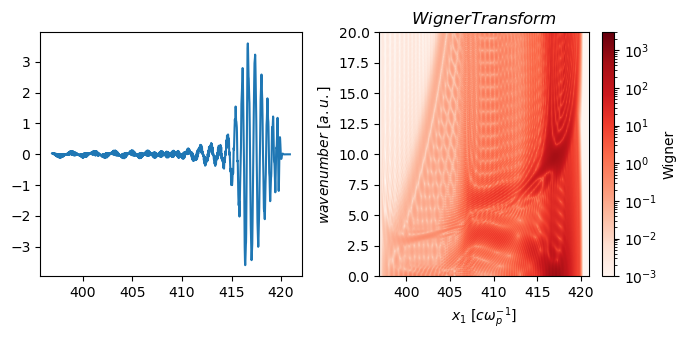

In [11]:
import osh5def
import osh5vis
laser_basic_ver4(dirname+'/MS/',13500,show=True)

In [12]:
    
def laser_slider_4(rundir,*args,**kwpassthrough):
    
    import os
    my_path=os.getcwd()
    working_dir = my_path+'/'+rundir
    wake_dir=rundir+'/FLD/e1/'
    files=sorted(os.listdir(wake_dir))
    # DEBUG
    # print(files[1])
    # DEBUG
    start=files[1].find('e1-')+3
    end=files[1].find('.')
    file_interval=int(files[1][start:end])
    file_max=(len(files)-1)*file_interval
    
    interact(laser_basic_ver4,rundir=(rundir),file_no=widgets.IntSlider(min=0,max=file_max,step=file_interval,value=0),show=True)    


In [13]:
laser_slider_4(dirname+'/MS/')

interactive(children=(Text(value='./linear-a03-w10/MS/', description='rundir'), IntSlider(value=0, description…

In [28]:
# Here we used the basic functions defined above, and make a loop to produce movies.  In this case, turn off the display 
# to allow the program to quietly write the images to the disk.
#

for i in range(0,13500,150):
    laser_basic_ver4(dirname+'/MS/',i,show=False)

24.0
0.0
saving file
28.40999999999949
4.41
saving file
32.82000000000091
8.82
saving file
37.230000000000906
13.229999999999999
saving file
41.64000000000091
17.64
saving file
46.05000000000091
22.05
saving file
50.4600000000009
26.459999999999997
saving file
54.87000000000091
30.869999999999997
saving file
59.28000000000091
35.28
saving file
63.69000000000091
39.69
saving file
68.10000000000093
44.1
saving file
72.51000000000093
48.51
saving file
76.92000000000093
52.919999999999995
saving file
81.33000000000091
57.33
saving file
85.7400000000009
61.739999999999995
saving file
90.1500000000009
66.14999999999999
saving file
94.56000000000091
70.56
saving file
98.97000000000091
74.97
saving file
103.3800000000009
79.38
saving file
107.7900000000009
83.78999999999999
saving file
112.20000000000091
88.2
saving file
116.61000000000091
92.61
saving file
121.0200000000009
97.02
saving file
125.4300000000009
101.42999999999999
saving file
129.84000000000088
105.83999999999999
saving file
134

<IPython.core.display.Javascript object>


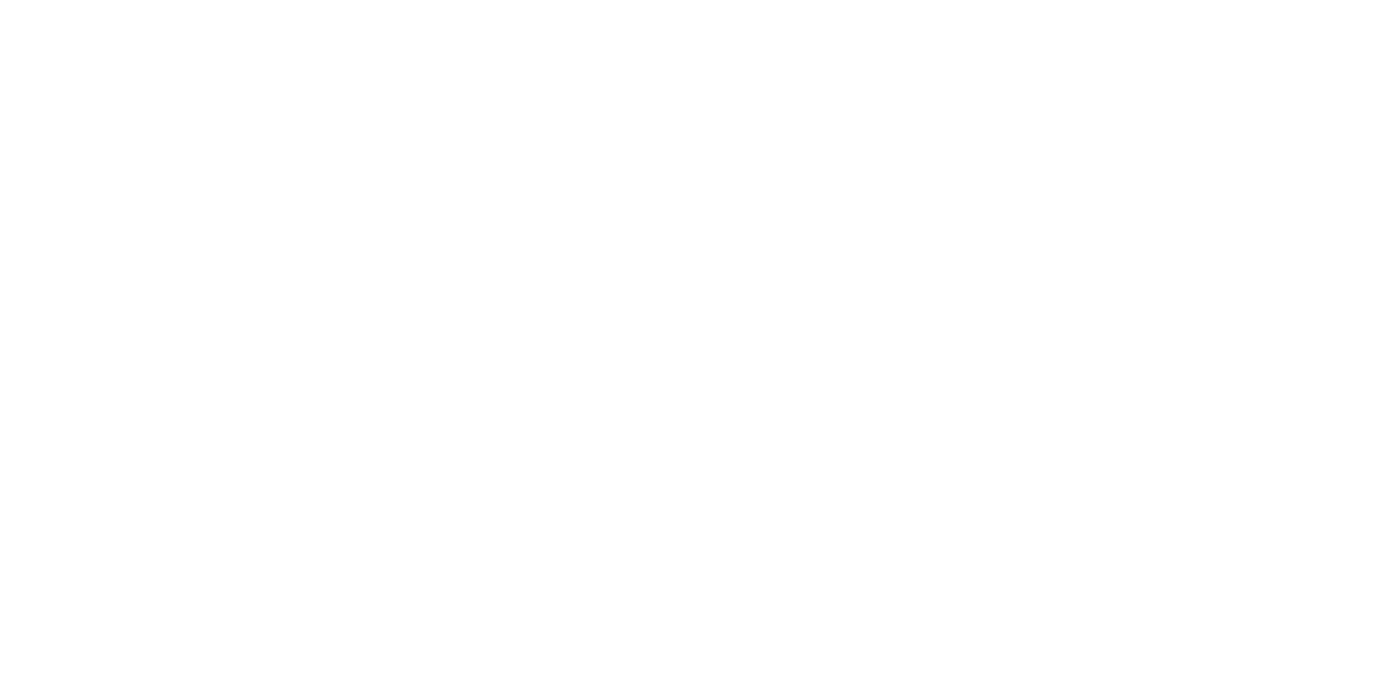

24.0
0.0
saving file


<IPython.core.display.Javascript object>


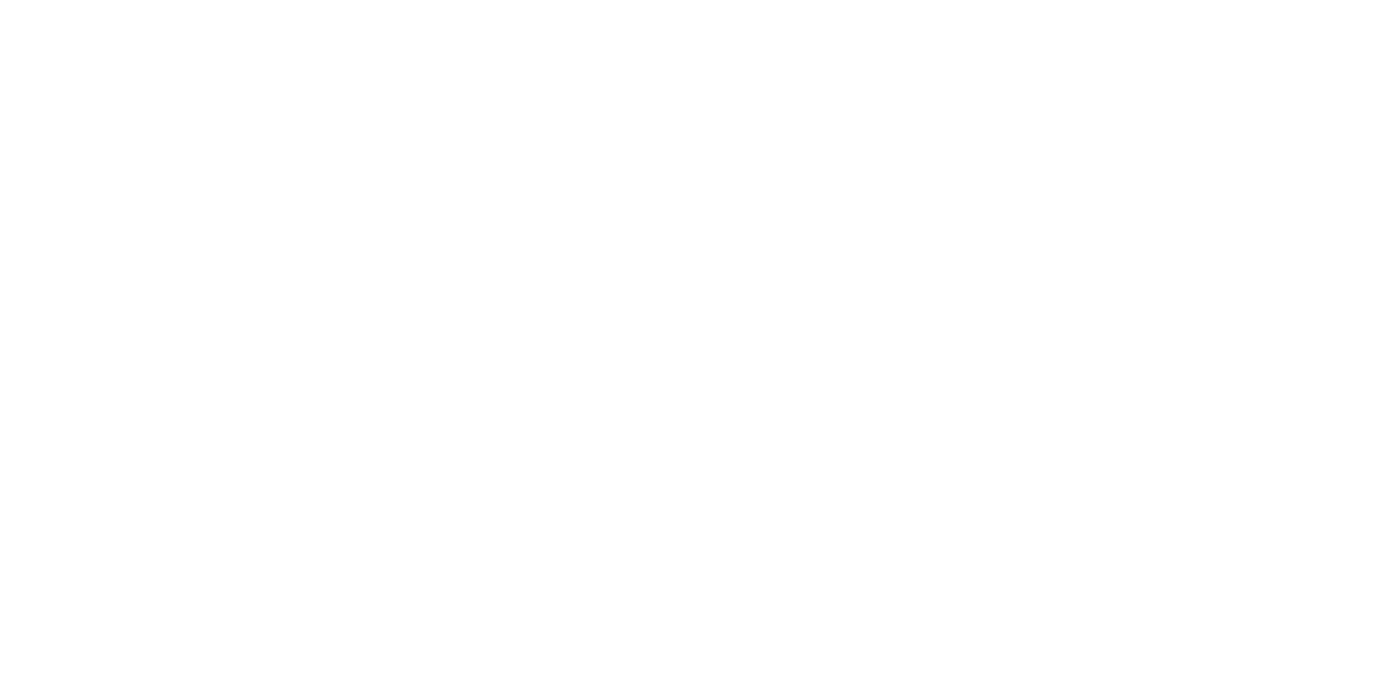

32.82000000000091
8.82
saving file


<IPython.core.display.Javascript object>


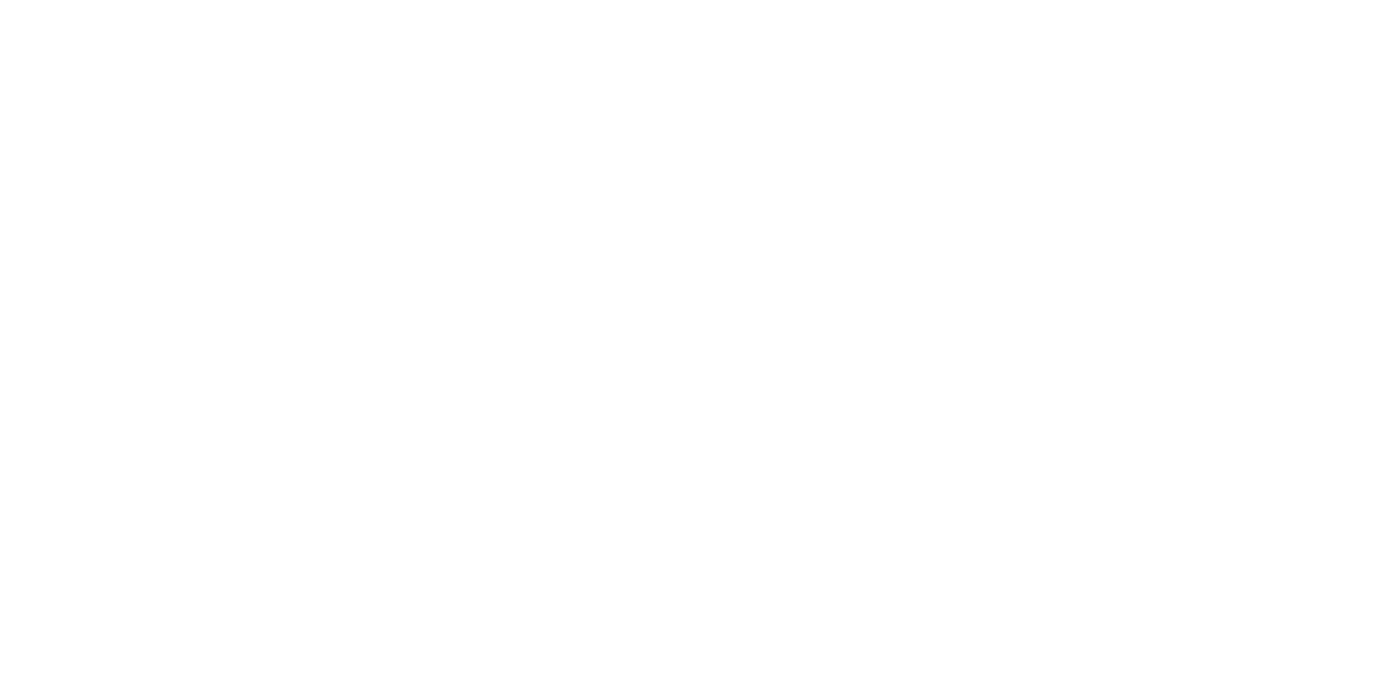

41.64000000000091
17.64
saving file


<IPython.core.display.Javascript object>


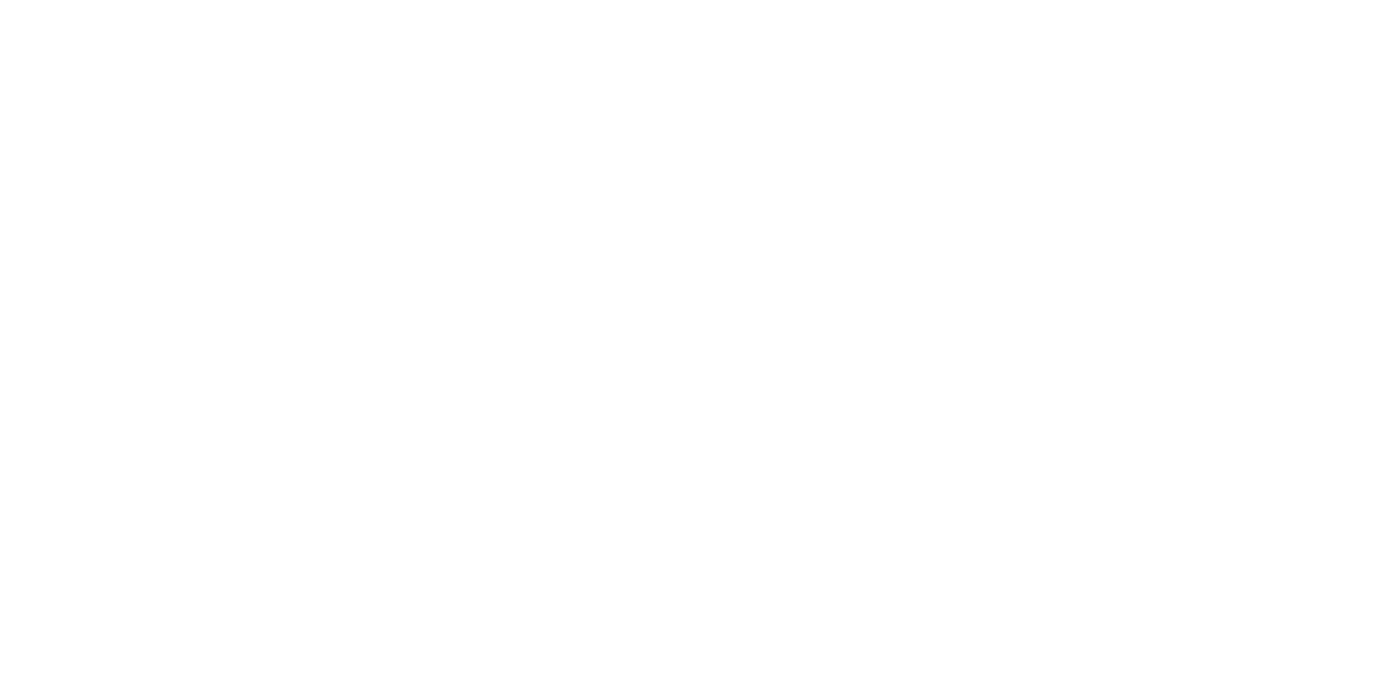

50.4600000000009
26.459999999999997
saving file


<IPython.core.display.Javascript object>


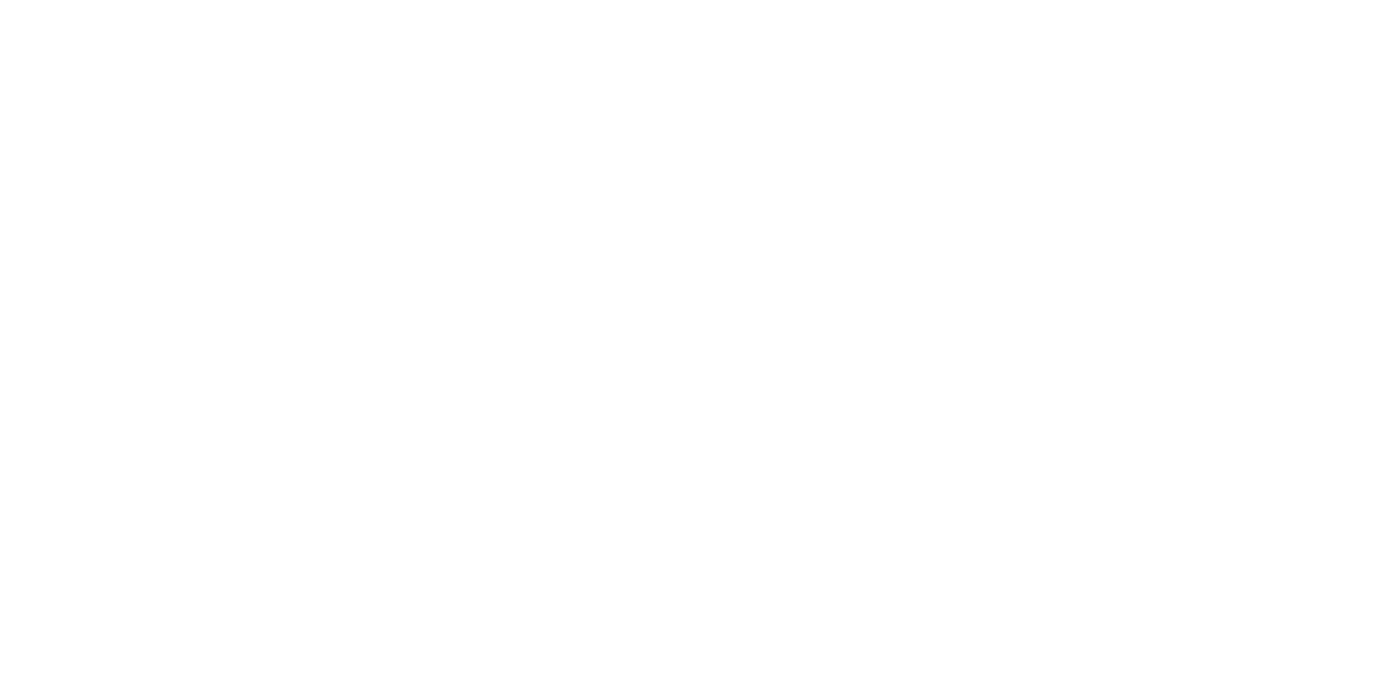

59.28000000000091
35.28
saving file


<IPython.core.display.Javascript object>


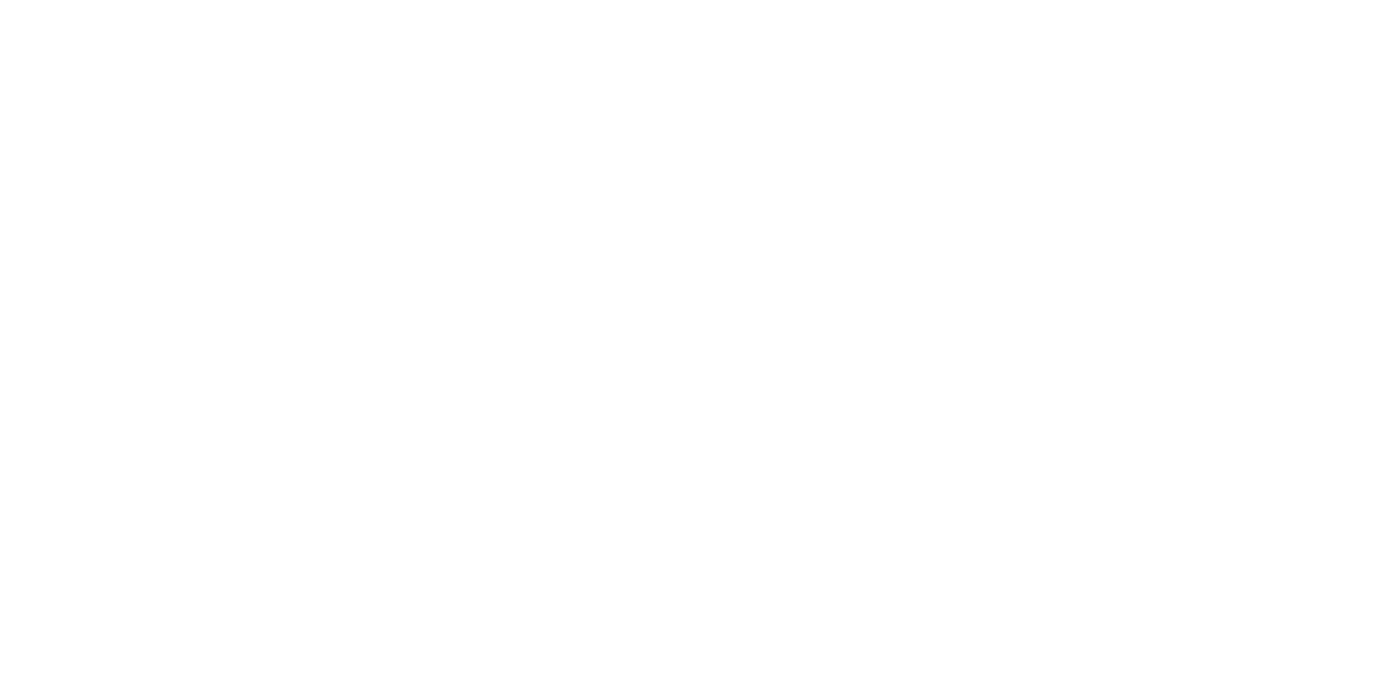

68.10000000000093
44.1
saving file


<IPython.core.display.Javascript object>


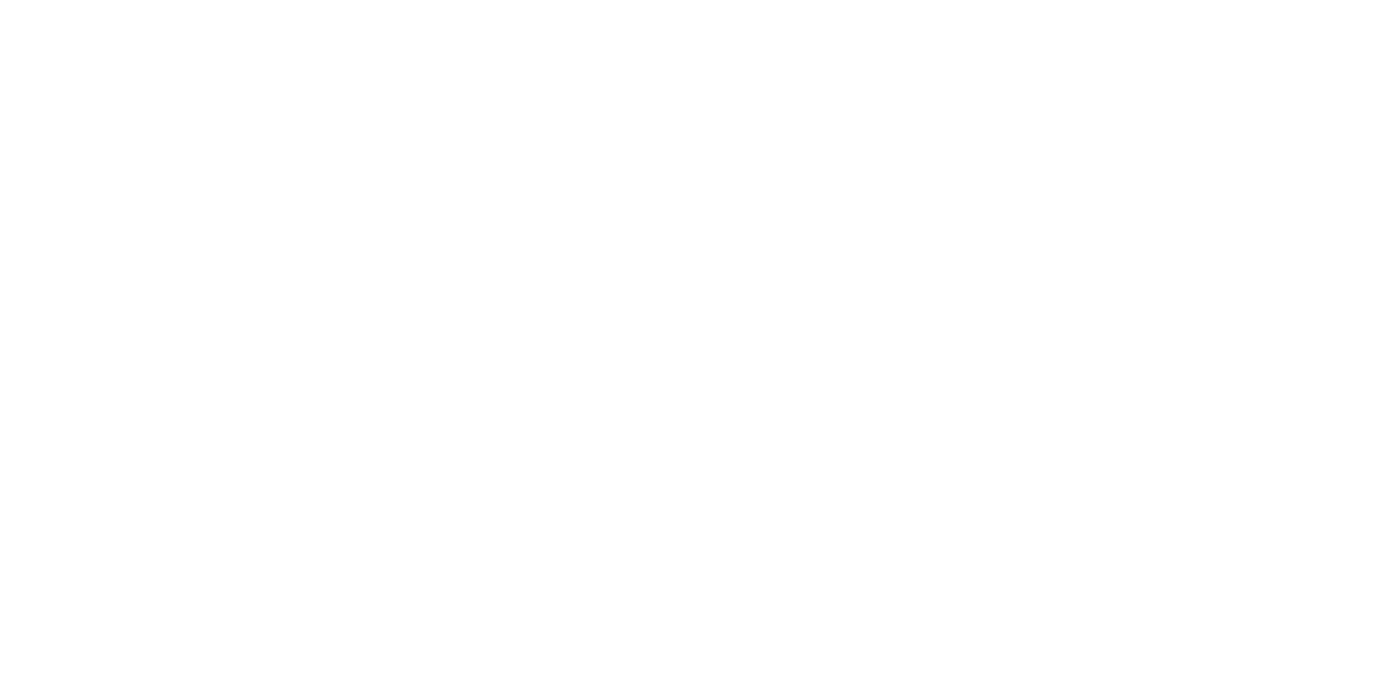

76.92000000000093
52.919999999999995
saving file


<IPython.core.display.Javascript object>


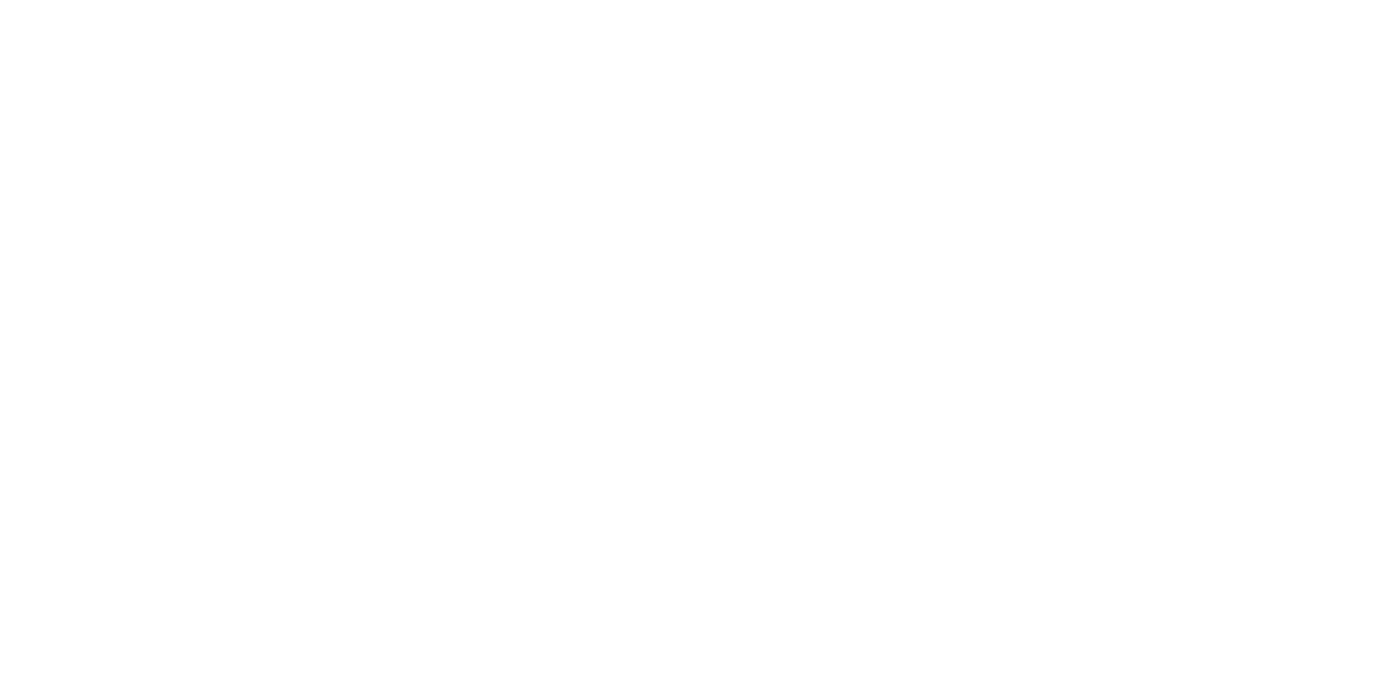

85.7400000000009
61.739999999999995
saving file


<IPython.core.display.Javascript object>


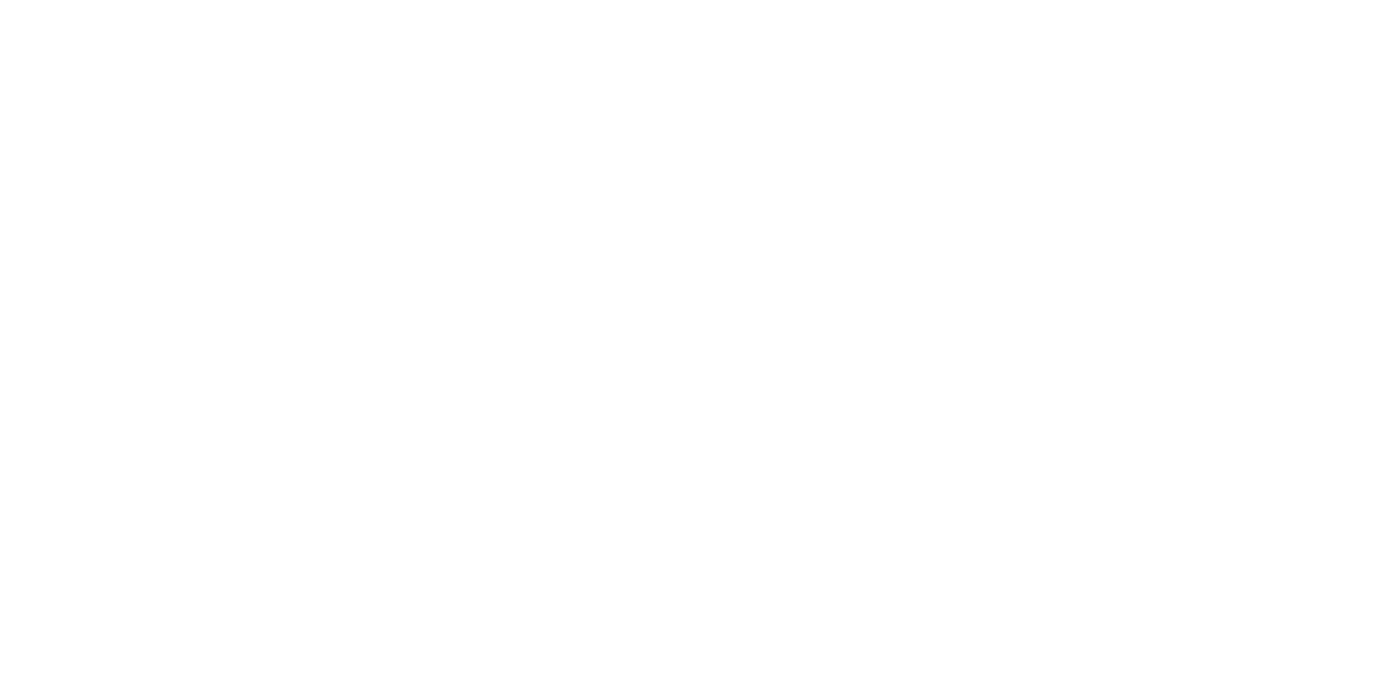

94.56000000000091
70.56
saving file


<IPython.core.display.Javascript object>


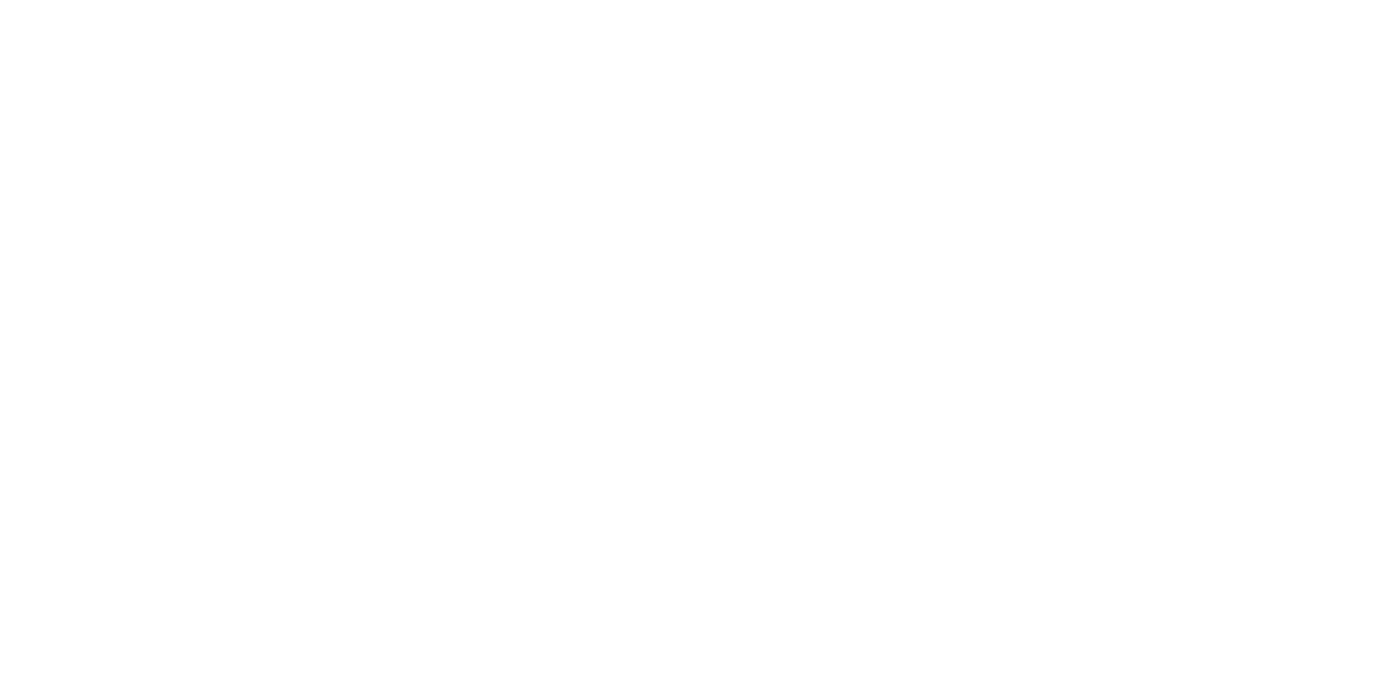

103.3800000000009
79.38
saving file


<IPython.core.display.Javascript object>


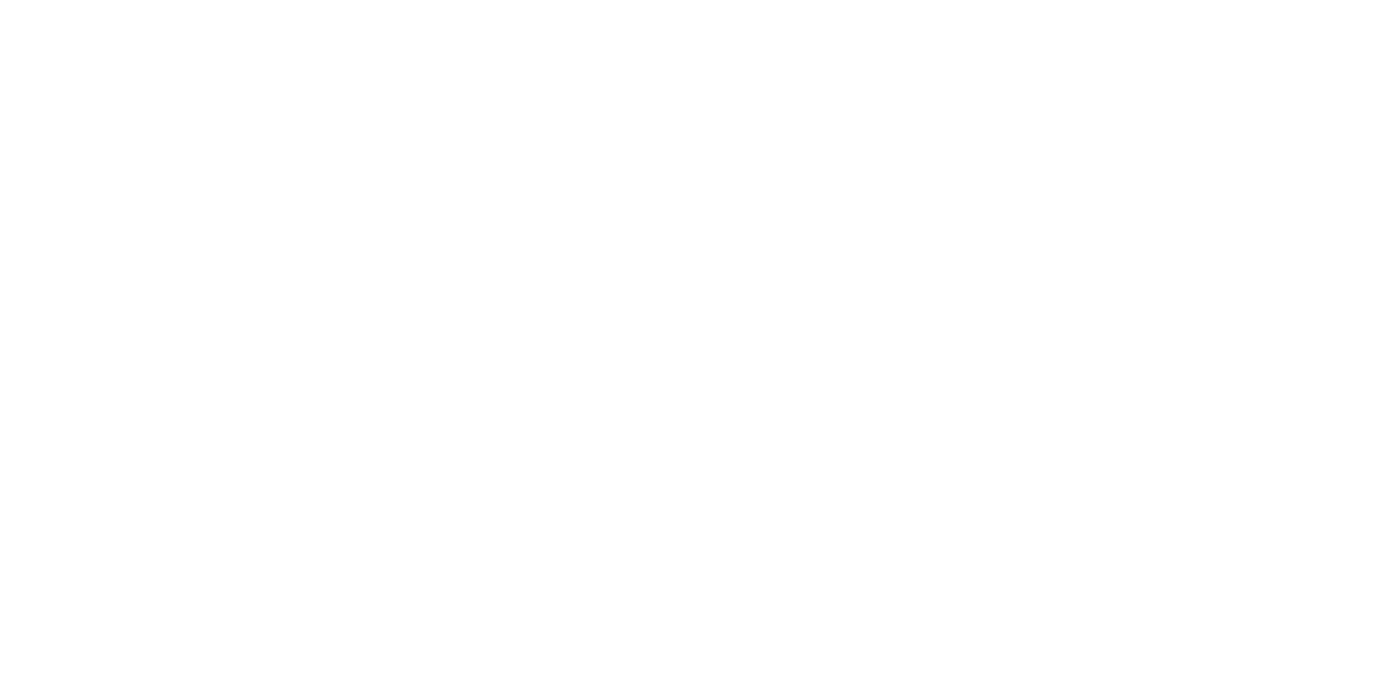

112.20000000000091
88.2
saving file


<IPython.core.display.Javascript object>


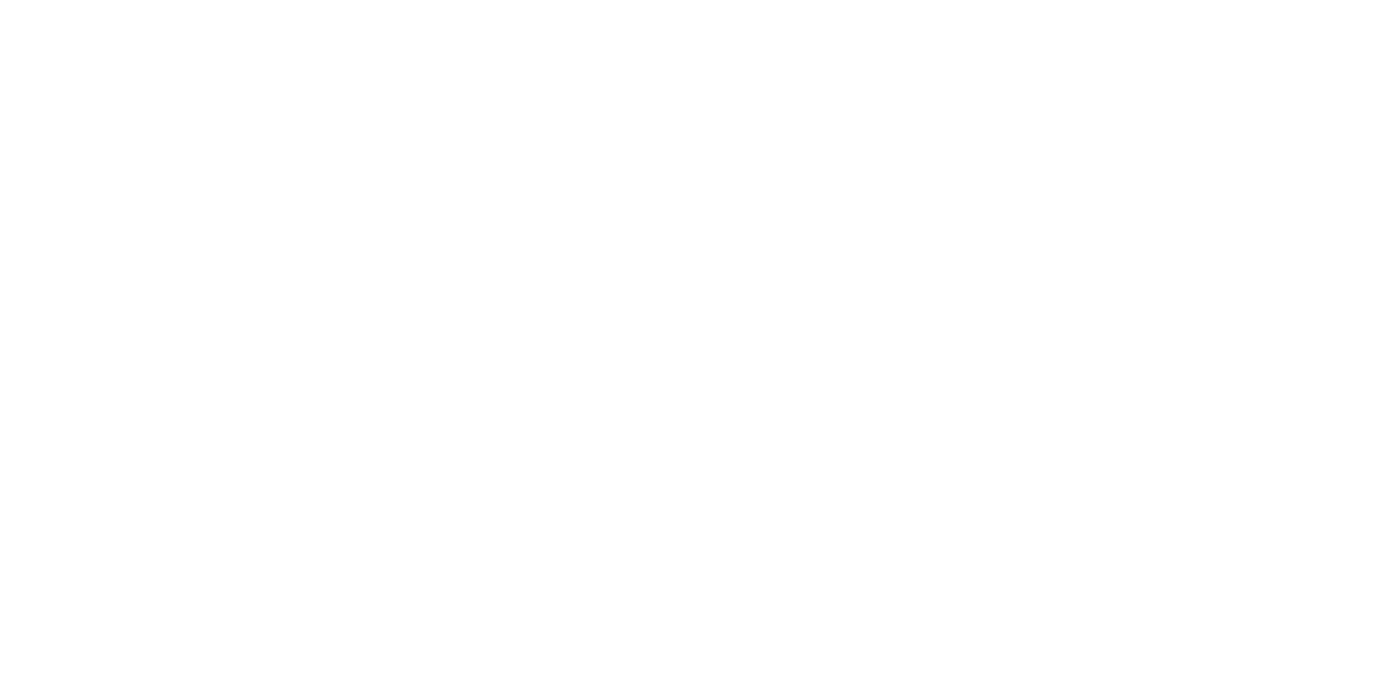

121.0200000000009
97.02
saving file


<IPython.core.display.Javascript object>


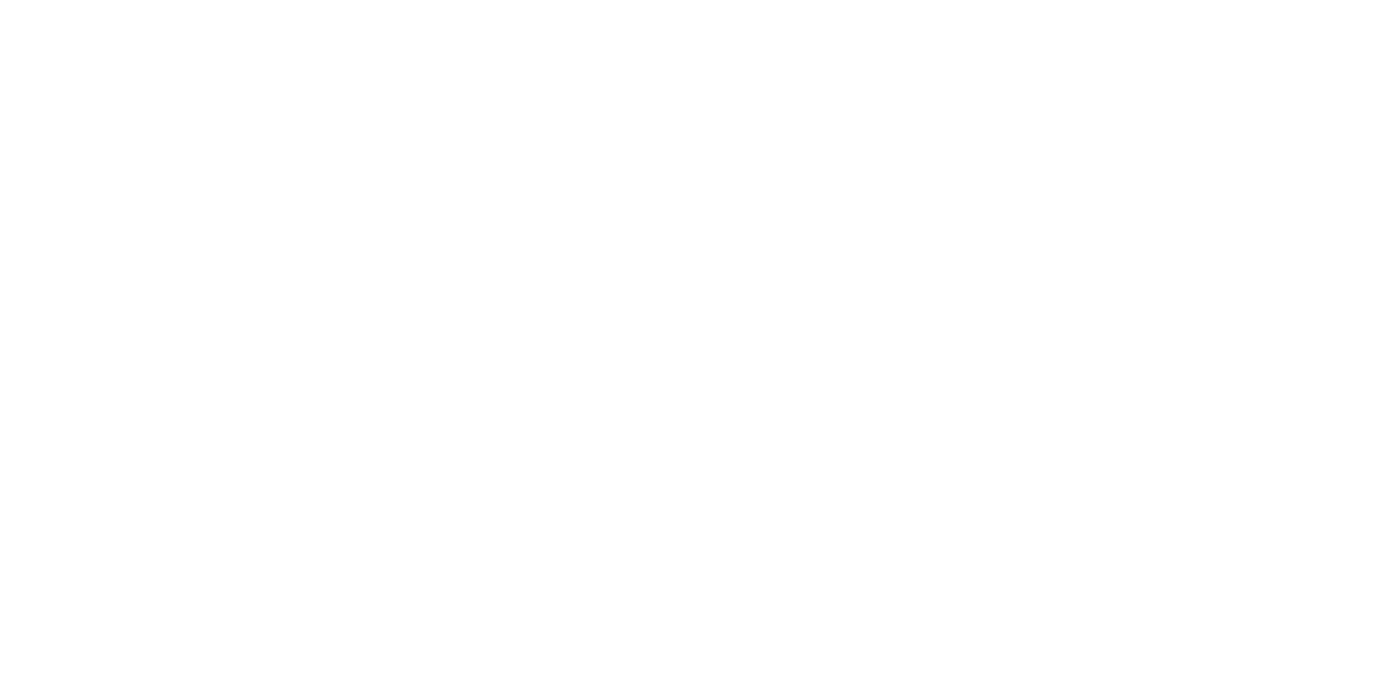

129.84000000000088
105.83999999999999
saving file


<IPython.core.display.Javascript object>


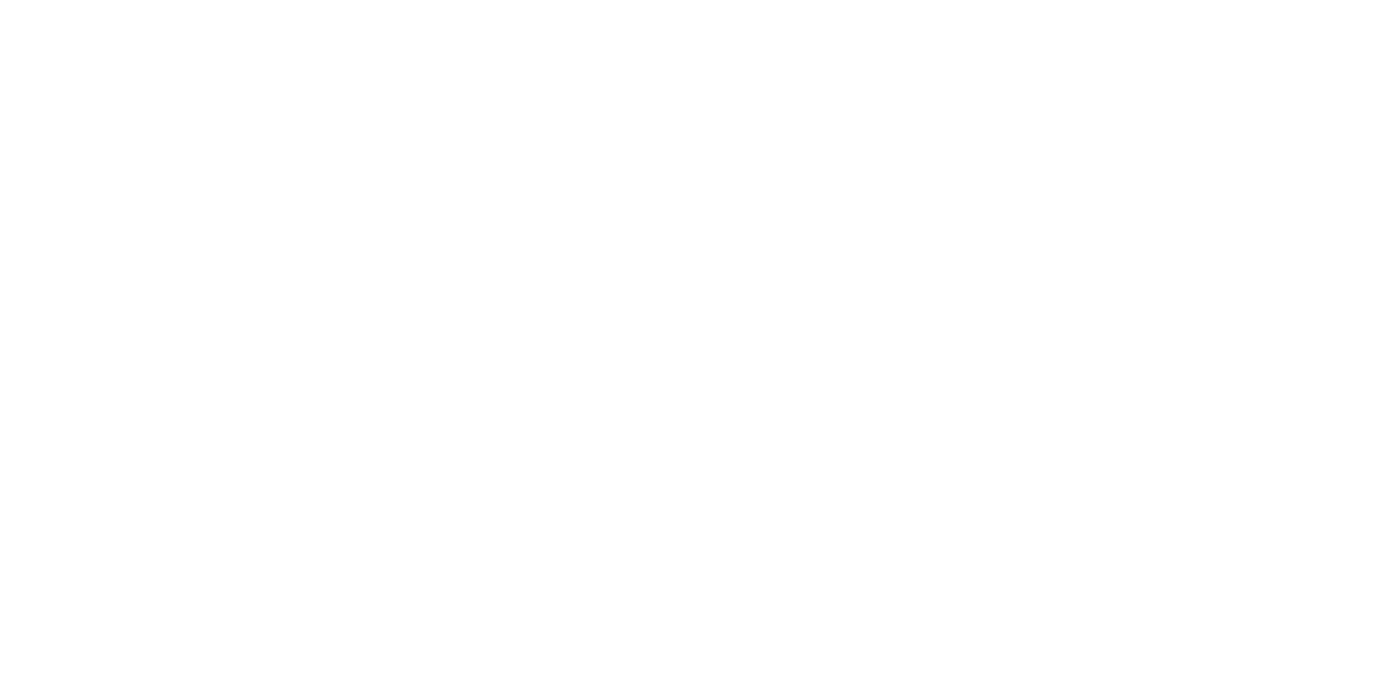

138.6600000000009
114.66
saving file


<IPython.core.display.Javascript object>


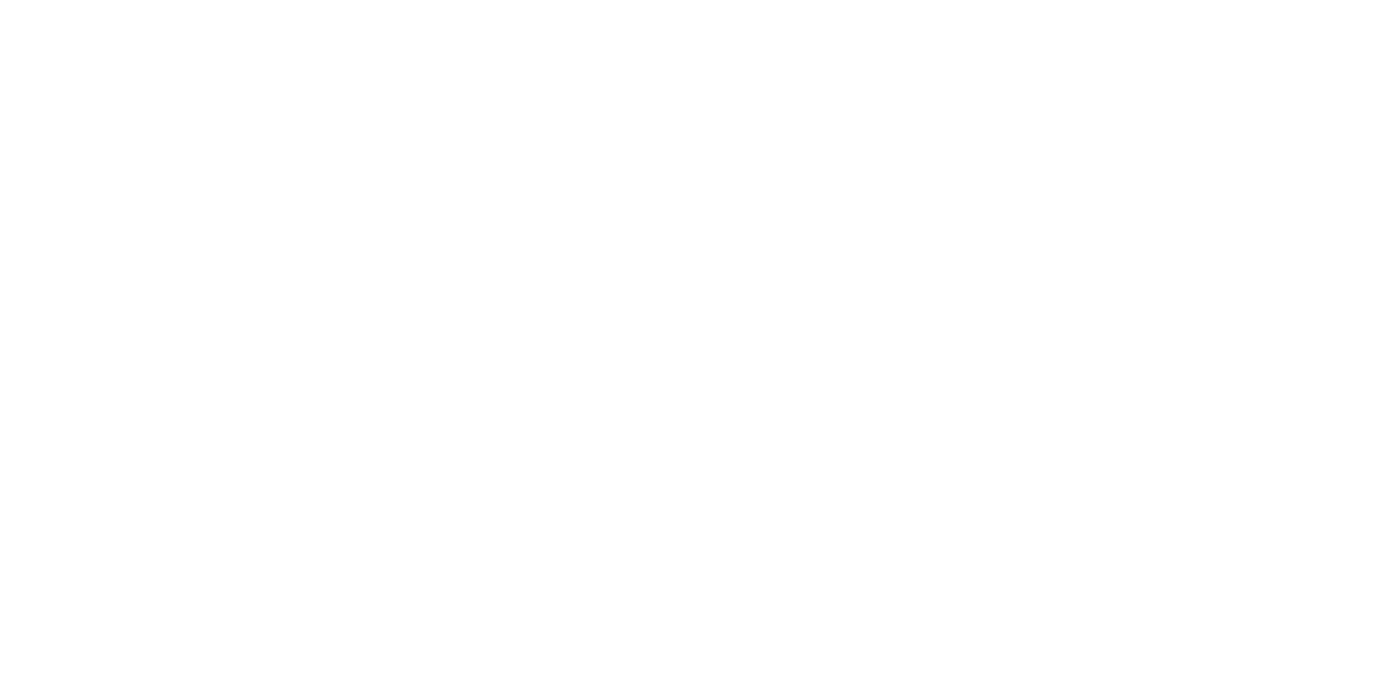

147.4800000000009
123.47999999999999
saving file


<IPython.core.display.Javascript object>


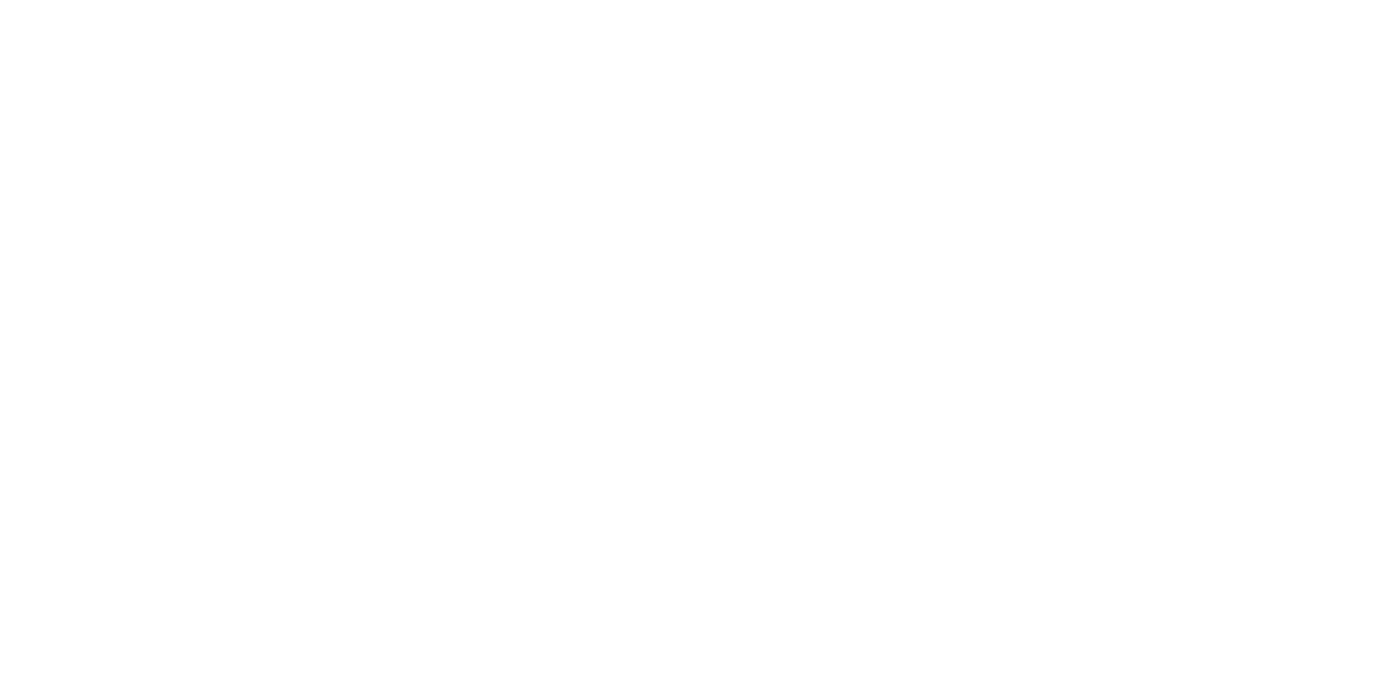

156.29999999997816
132.29999999999998
saving file


<IPython.core.display.Javascript object>


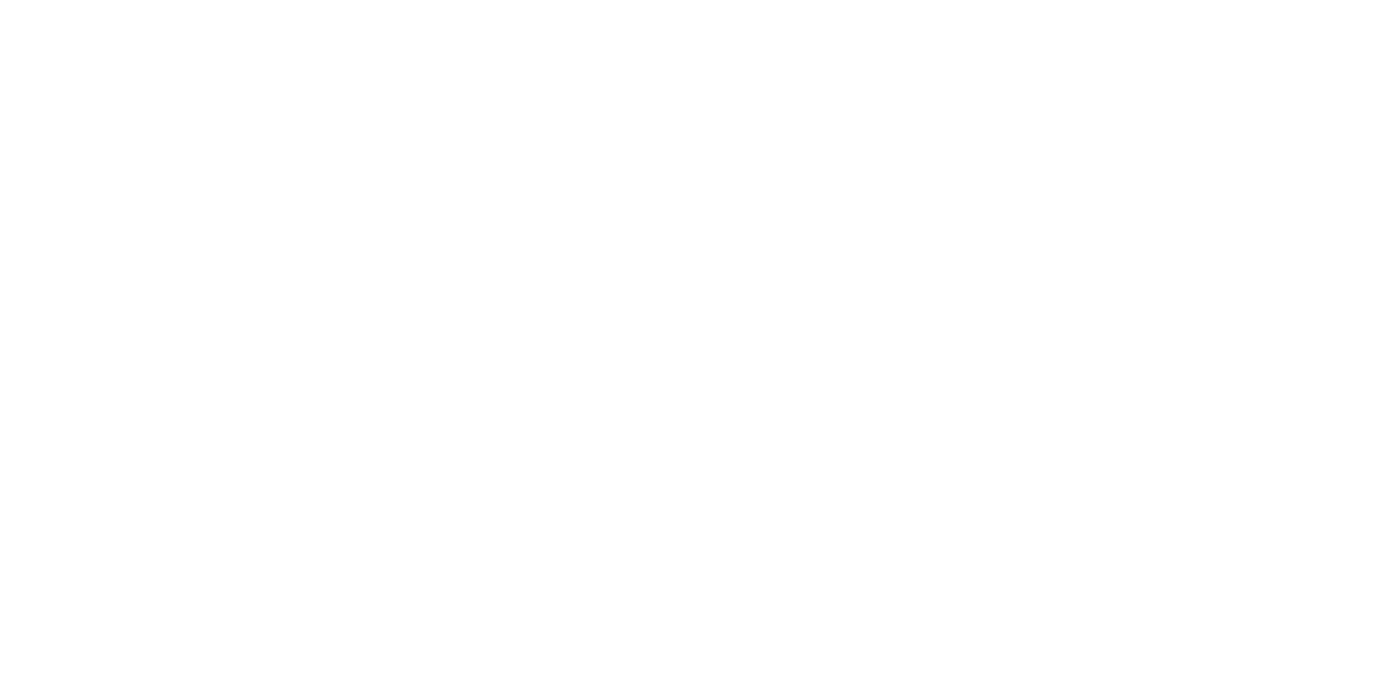

165.11999999997818
141.12
saving file


<IPython.core.display.Javascript object>


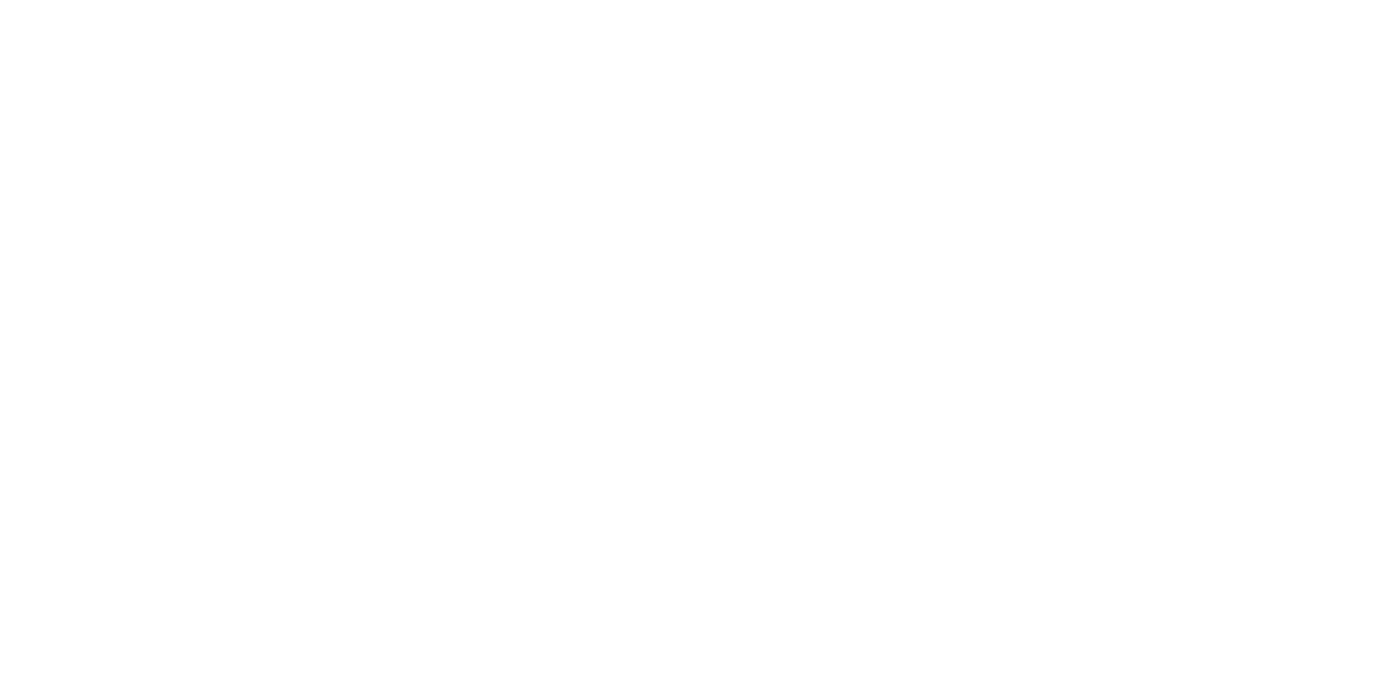

173.93999999997817
149.94
saving file


<IPython.core.display.Javascript object>


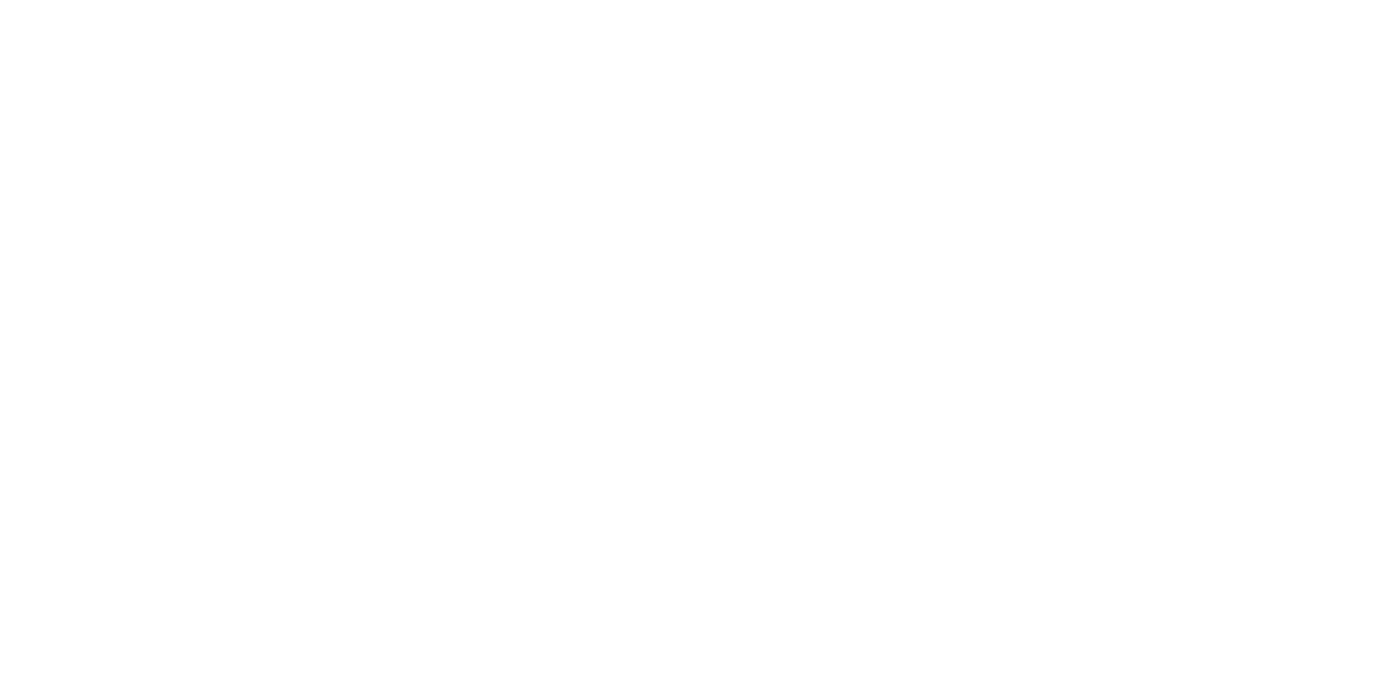

182.75999999997816
158.76
saving file


<IPython.core.display.Javascript object>


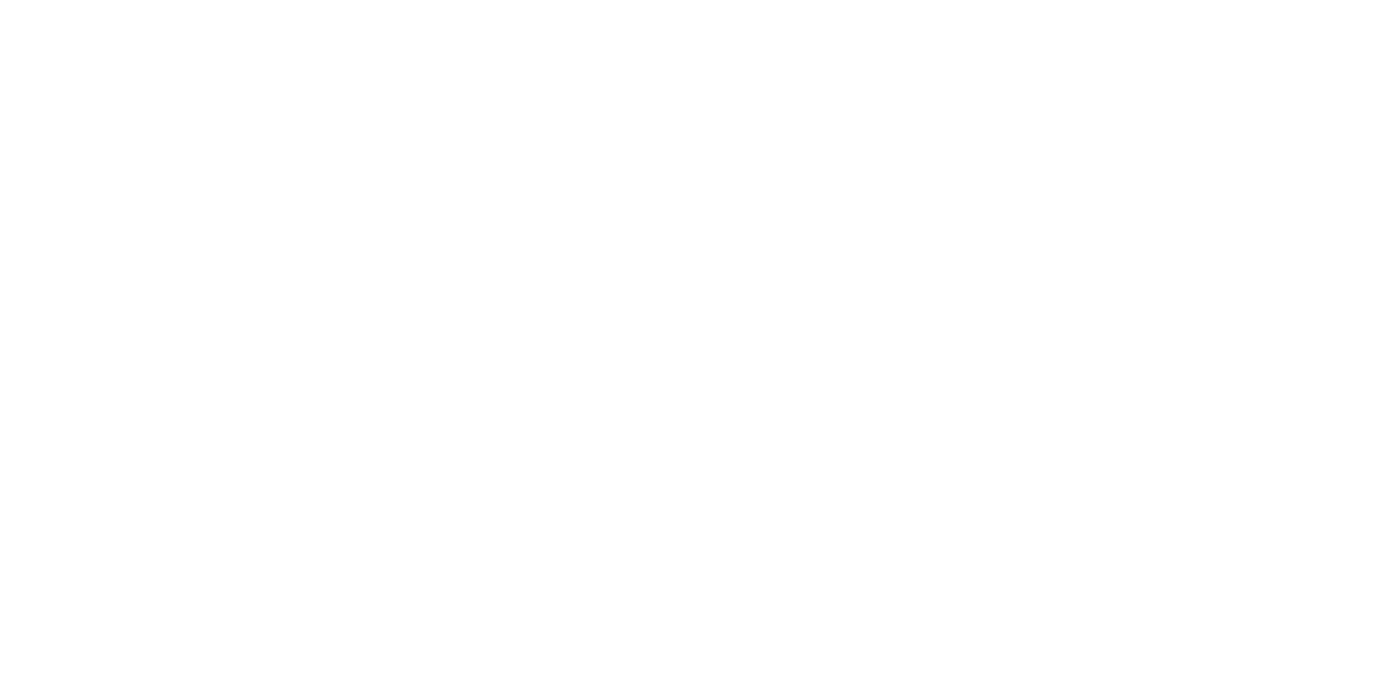

191.57999999997816
167.57999999999998
saving file


<IPython.core.display.Javascript object>


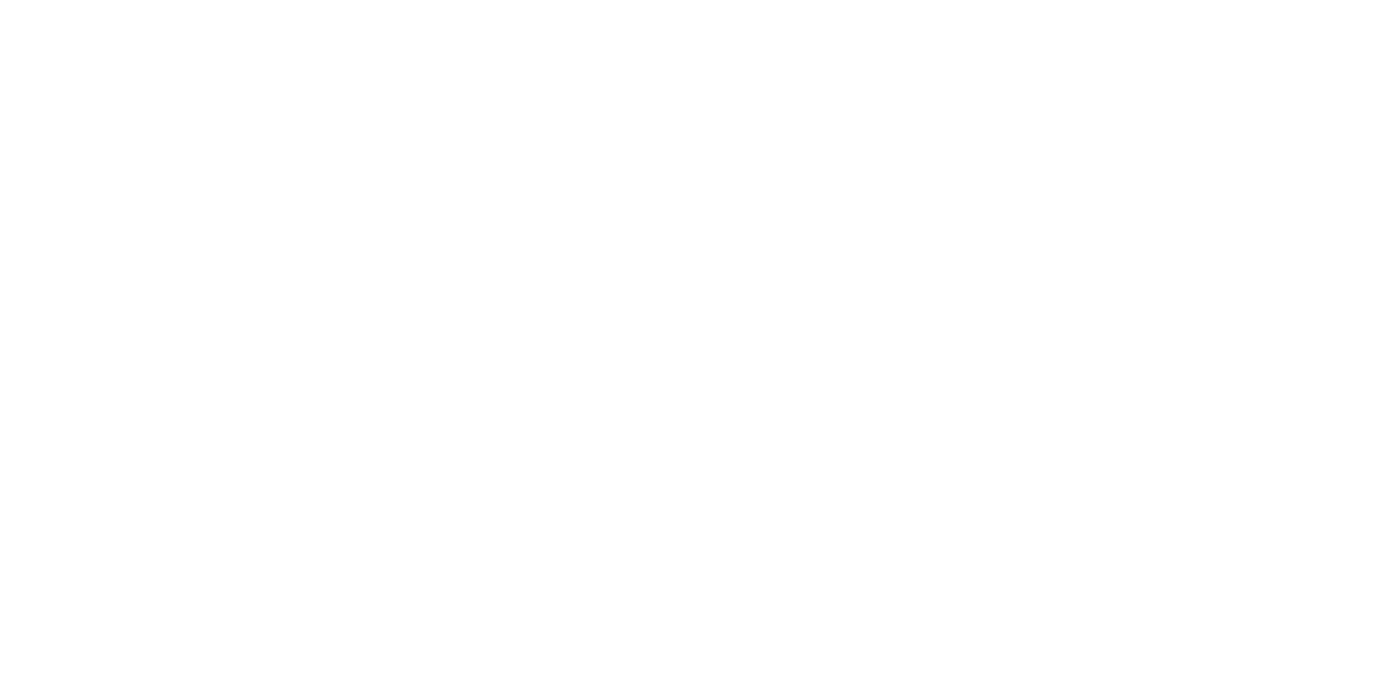

200.39999999997818
176.4
saving file


<IPython.core.display.Javascript object>


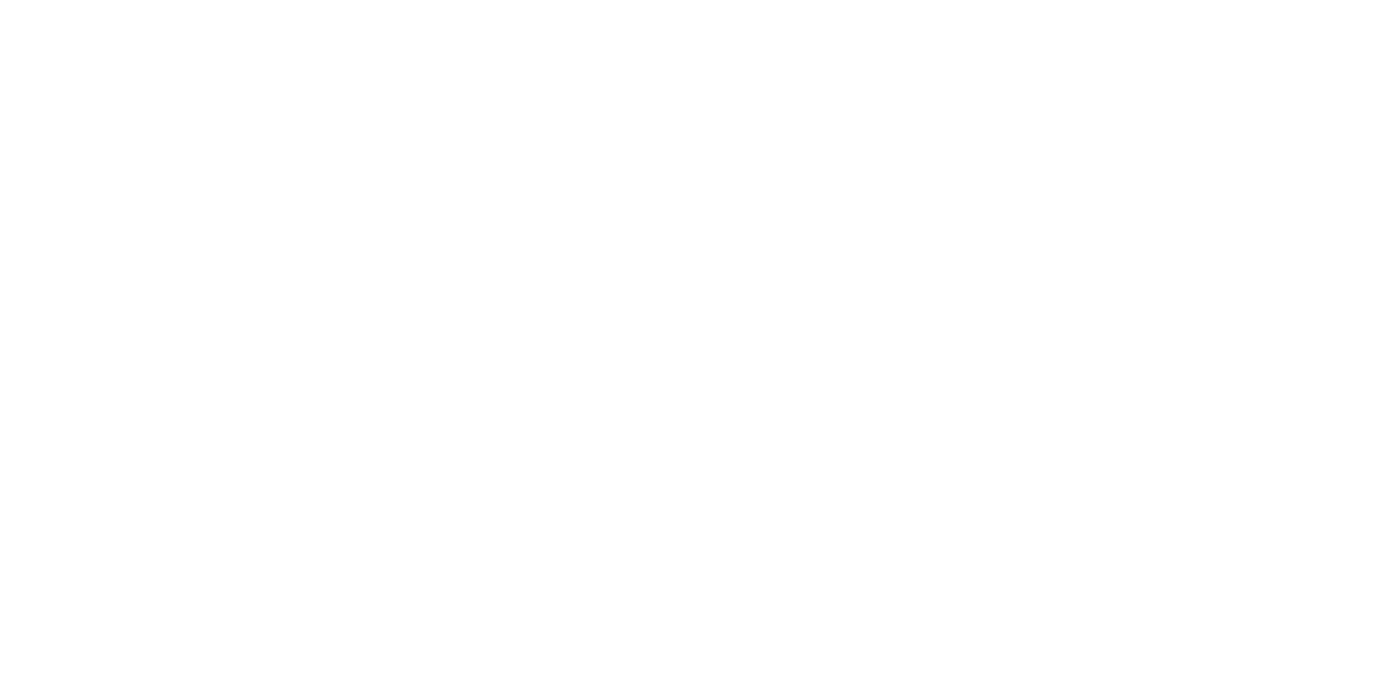

209.21999999997817
185.22
saving file


<IPython.core.display.Javascript object>


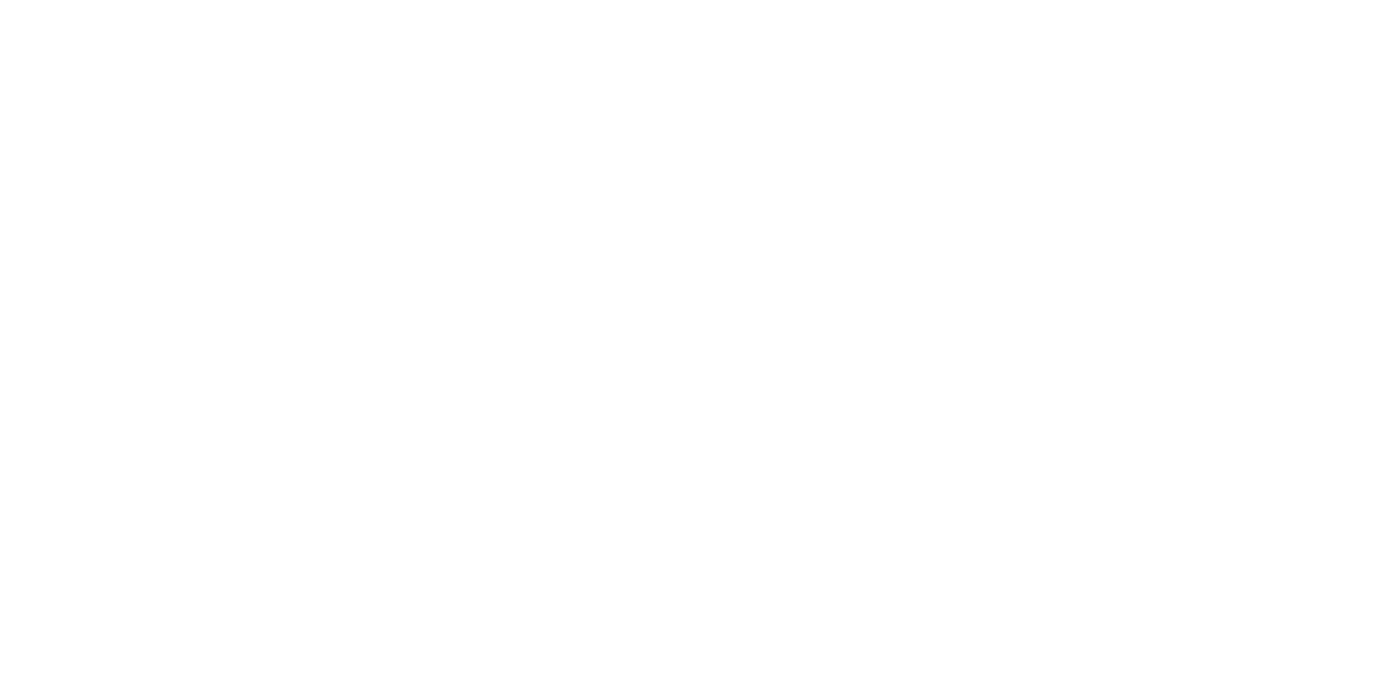

218.03999999997816
194.04
saving file


<IPython.core.display.Javascript object>


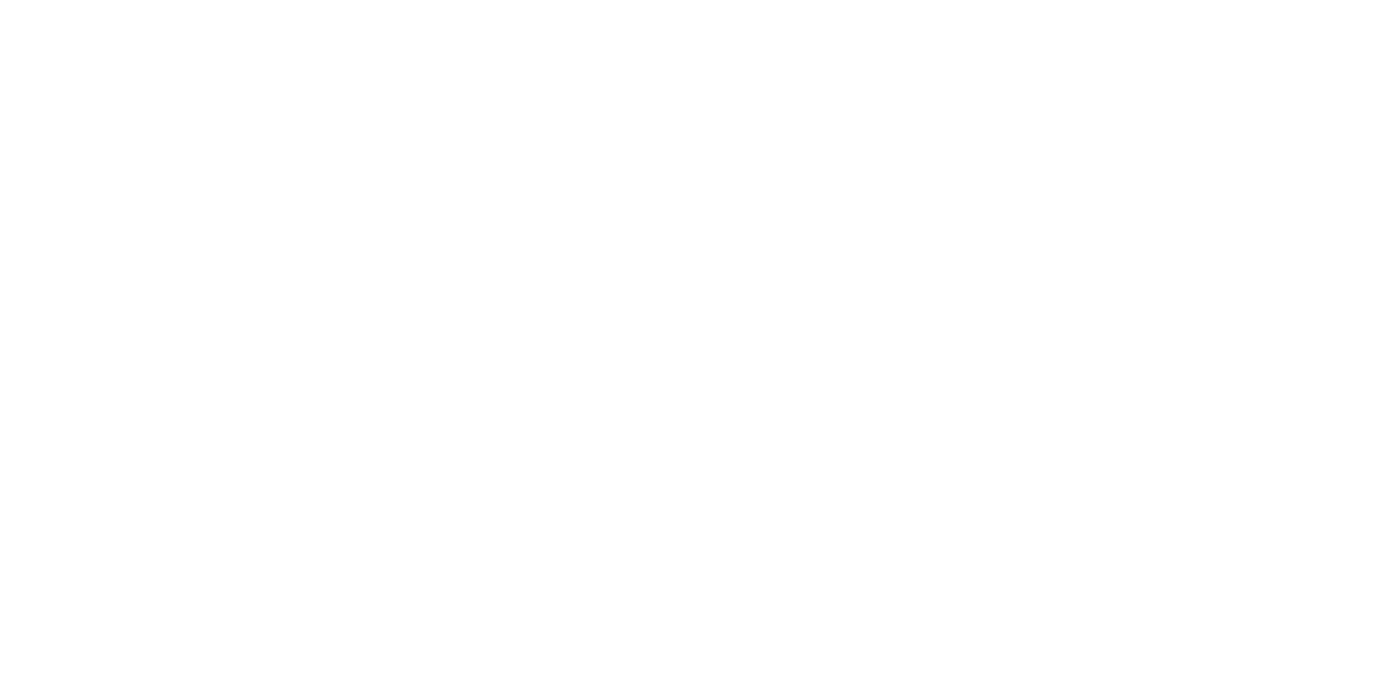

226.85999999997816
202.85999999999999
saving file


<IPython.core.display.Javascript object>


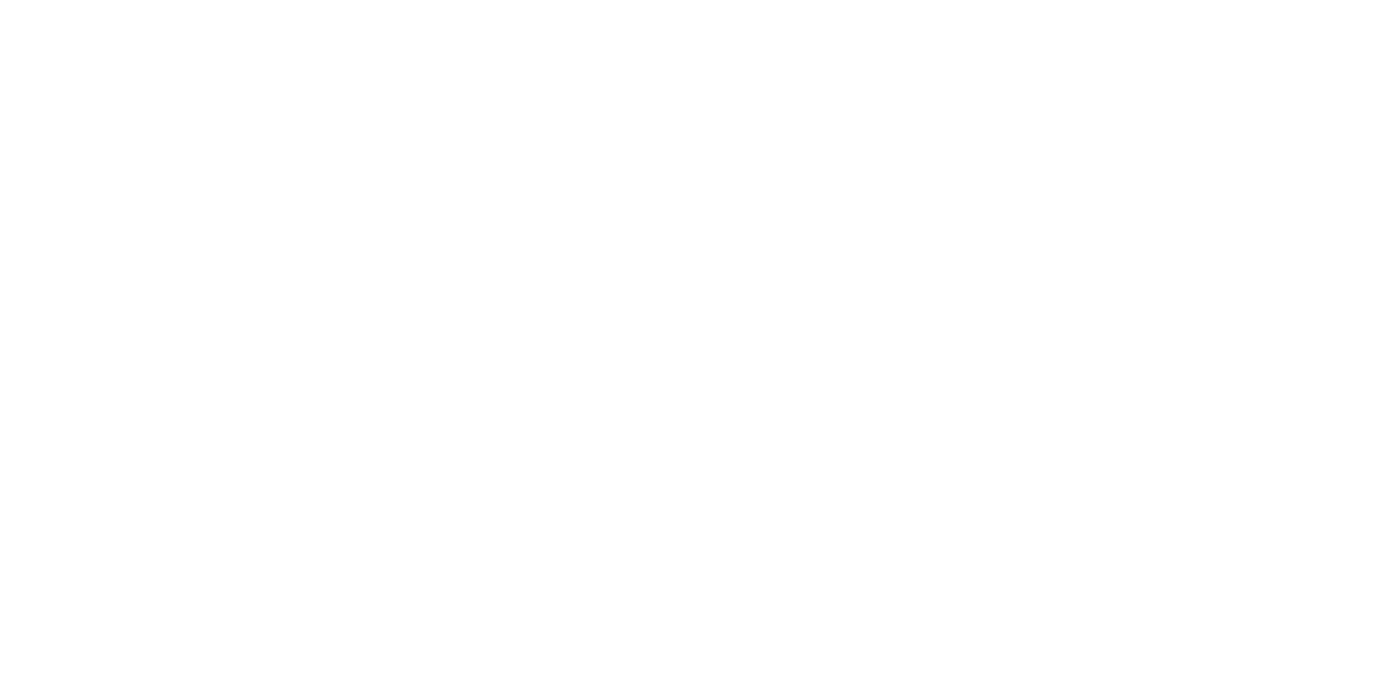

235.67999999997815
211.67999999999998
saving file


<IPython.core.display.Javascript object>


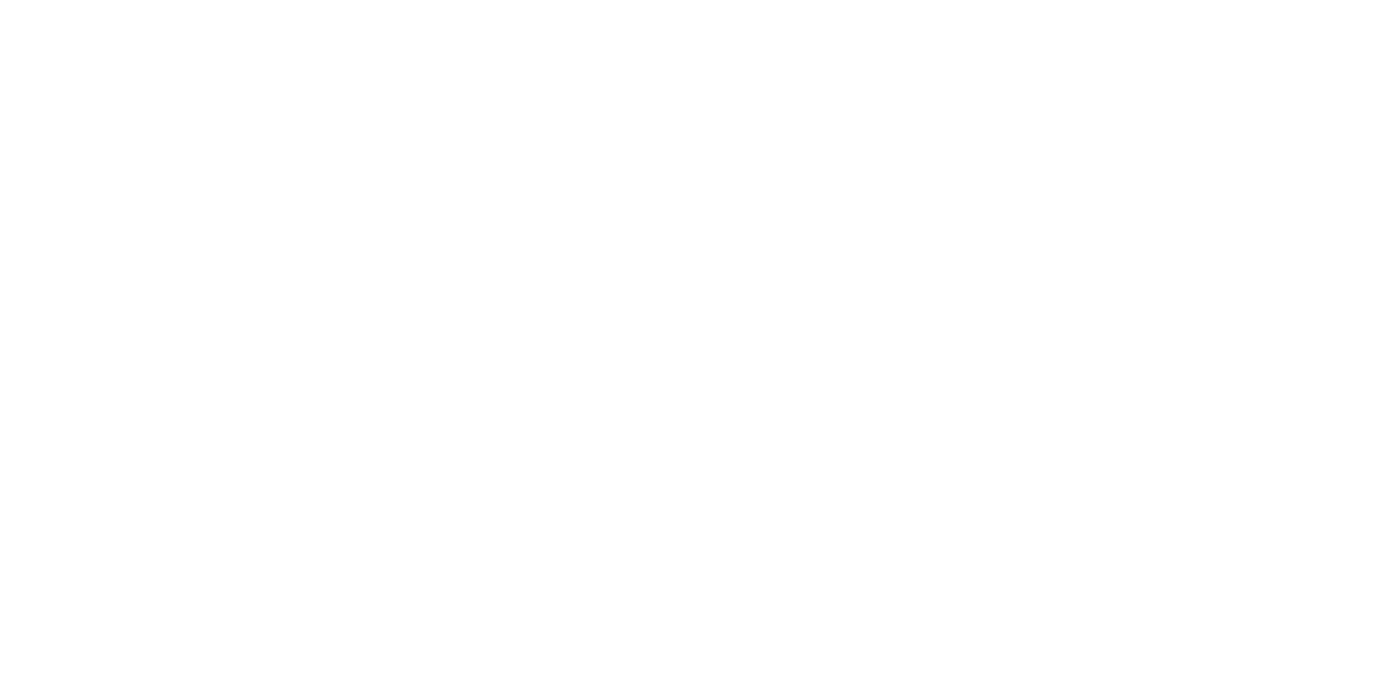

244.49999999997817
220.5
saving file


<IPython.core.display.Javascript object>


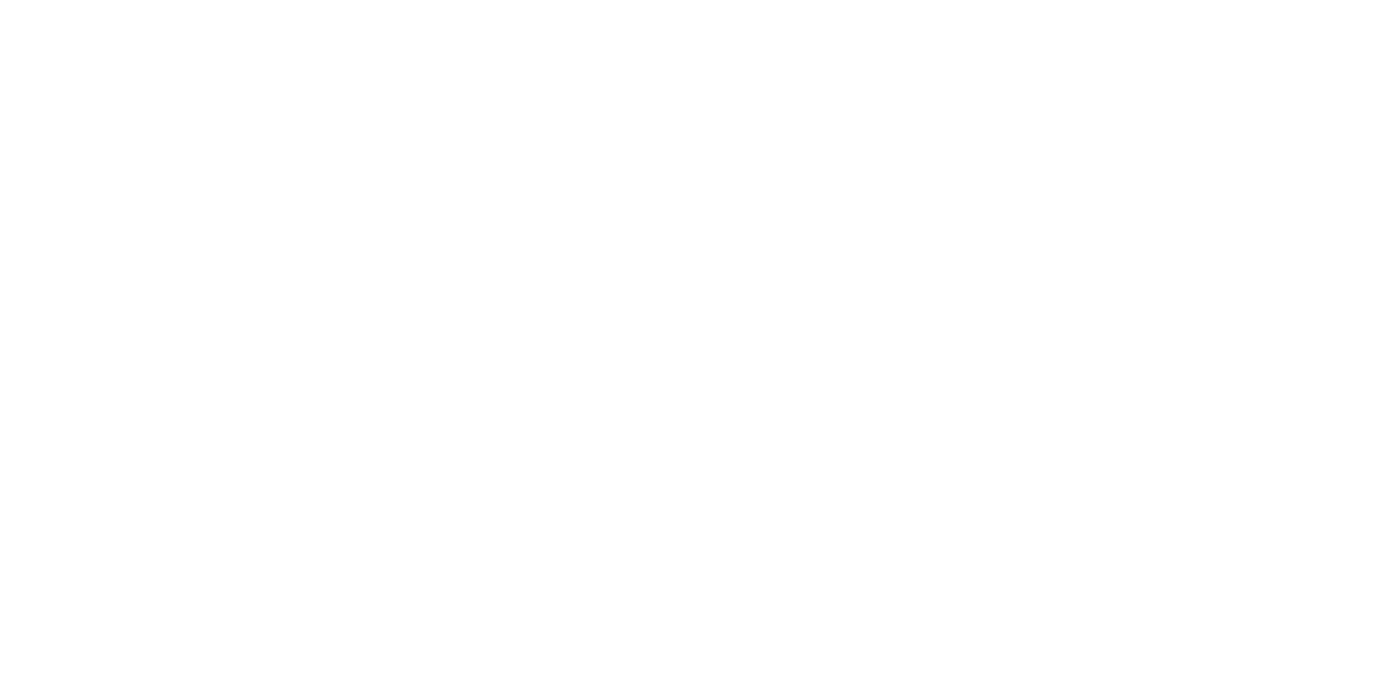

253.31999999997817
229.32
saving file


<IPython.core.display.Javascript object>


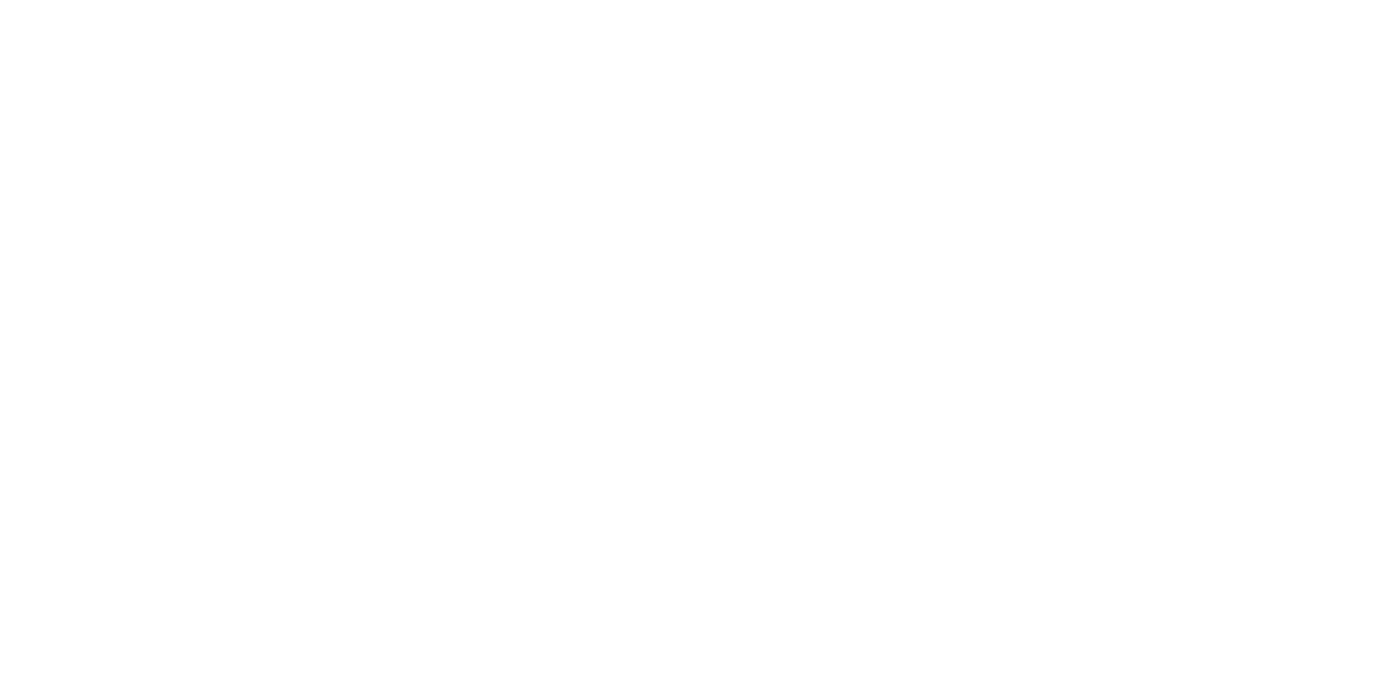

262.13999999997816
238.14
saving file


<IPython.core.display.Javascript object>


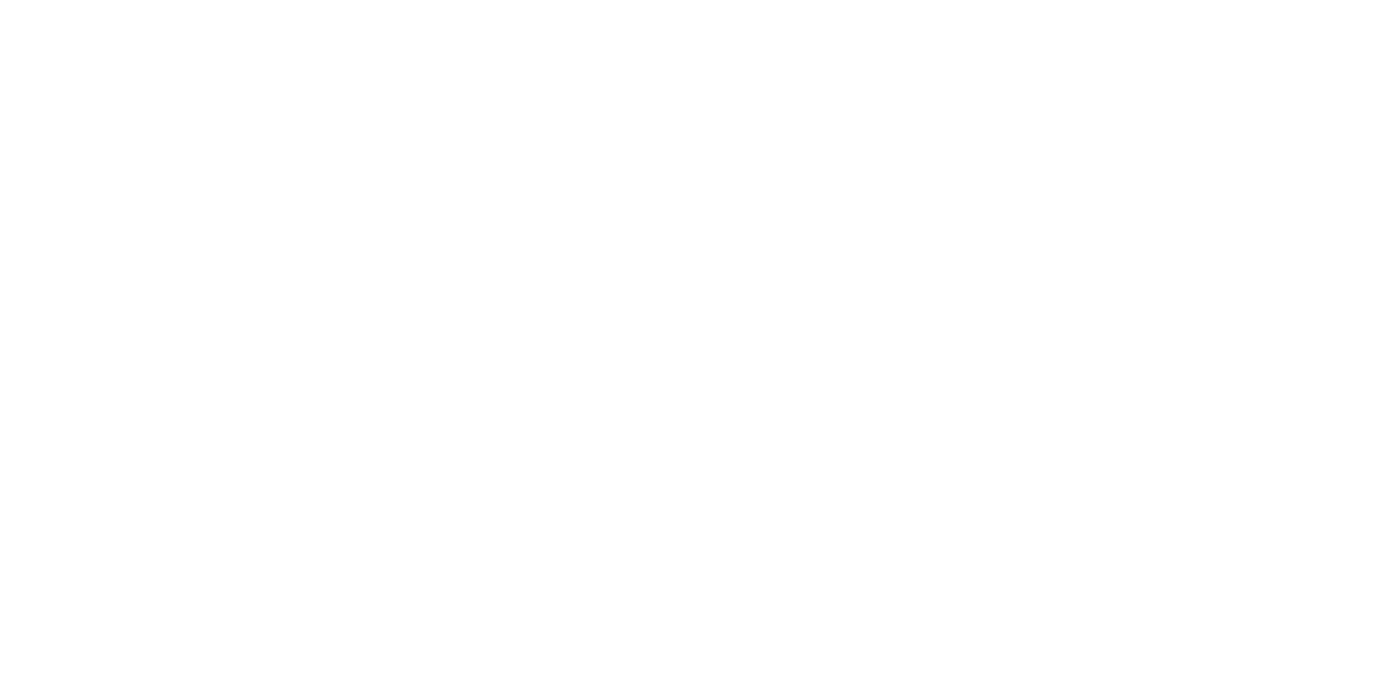

270.95999999997815
246.95999999999998
saving file


<IPython.core.display.Javascript object>


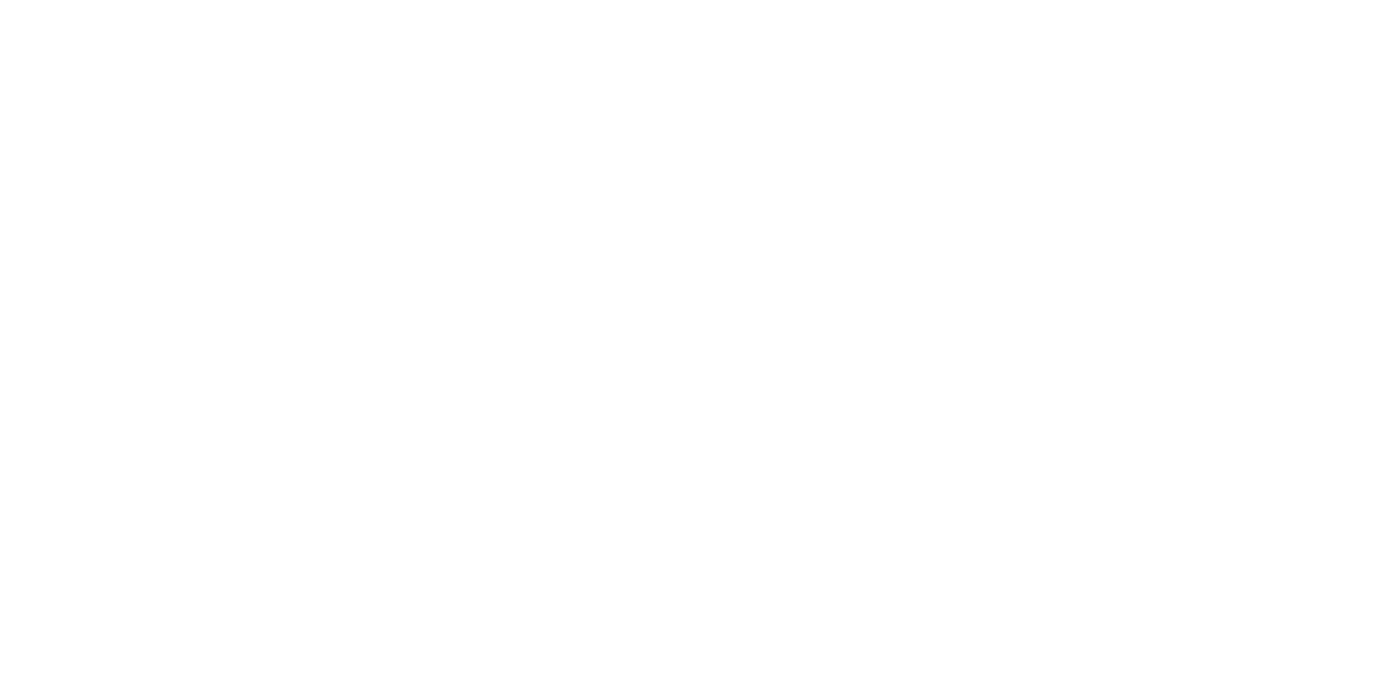

279.77999999997814
255.78
saving file


<IPython.core.display.Javascript object>


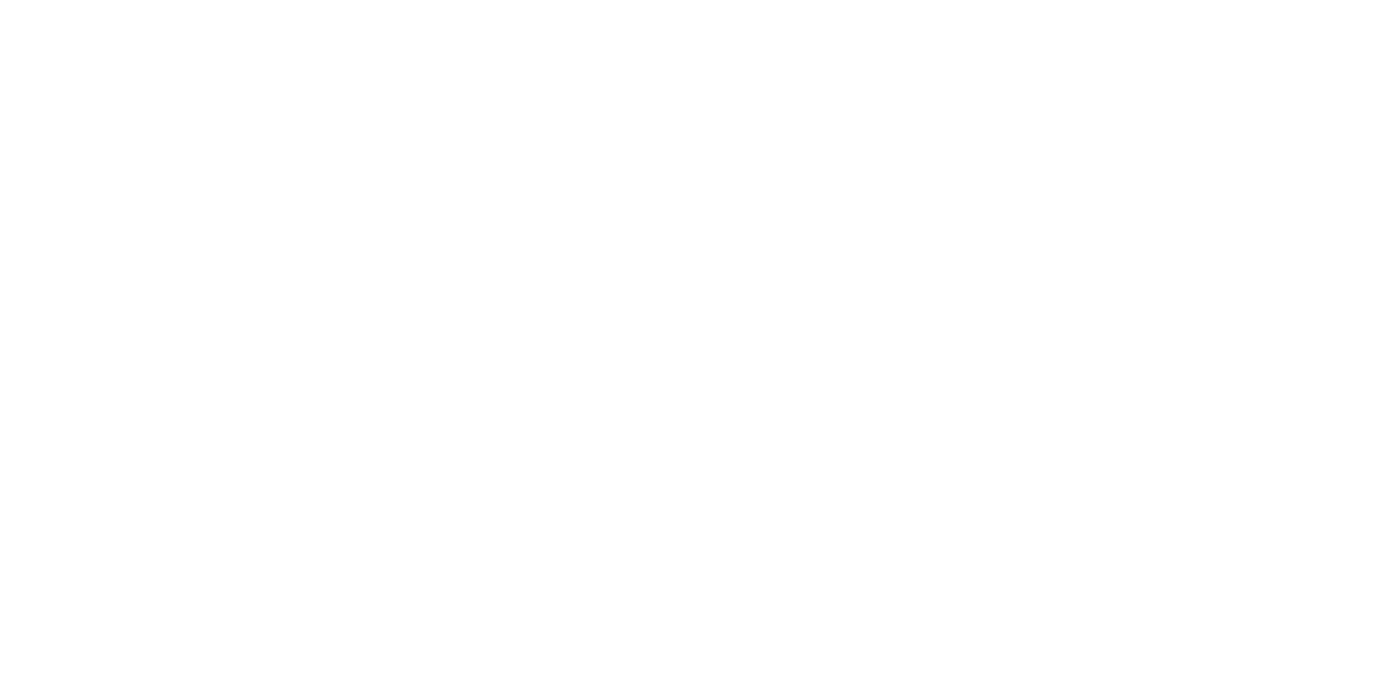

288.59999999997814
264.59999999999997
saving file


<IPython.core.display.Javascript object>


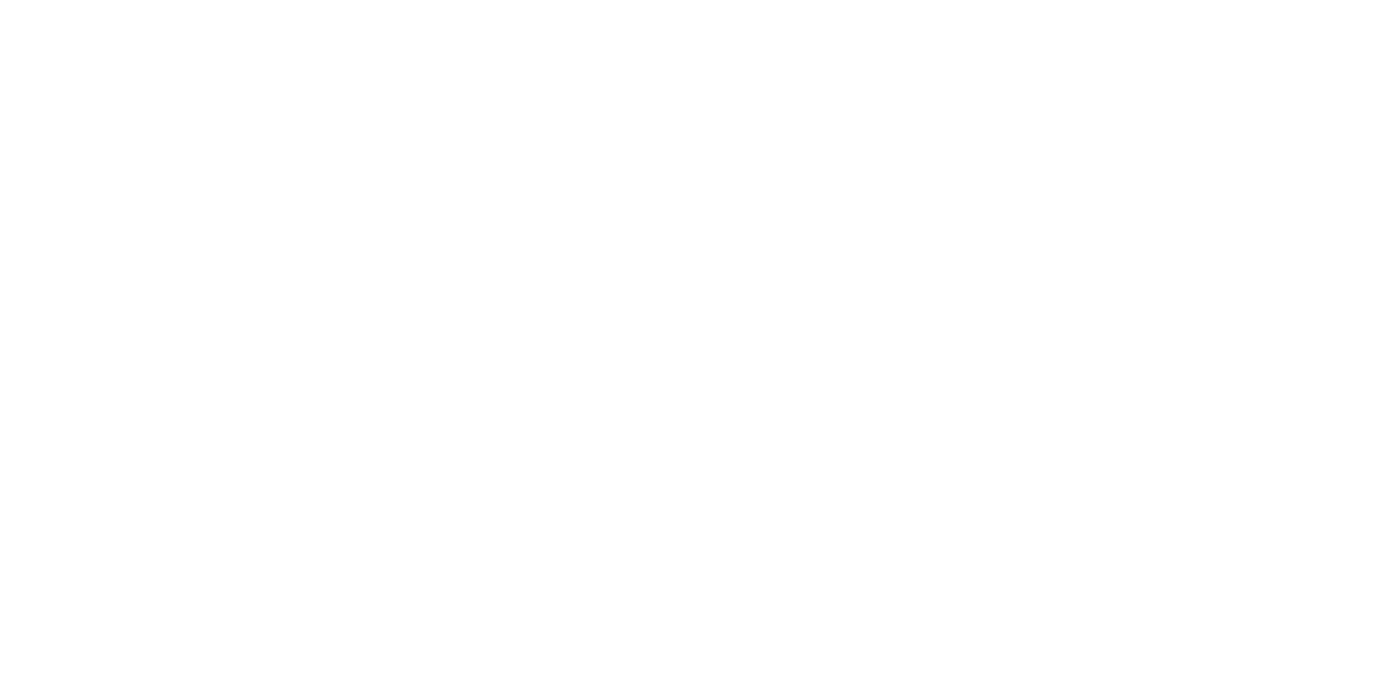

297.4199999999782
273.42
saving file


<IPython.core.display.Javascript object>


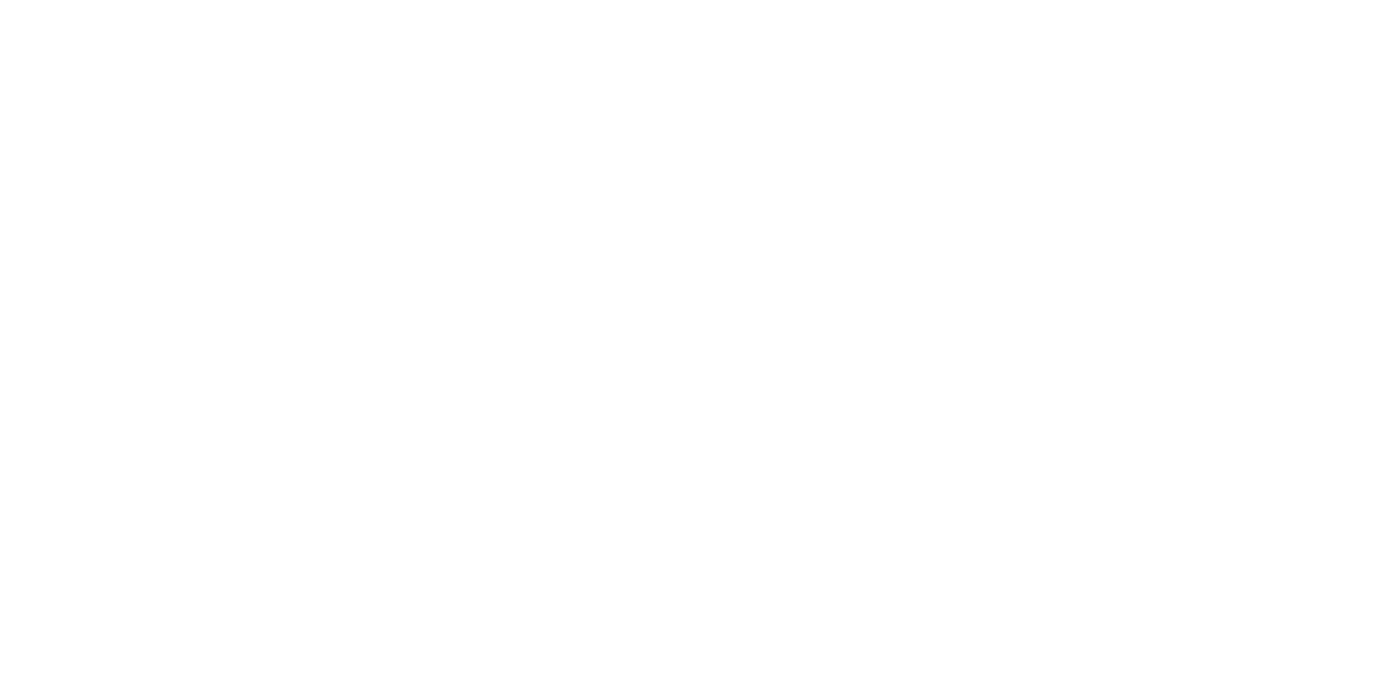

306.2399999999782
282.24
saving file


<IPython.core.display.Javascript object>


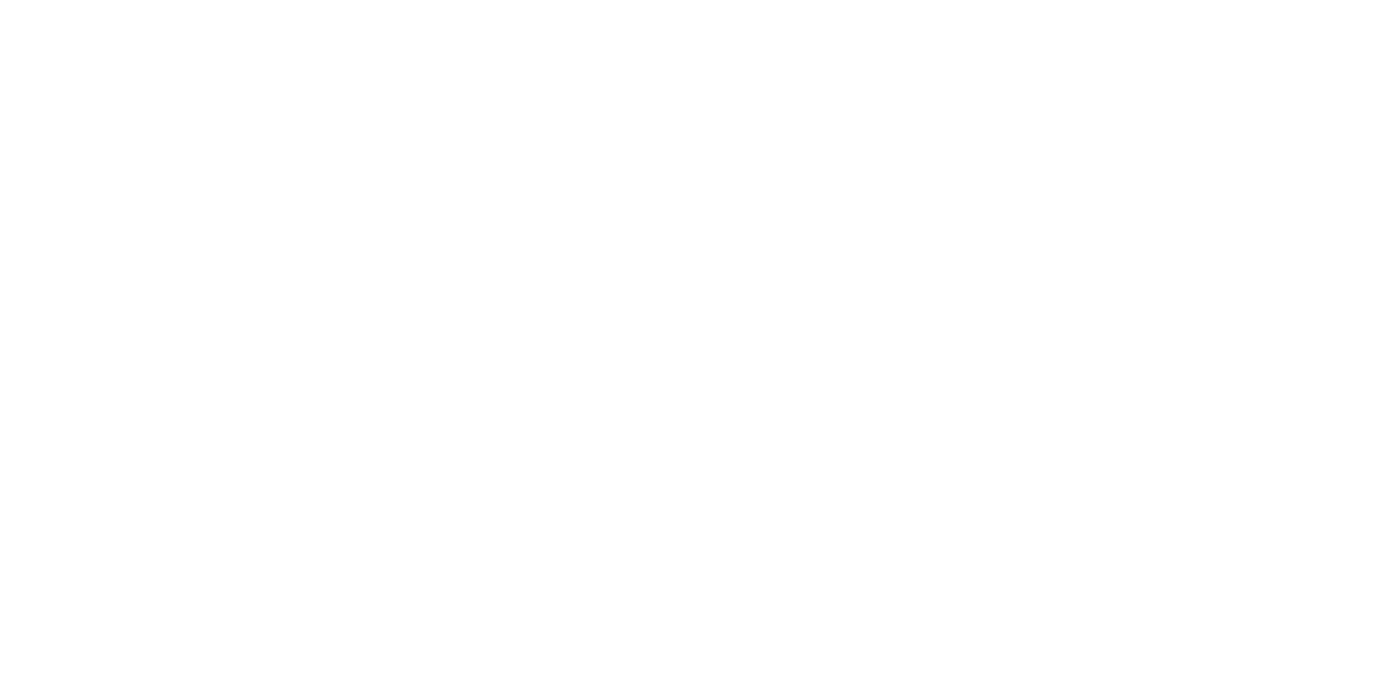

315.0599999999782
291.06
saving file


<IPython.core.display.Javascript object>


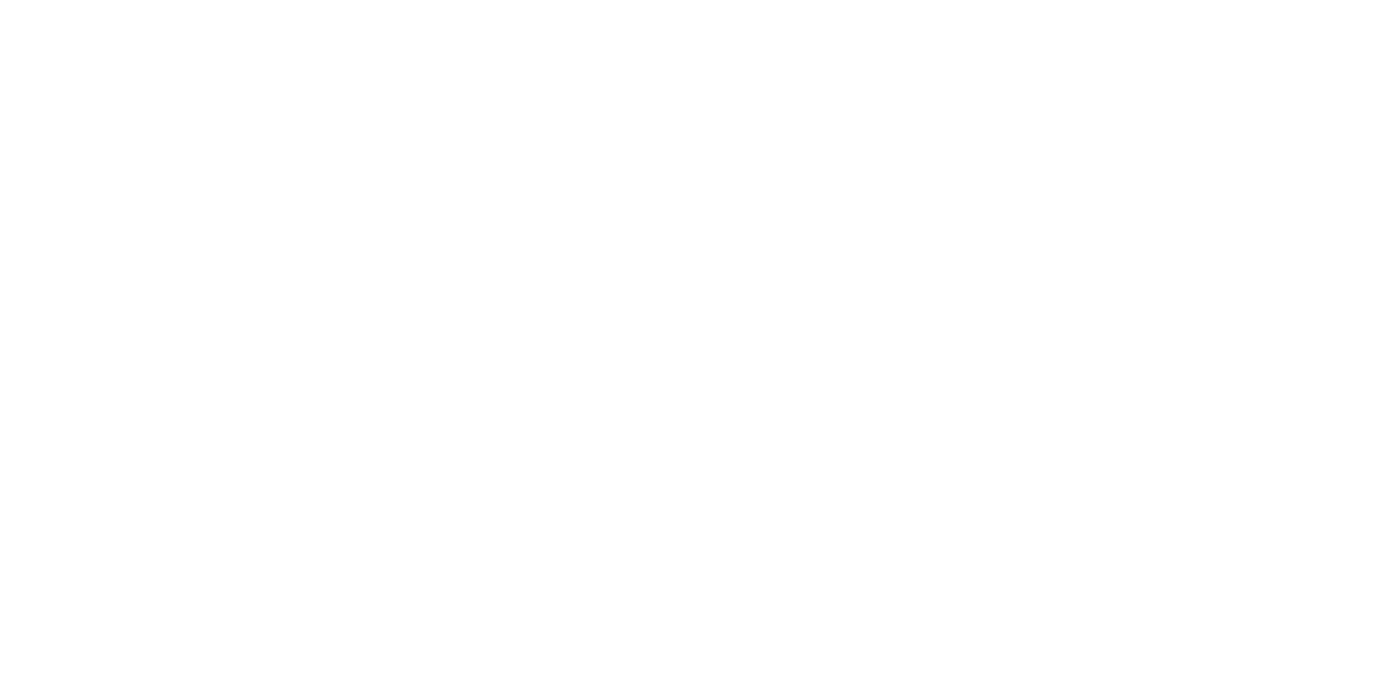

323.87999999997817
299.88
saving file


<IPython.core.display.Javascript object>


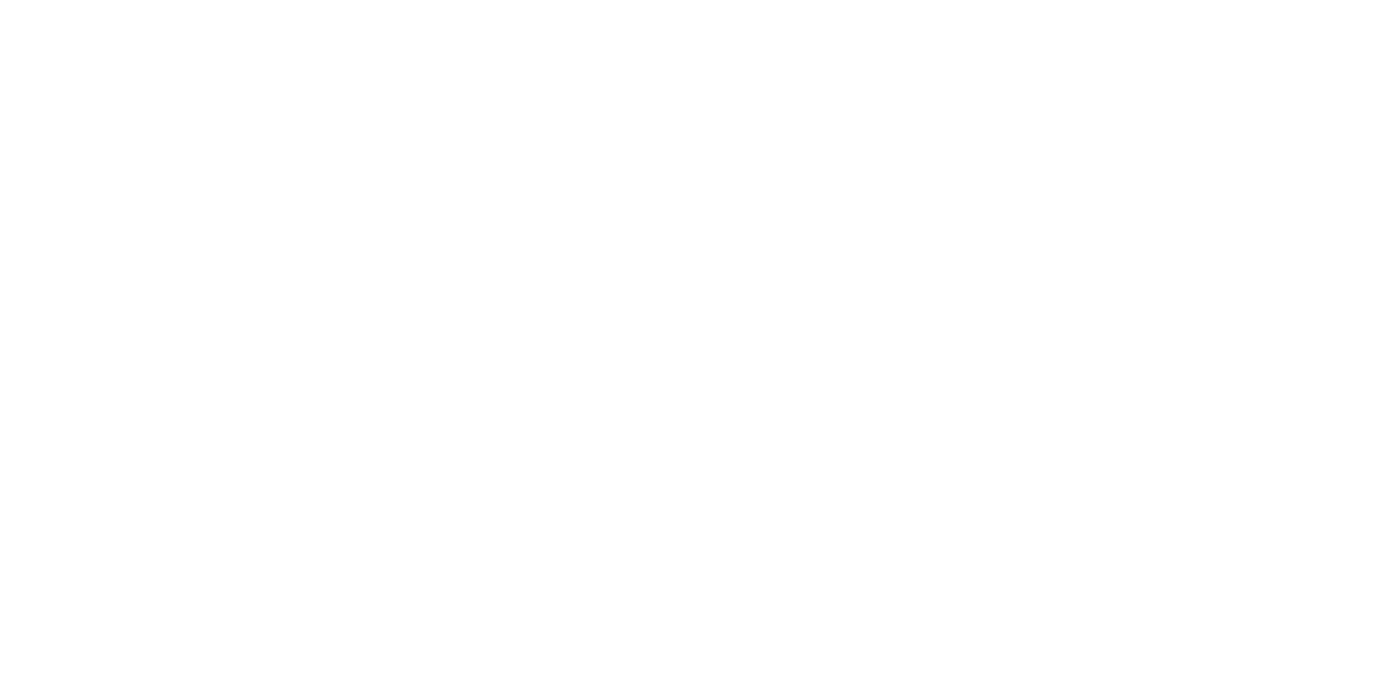

332.69999999997816
308.7
saving file


<IPython.core.display.Javascript object>


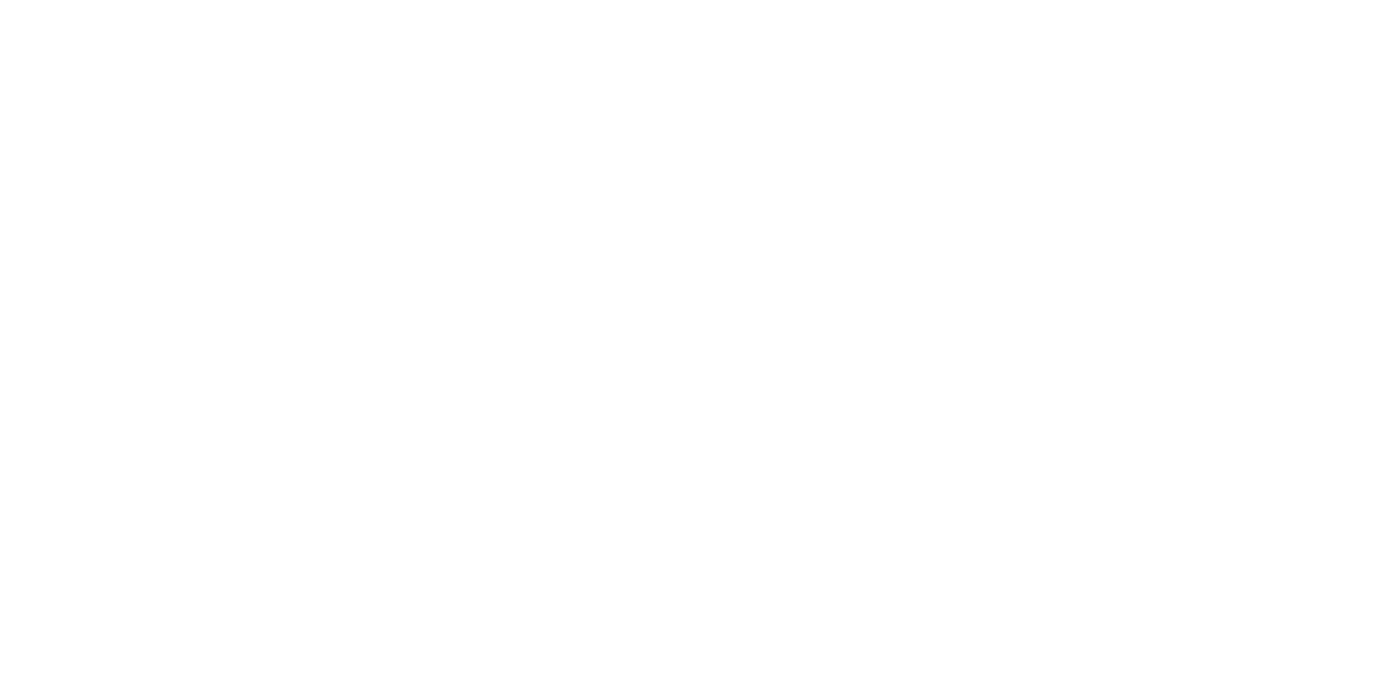

341.51999999997815
317.52
saving file


<IPython.core.display.Javascript object>


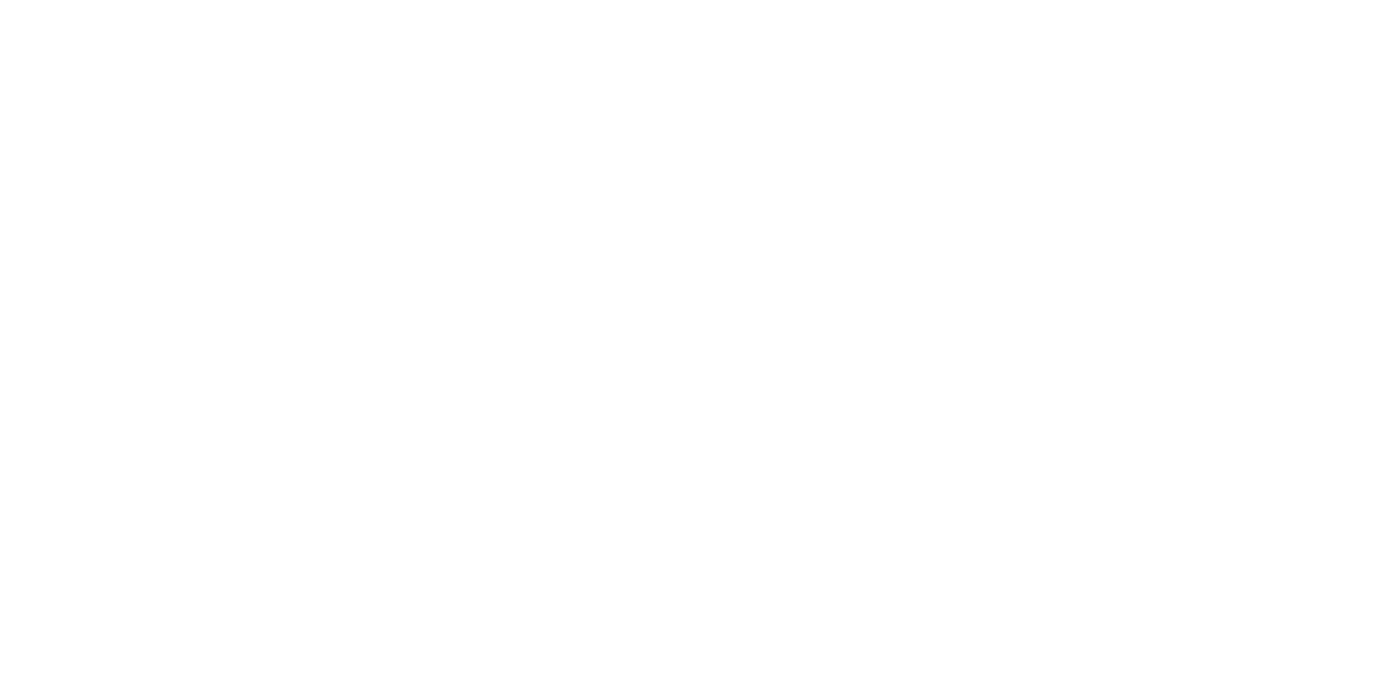

350.33999999997815
326.34
saving file


<IPython.core.display.Javascript object>


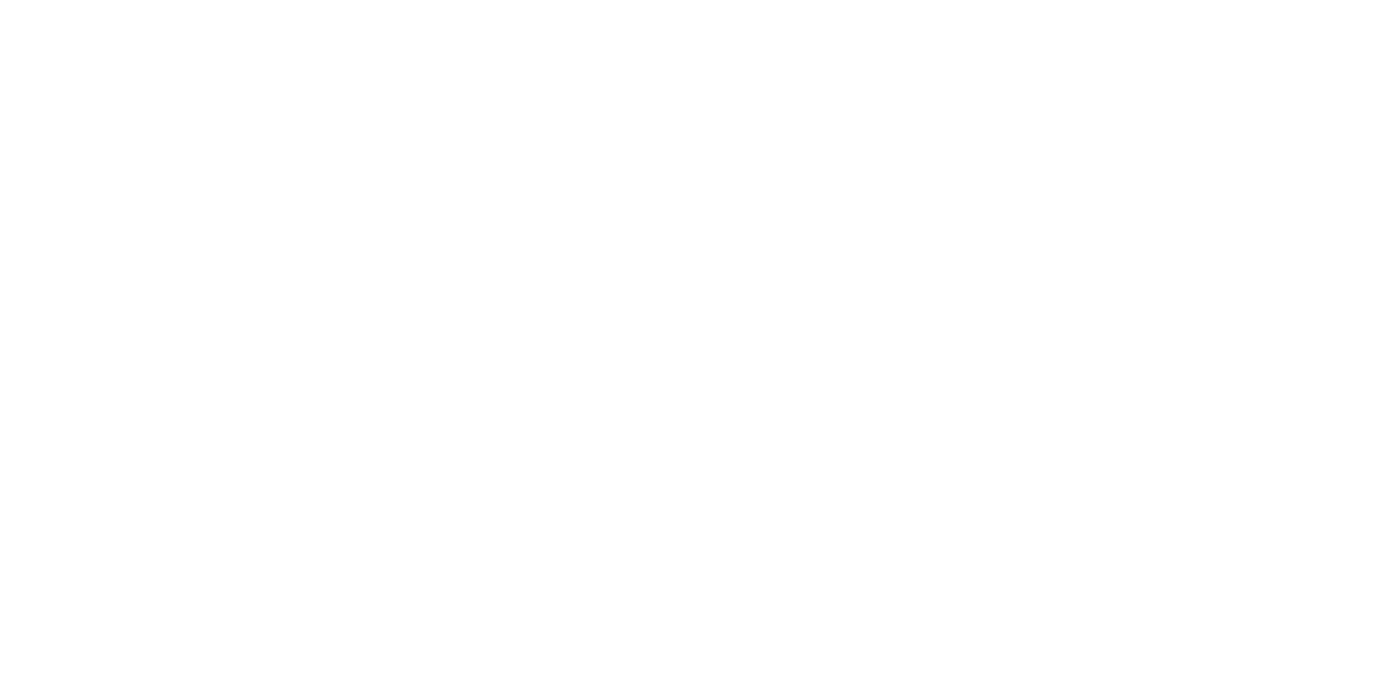

359.15999999997814
335.15999999999997
saving file


<IPython.core.display.Javascript object>


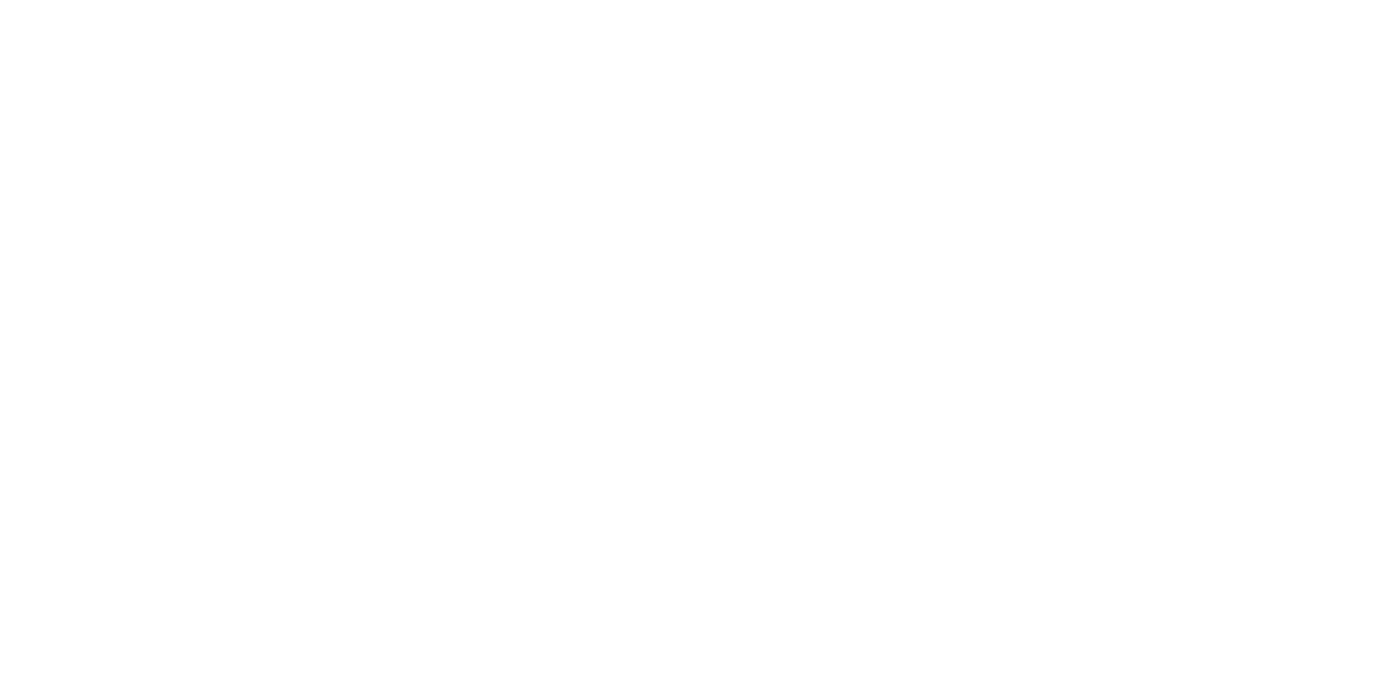

367.97999999997813
343.97999999999996
saving file


<IPython.core.display.Javascript object>


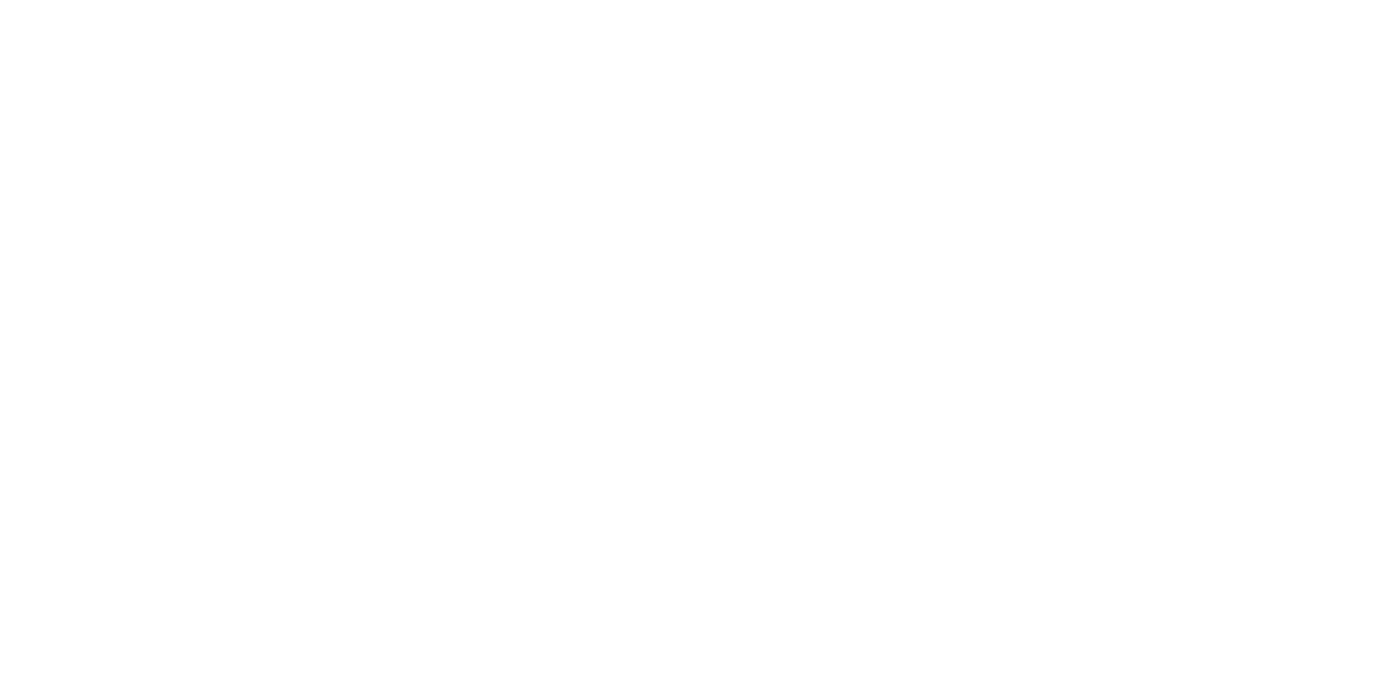

376.7999999999782
352.8
saving file


<IPython.core.display.Javascript object>


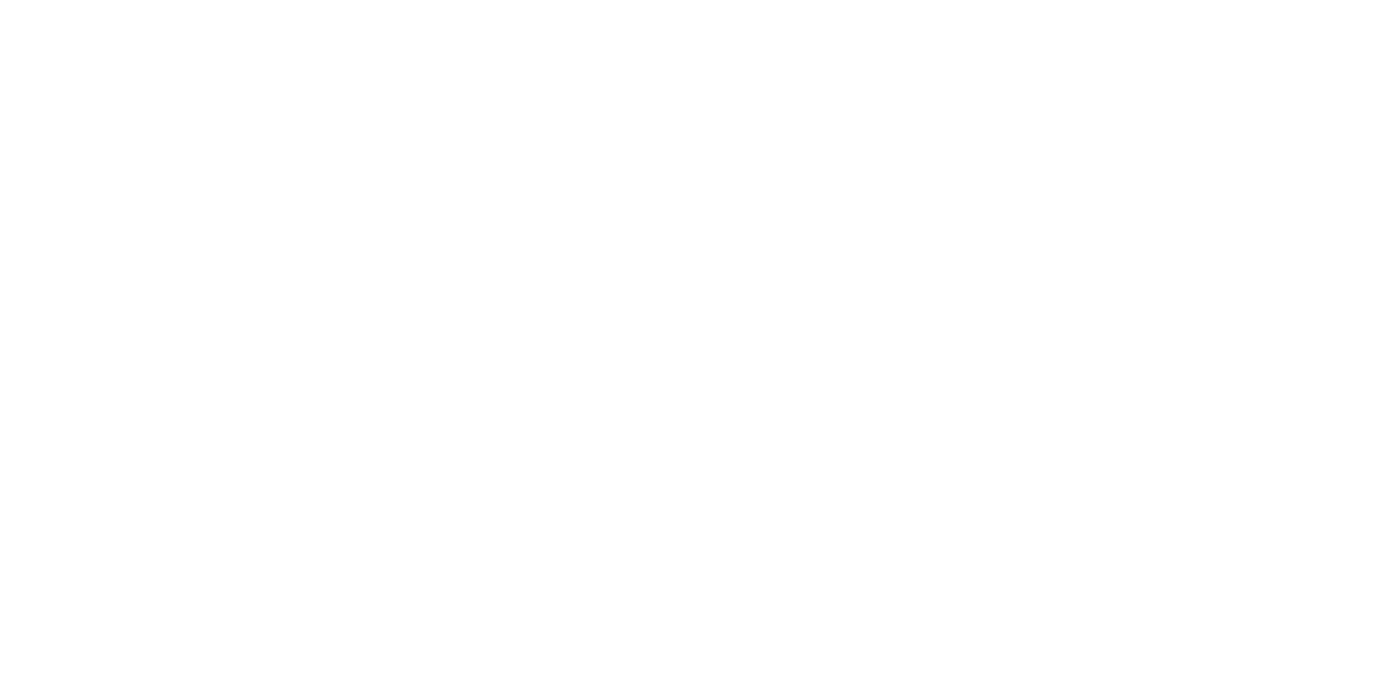

385.6199999999782
361.62
saving file


<IPython.core.display.Javascript object>


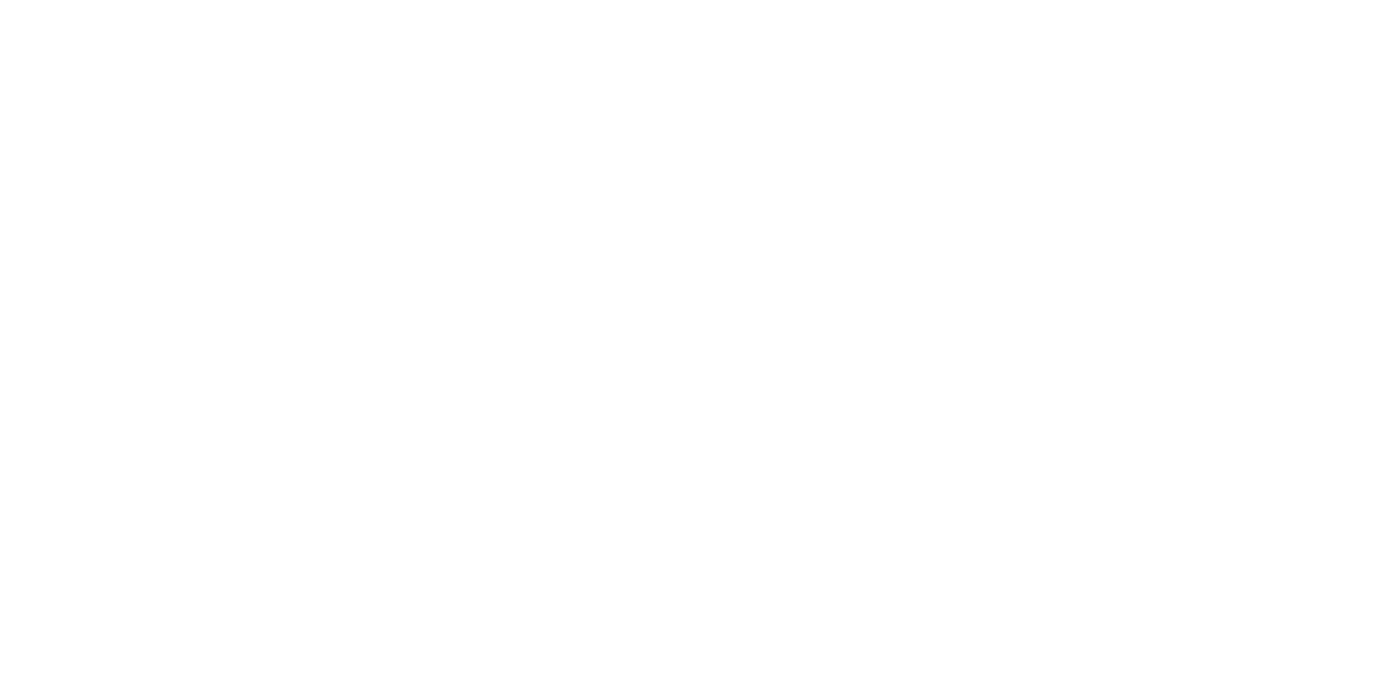

394.43999999997817
370.44
saving file


<IPython.core.display.Javascript object>


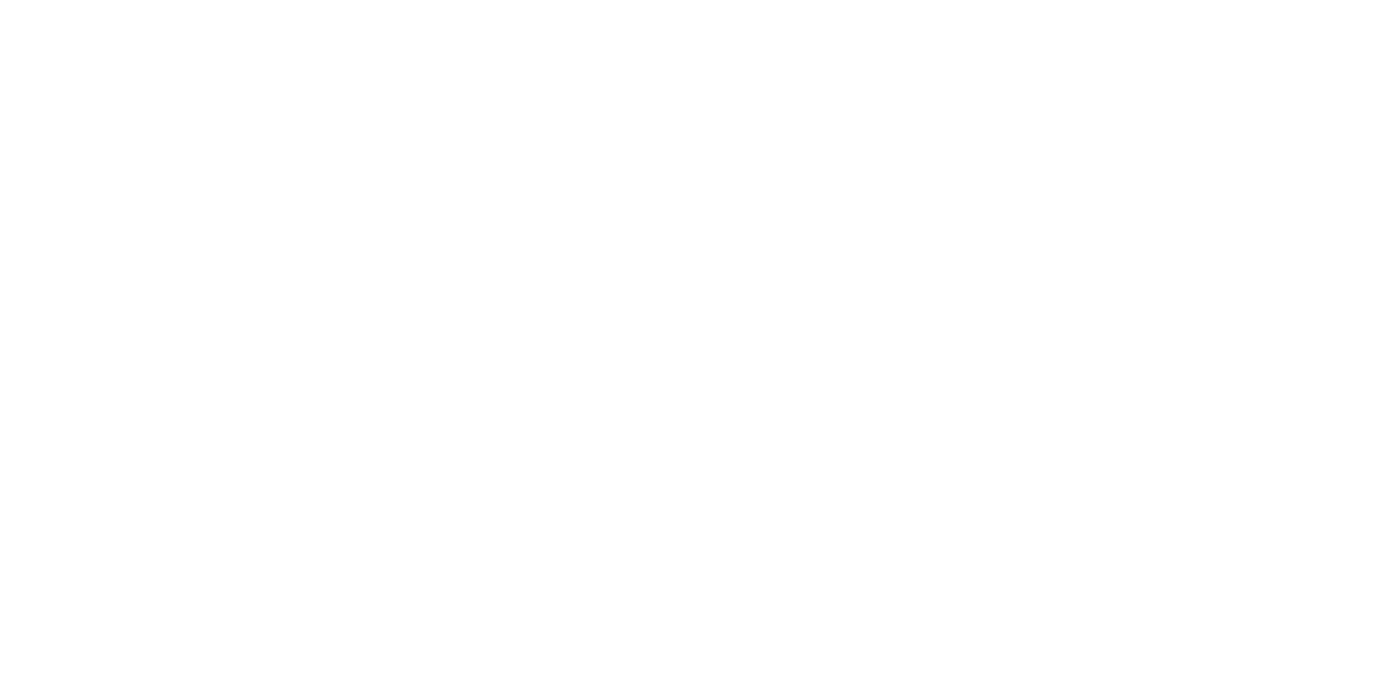

403.25999999997816
379.26
saving file


<IPython.core.display.Javascript object>


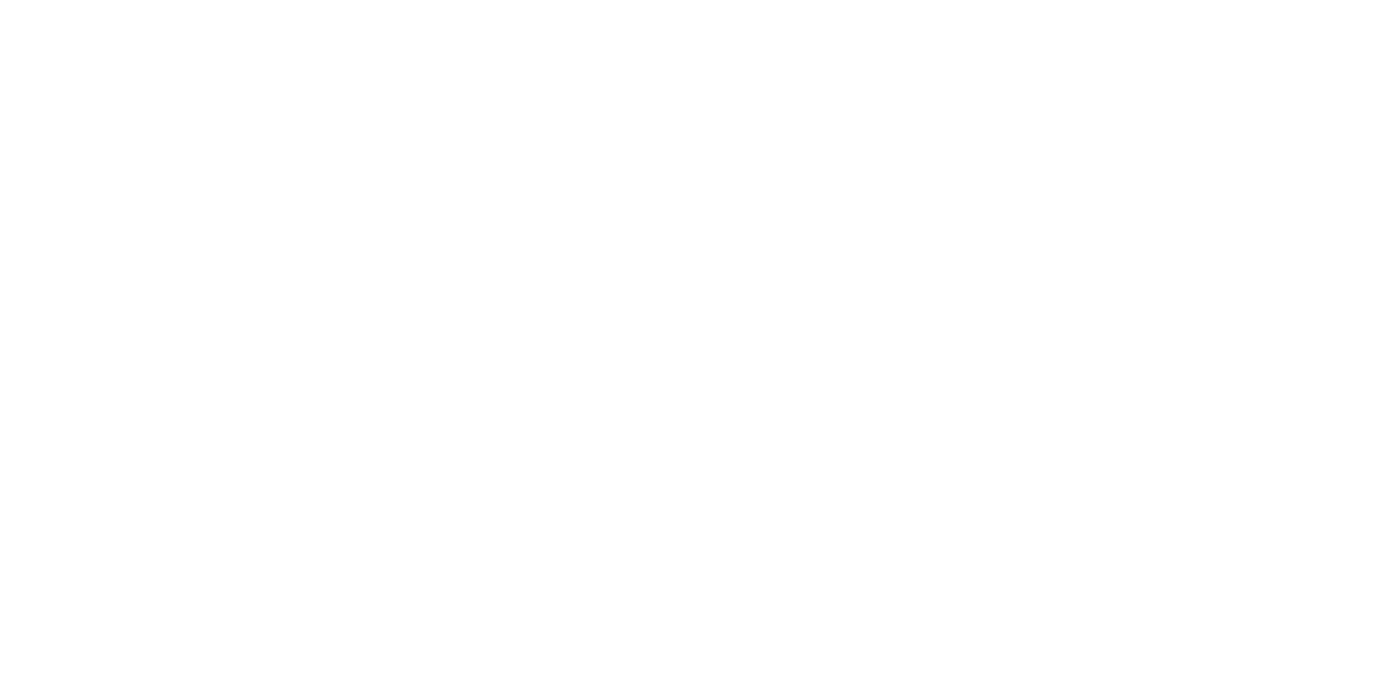

412.07999999997816
388.08
saving file


<IPython.core.display.Javascript object>


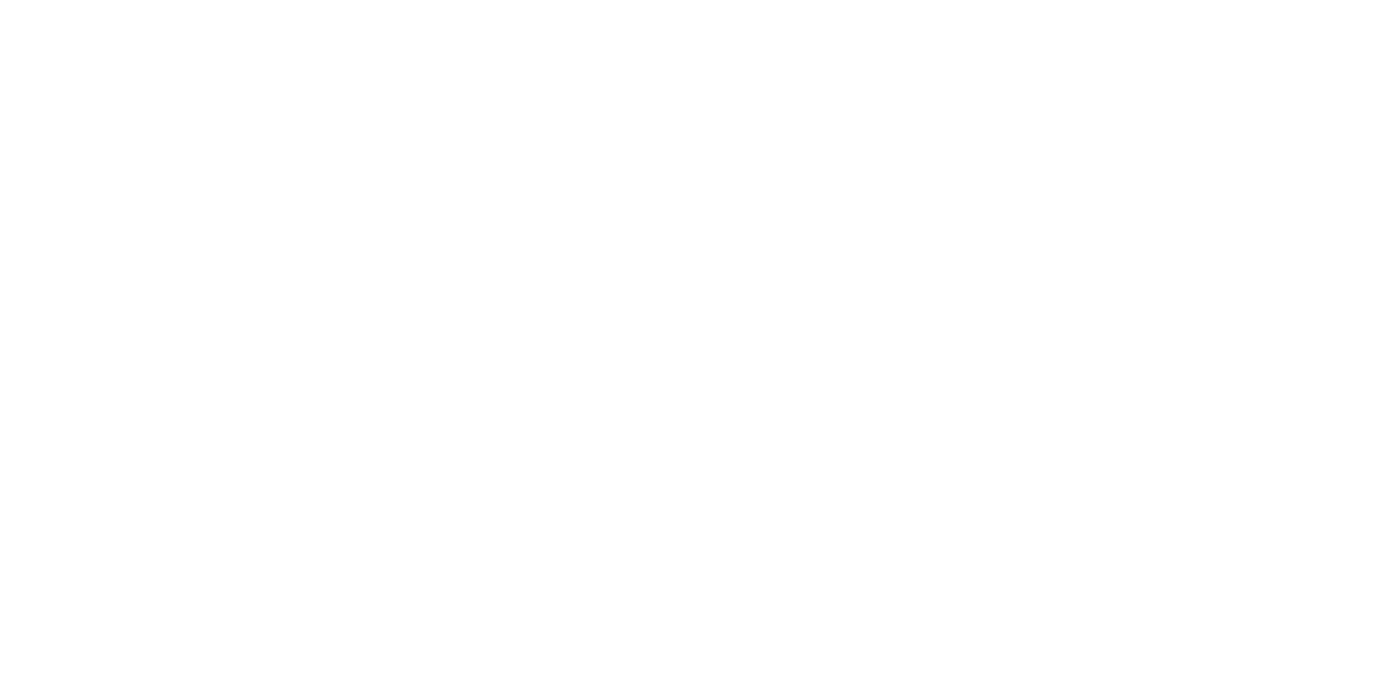

420.89999999997815
396.9
saving file


<IPython.core.display.Javascript object>


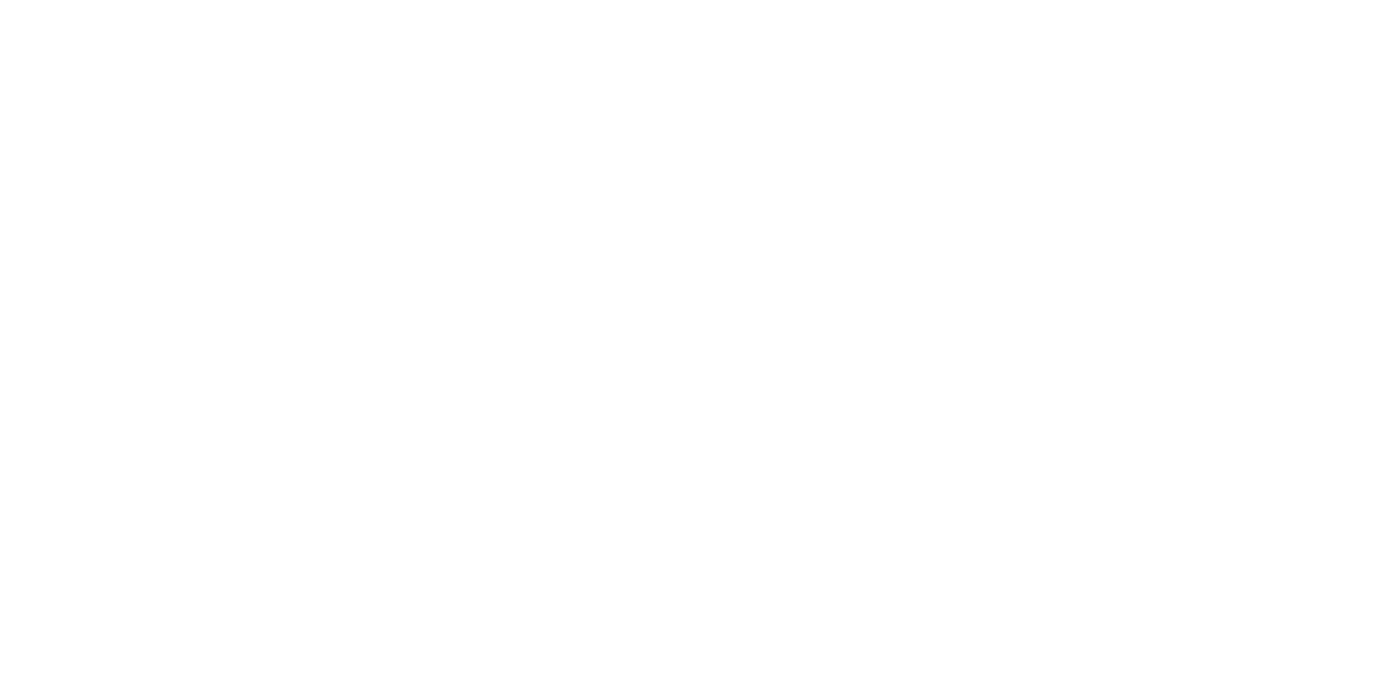

429.71999999997814
405.71999999999997
saving file


<IPython.core.display.Javascript object>


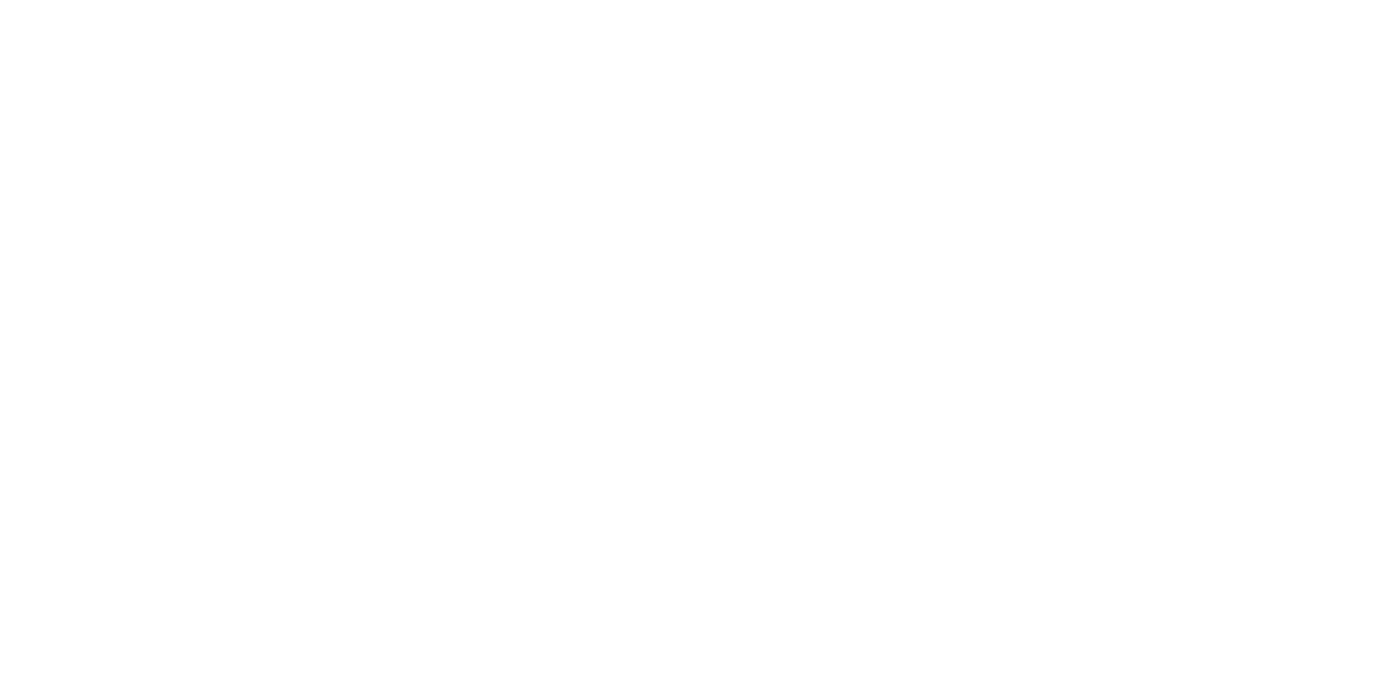

438.53999999997814
414.53999999999996
saving file


<IPython.core.display.Javascript object>


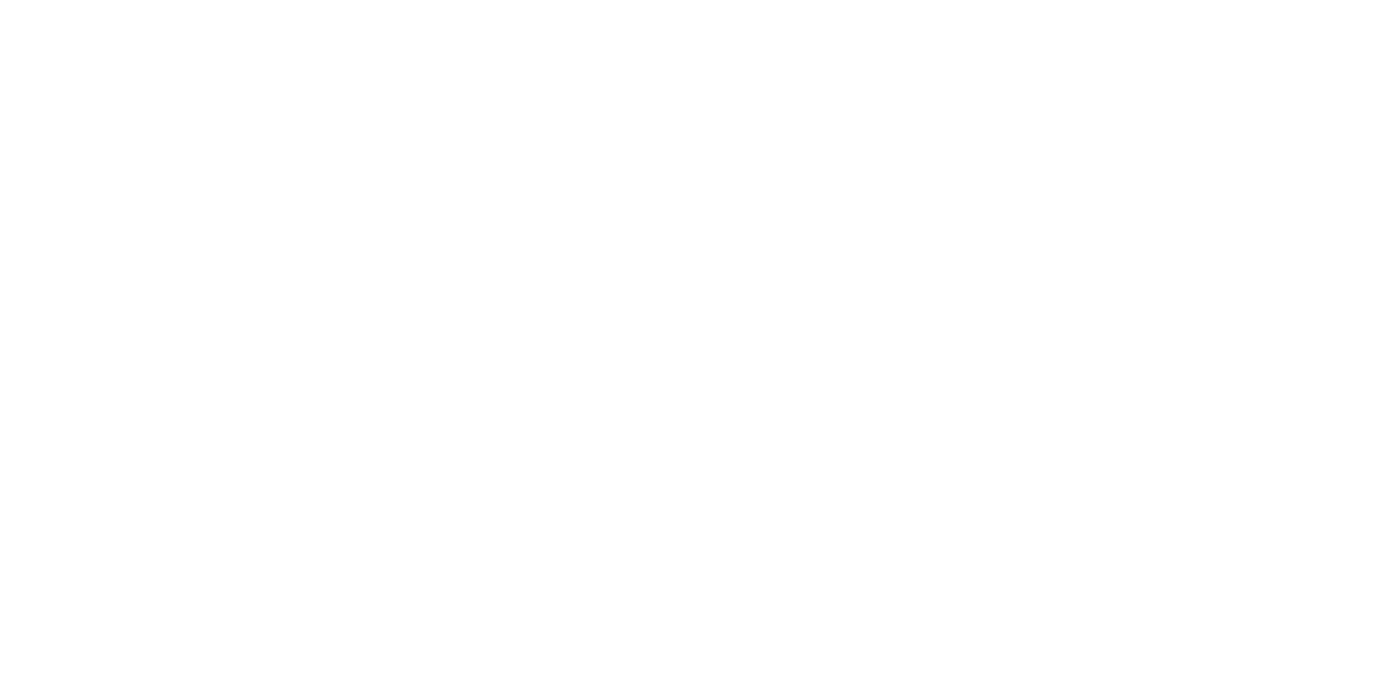

447.35999999997813
423.35999999999996
saving file


<IPython.core.display.Javascript object>


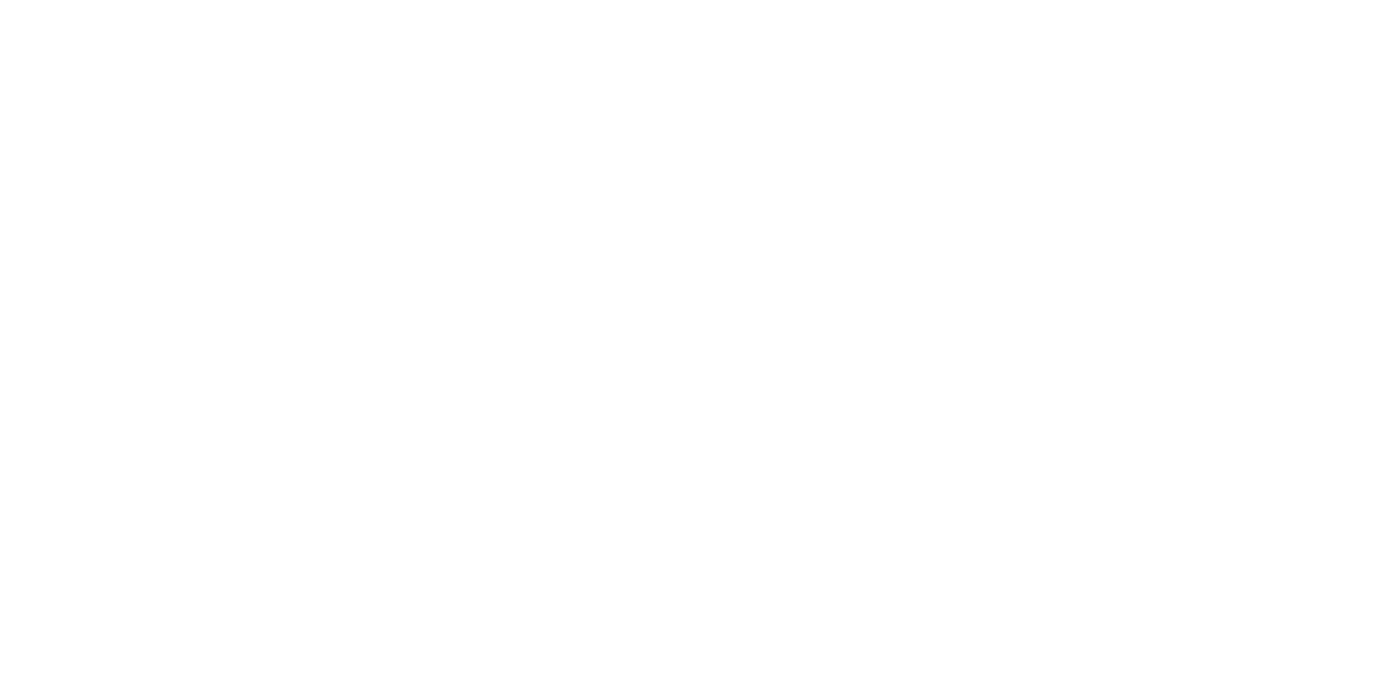

456.1799999999782
432.18
saving file


<IPython.core.display.Javascript object>


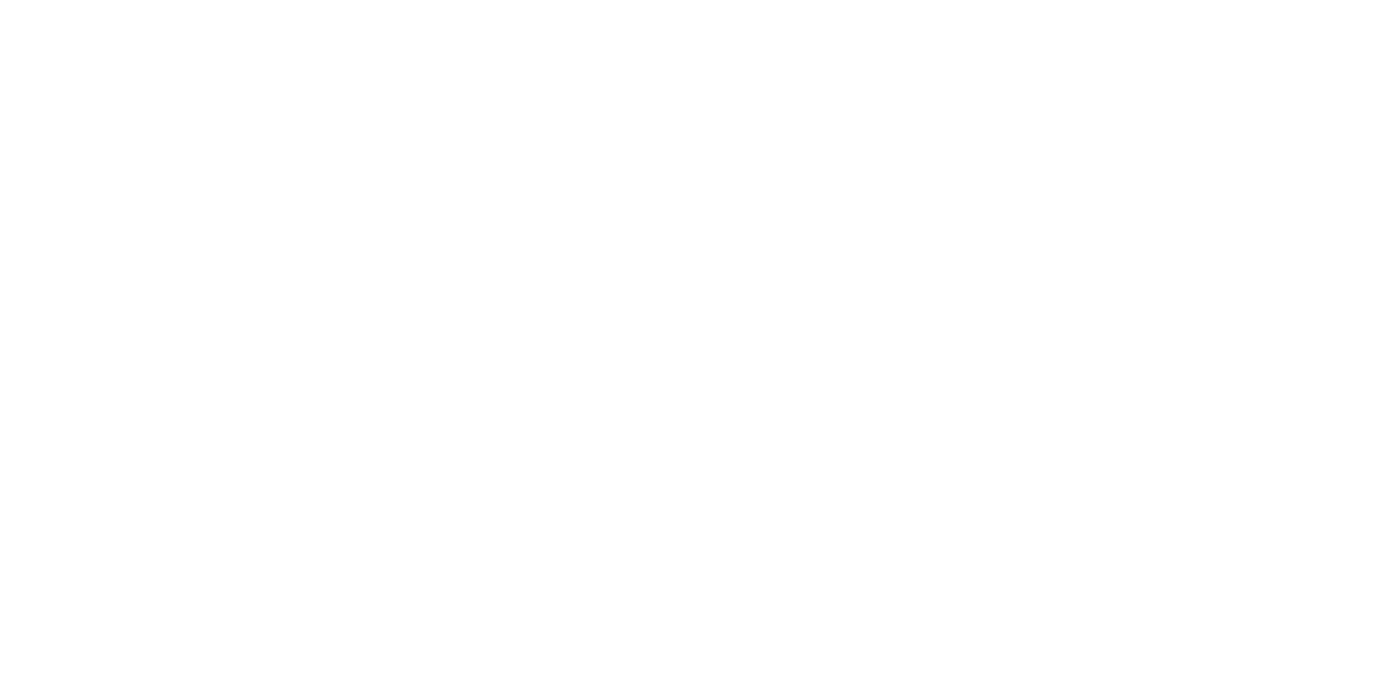

464.9999999999782
441.0
saving file


<IPython.core.display.Javascript object>


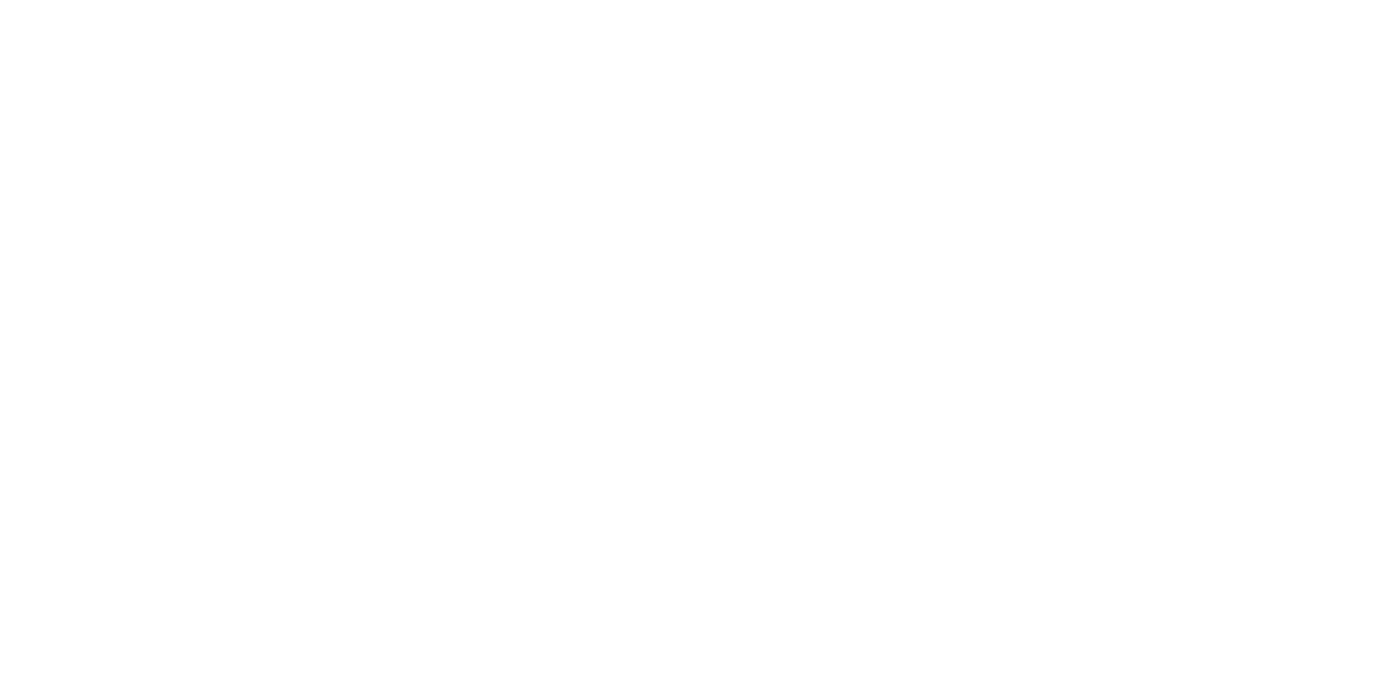

473.81999999997817
449.82
saving file


<IPython.core.display.Javascript object>


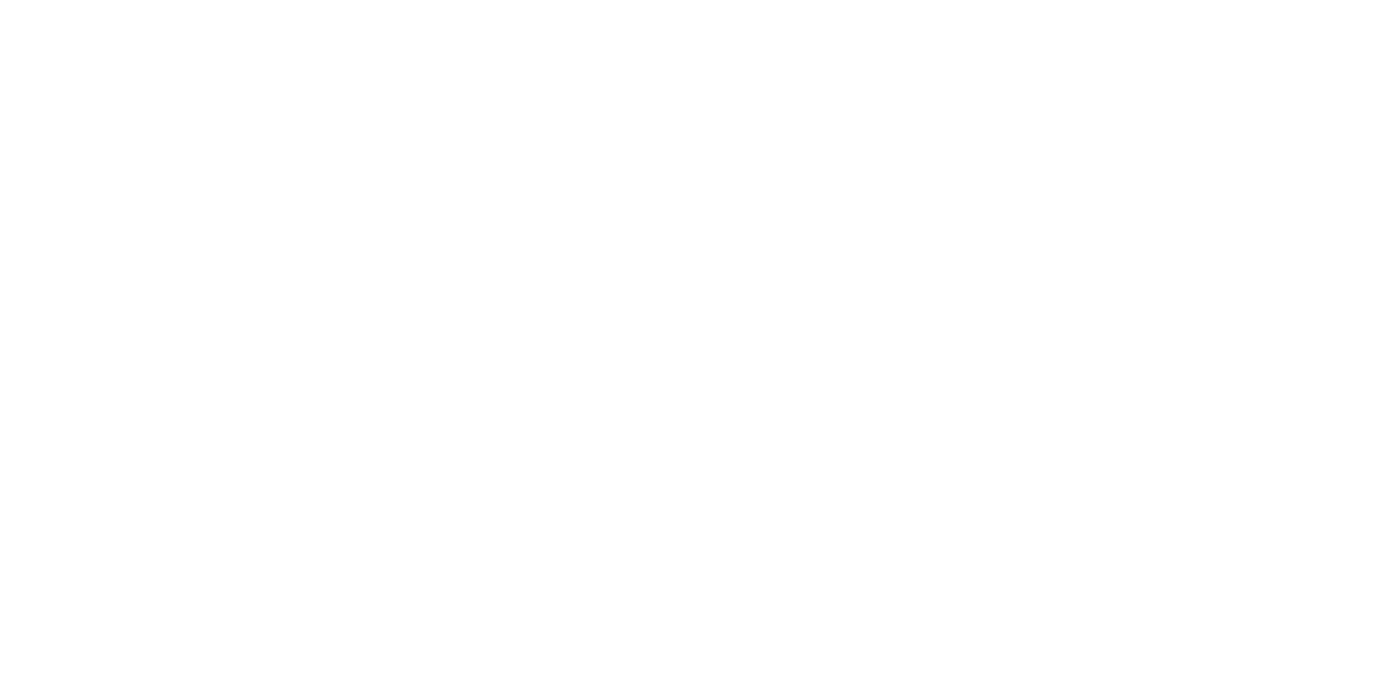

482.63999999997816
458.64
saving file


<IPython.core.display.Javascript object>


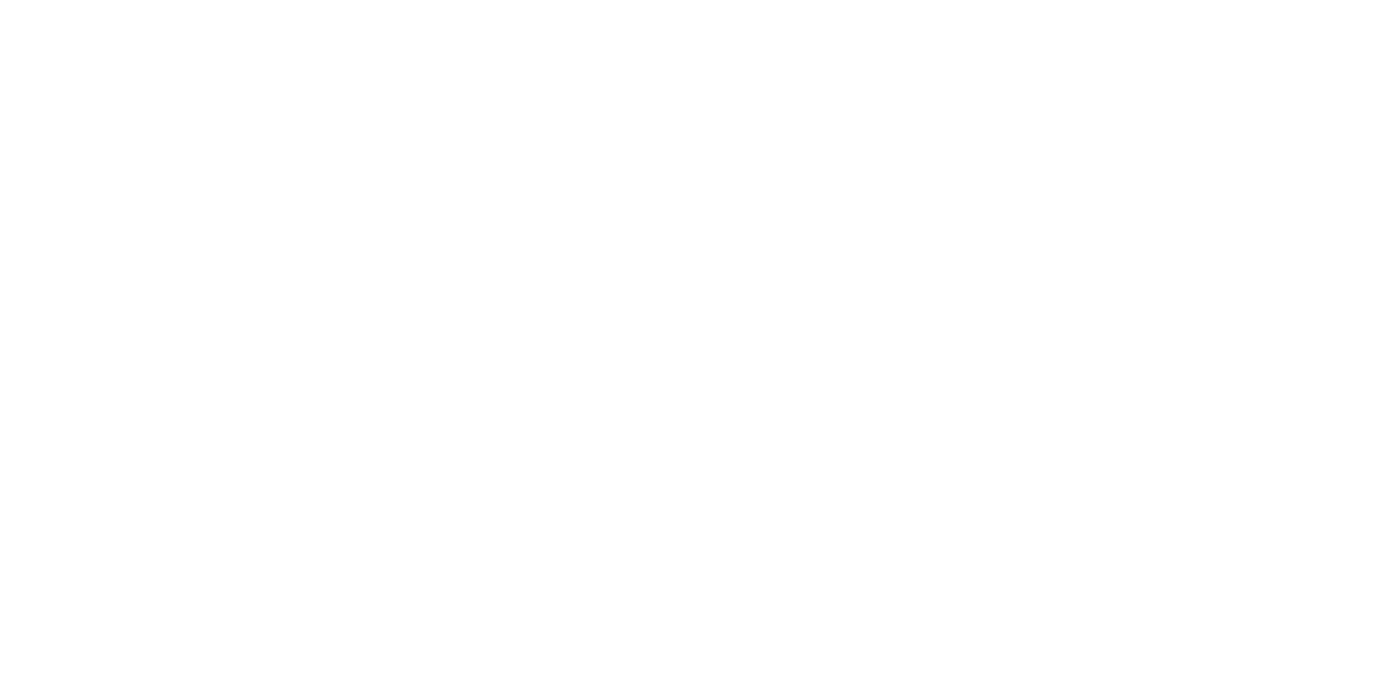

491.45999999997815
467.46
saving file


<IPython.core.display.Javascript object>


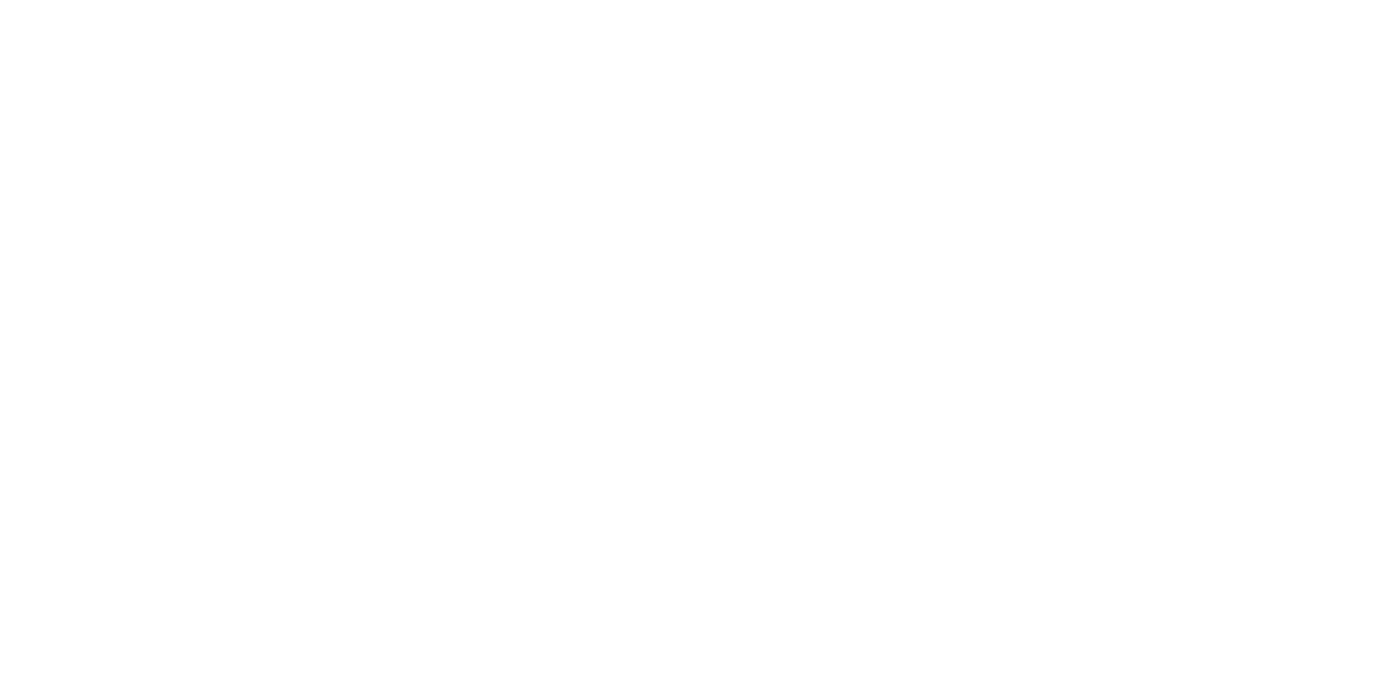

500.27999999997814
476.28
saving file


<IPython.core.display.Javascript object>


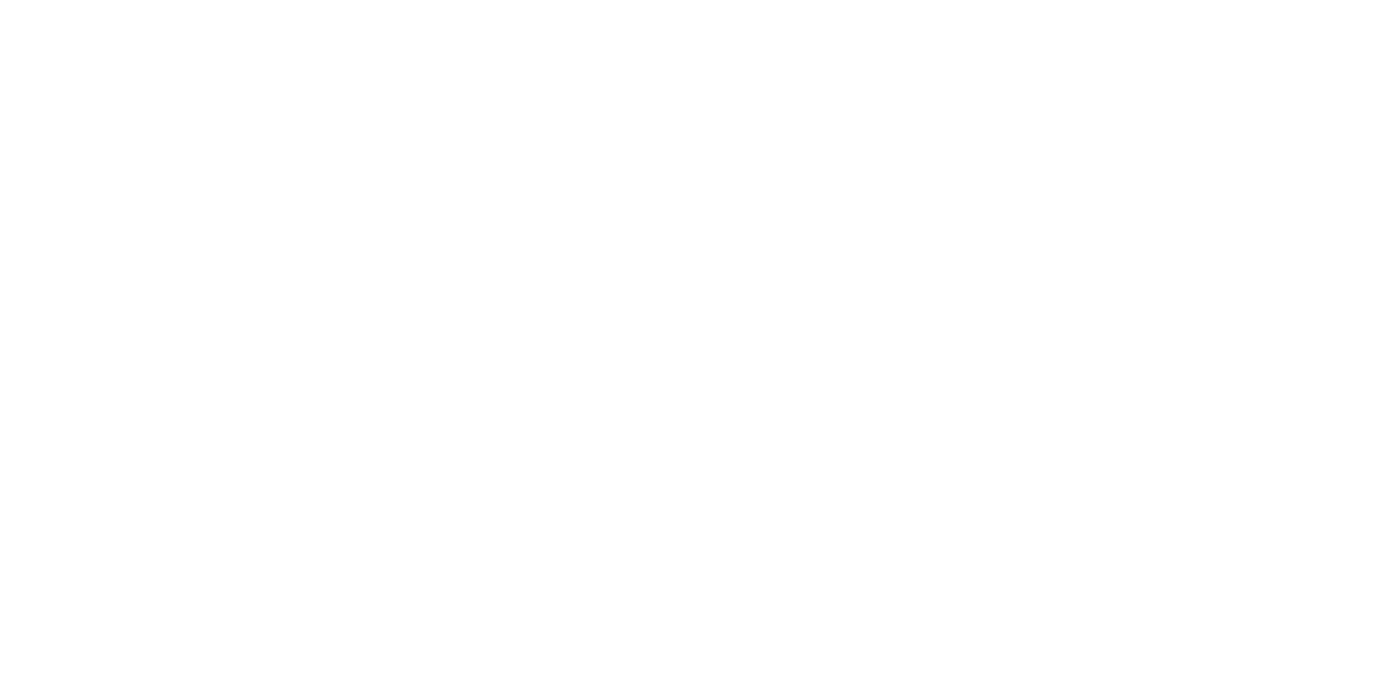

509.09999999997814
485.09999999999997
saving file


<IPython.core.display.Javascript object>


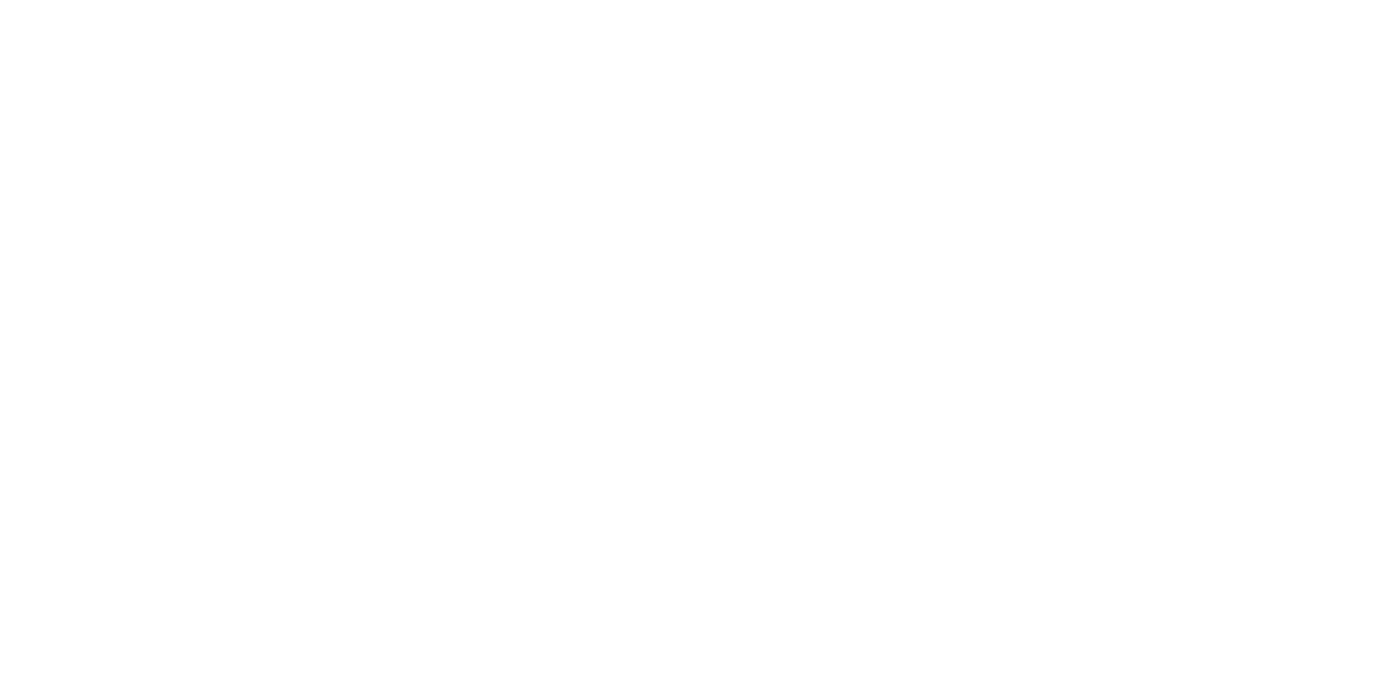

517.9199999999781
493.91999999999996
saving file


<IPython.core.display.Javascript object>


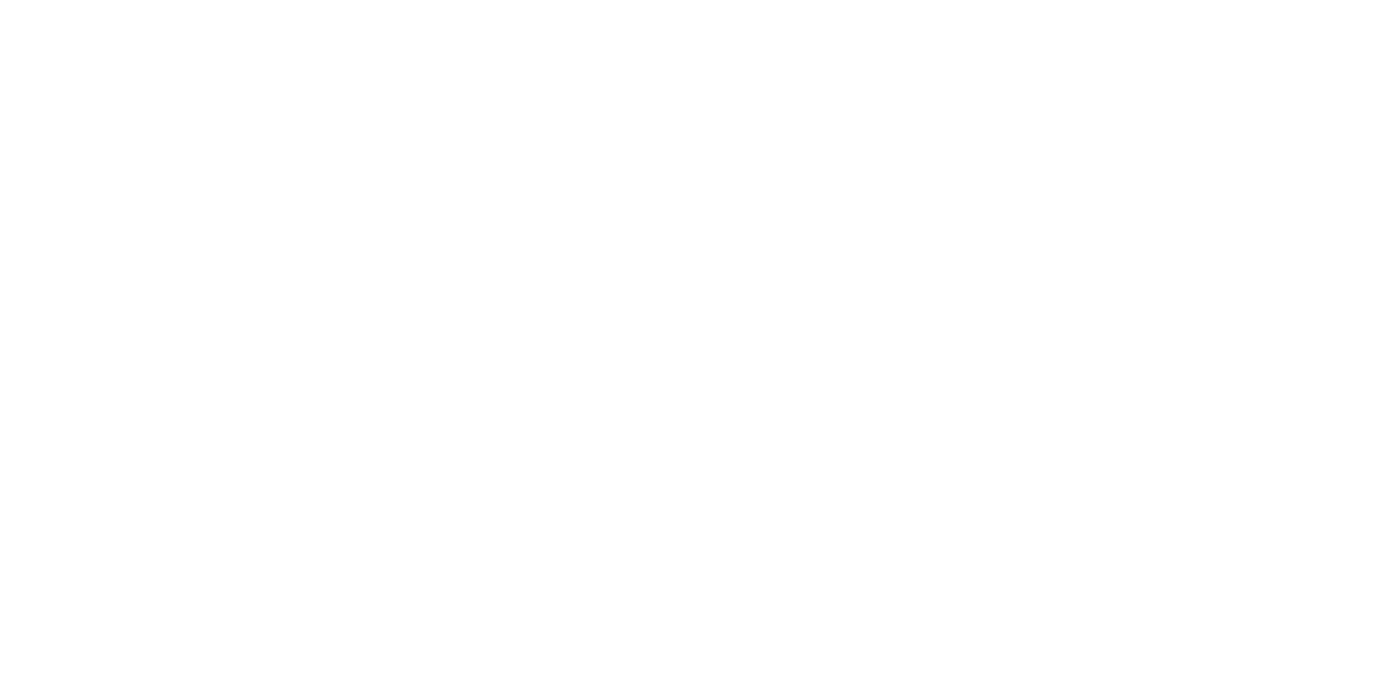

526.7399999999782
502.74
saving file


<IPython.core.display.Javascript object>


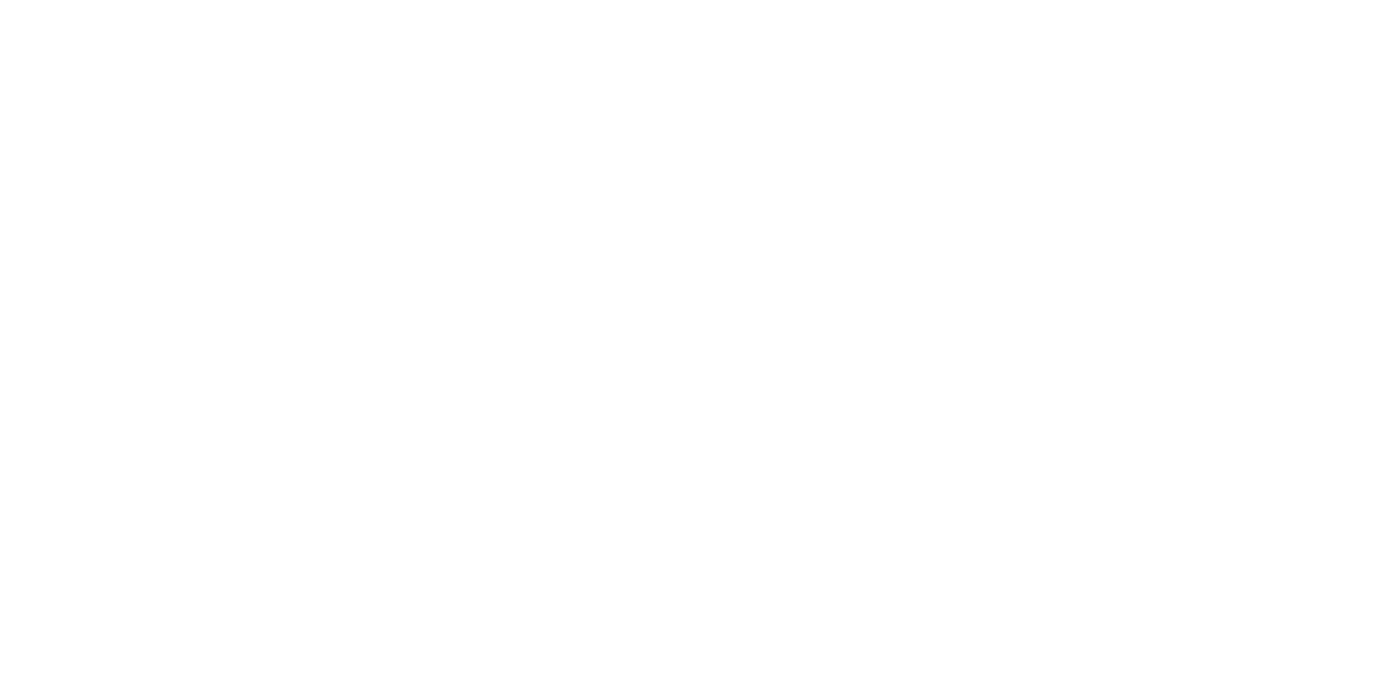

535.5599999999783
511.56
saving file


<IPython.core.display.Javascript object>


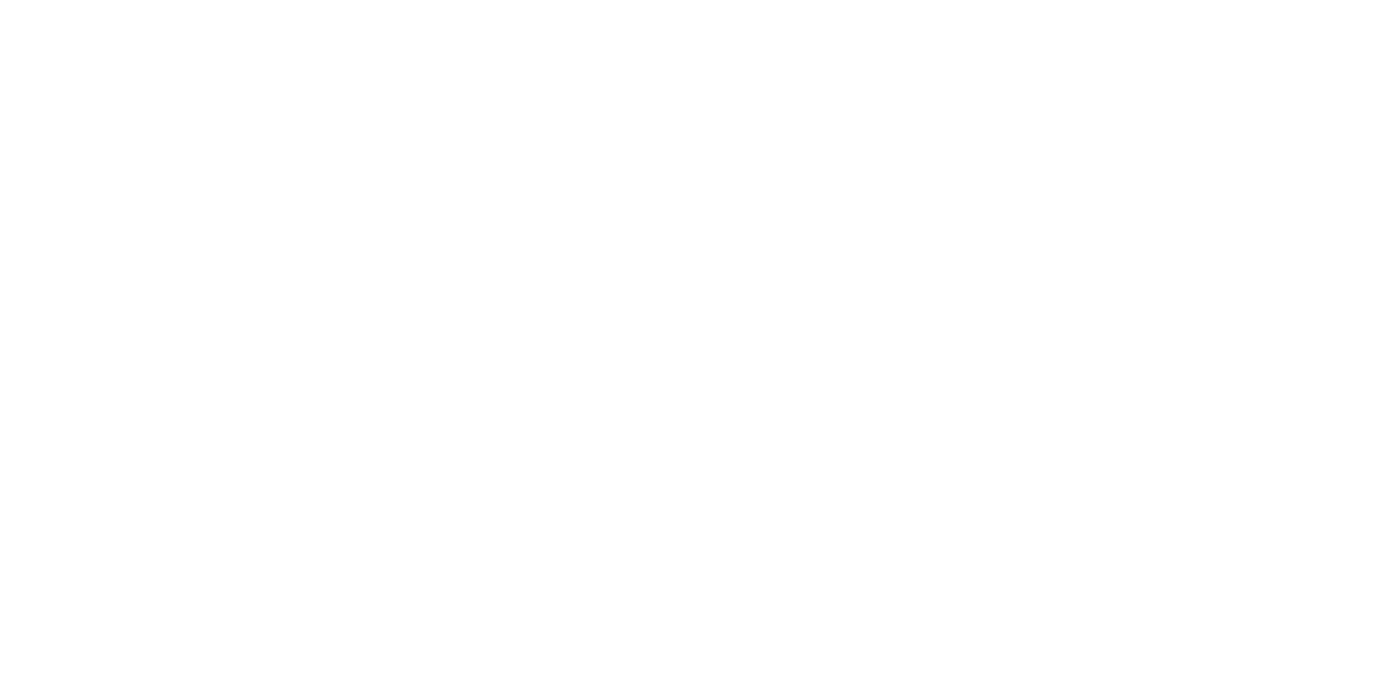

544.3799999999782
520.38
saving file


<IPython.core.display.Javascript object>


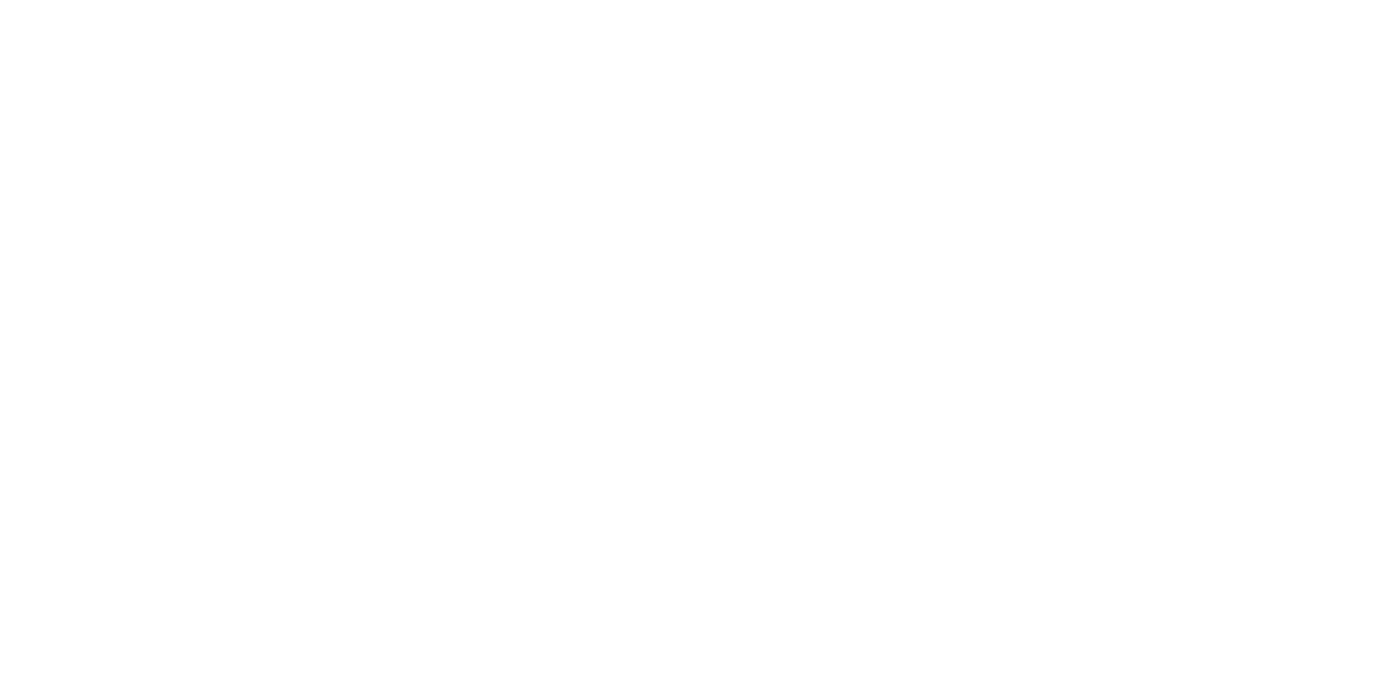

553.1999999999781
529.1999999999999
saving file


<IPython.core.display.Javascript object>


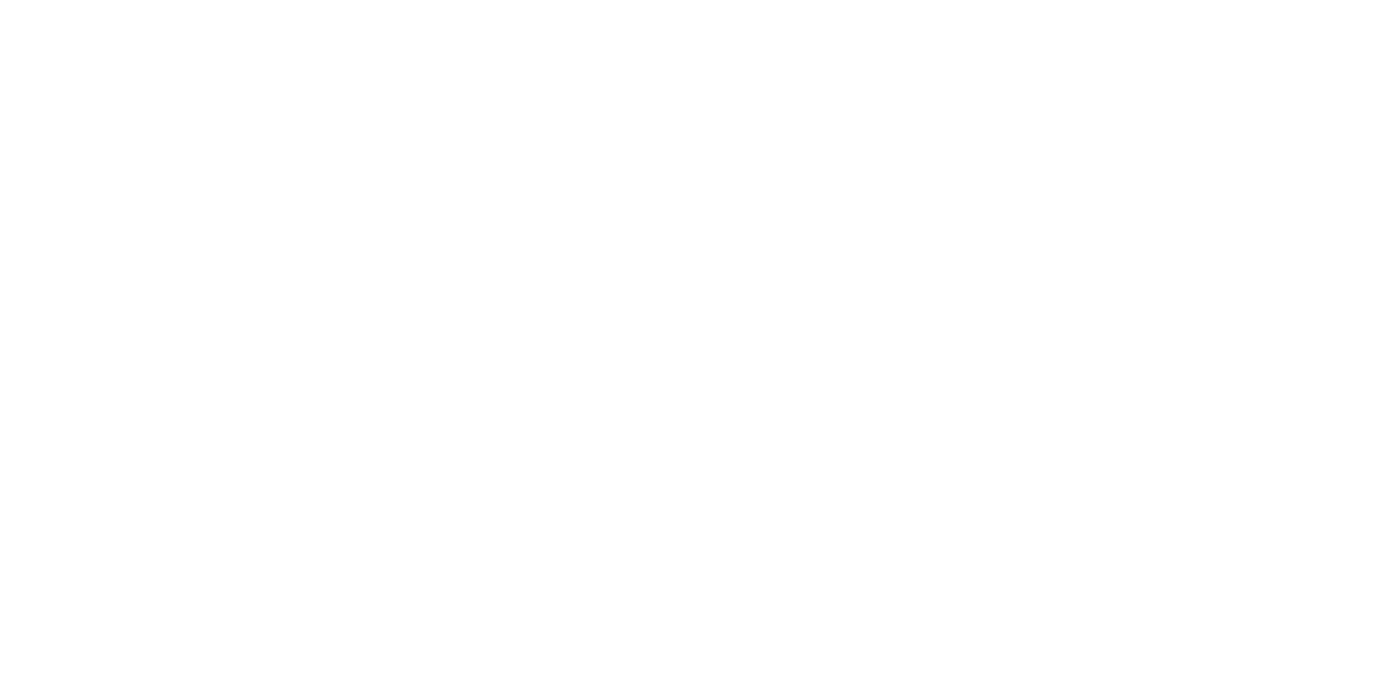

562.0199999999782
538.02
saving file


<IPython.core.display.Javascript object>


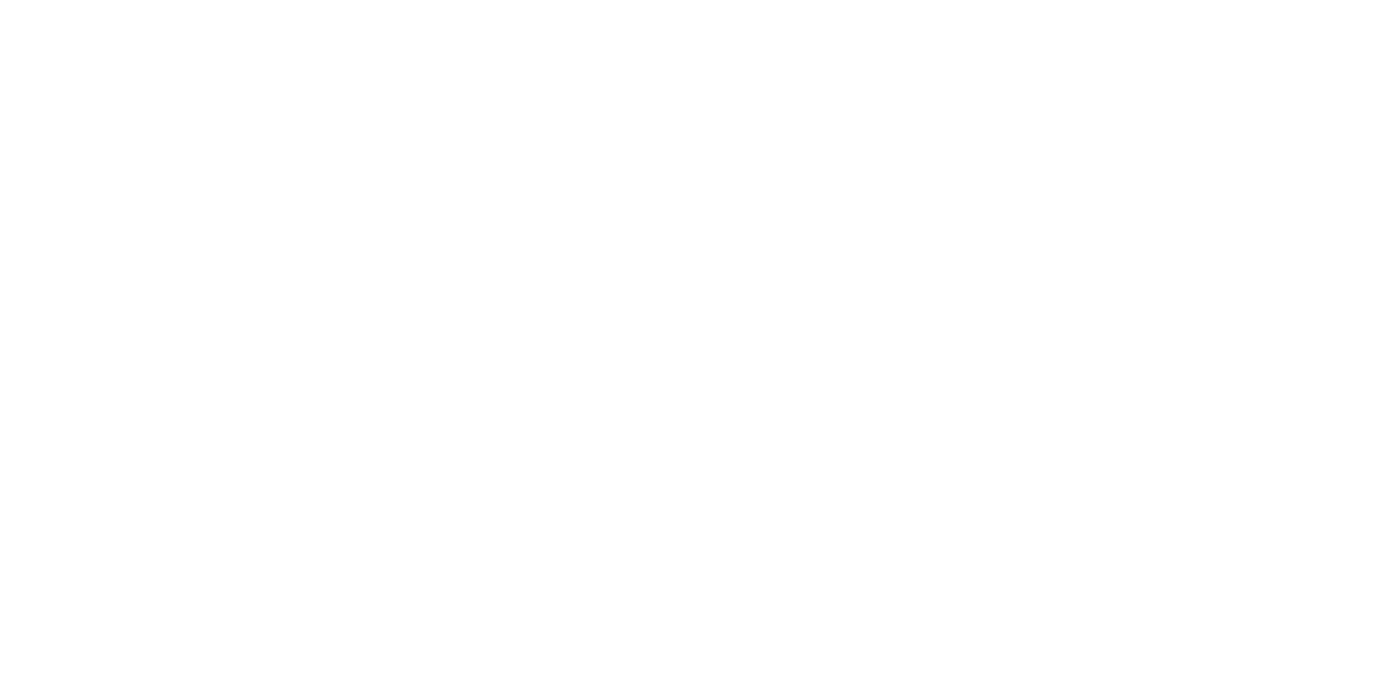

570.8399999999782
546.84
saving file


In [36]:
# Here we used the basic functions defined above, and make a loop to produce movies.  In this case, turn off the display 
# to allow the program to quietly write the images to the disk.
#

for i in range(0,18700,300):
    laser_basic_ver4(dirname+'/MS/',i,show=False)

## Case 2:  Nonlinear ($v_{osc}/c= 1$, $\omega_0/\omega_p = 10$)

In [47]:
## Hit <shift>+<return> to run

dirname = 'nonlinear-a10-w10'
osiris.runosiris(rundir=dirname,inputfile='nonlinear-a10-w10.txt')
plot_maxgamma_t(dirname)    

runosiris completed normally
max gamma =  1.1461239025515528


<IPython.core.display.Javascript object>


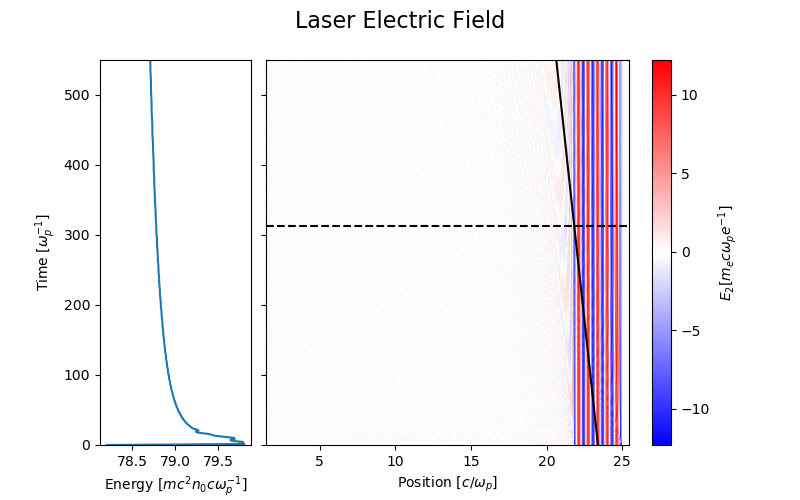

<IPython.core.display.Javascript object>


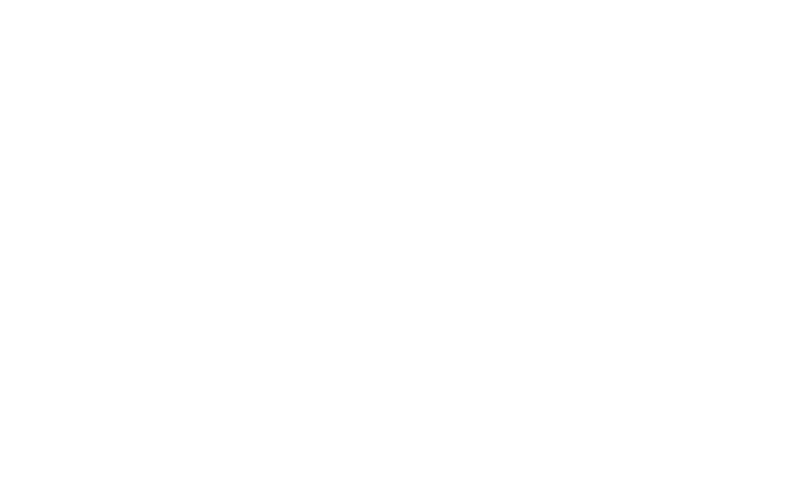

<IPython.core.display.Javascript object>


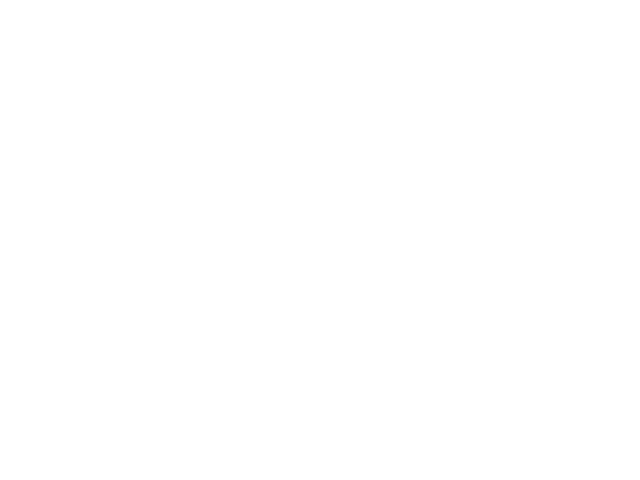

In [48]:
dirname = './nonlinear-a10-w10'
xt_and_energy_plot2(rundir=dirname, field = 'e2')
xt_and_energy_plot2(rundir=dirname, field = 'e1')
k_plot2(rundir = dirname)

In [50]:
## Hit <shift>+<return> to run

dirname = 'nonlinear-a10-w10-noplasma'
osiris.runosiris(rundir=dirname,inputfile='nonlinear-a10-w10-noplasma.txt')
plot_maxgamma_t(dirname)    

runosiris completed normally
max gamma =  1.1461239025515528


In [6]:
## Hit <shift>+<return> to run

dirname = 'nonlinear-a10-w10-long'
osiris.runosiris(rundir=dirname,inputfile='nonlinear-a10-w10-long.txt')
plot_maxgamma_t(dirname)  

runosiris completed normally
max gamma =  152.5319792153799


<IPython.core.display.Javascript object>


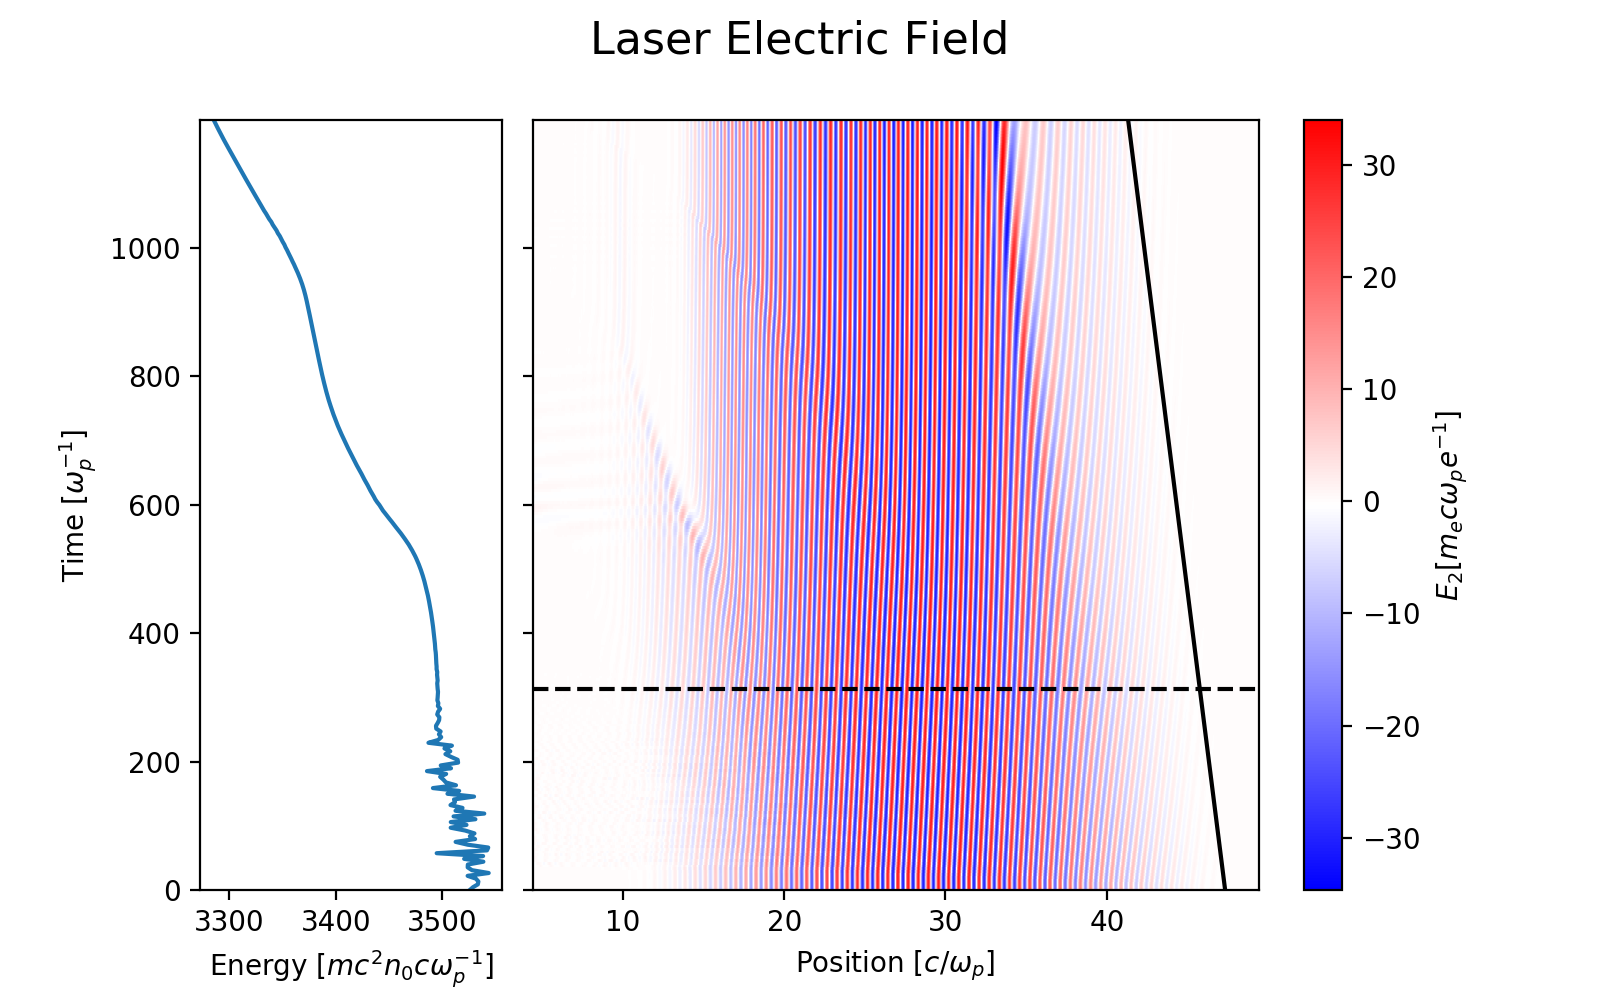

<IPython.core.display.Javascript object>


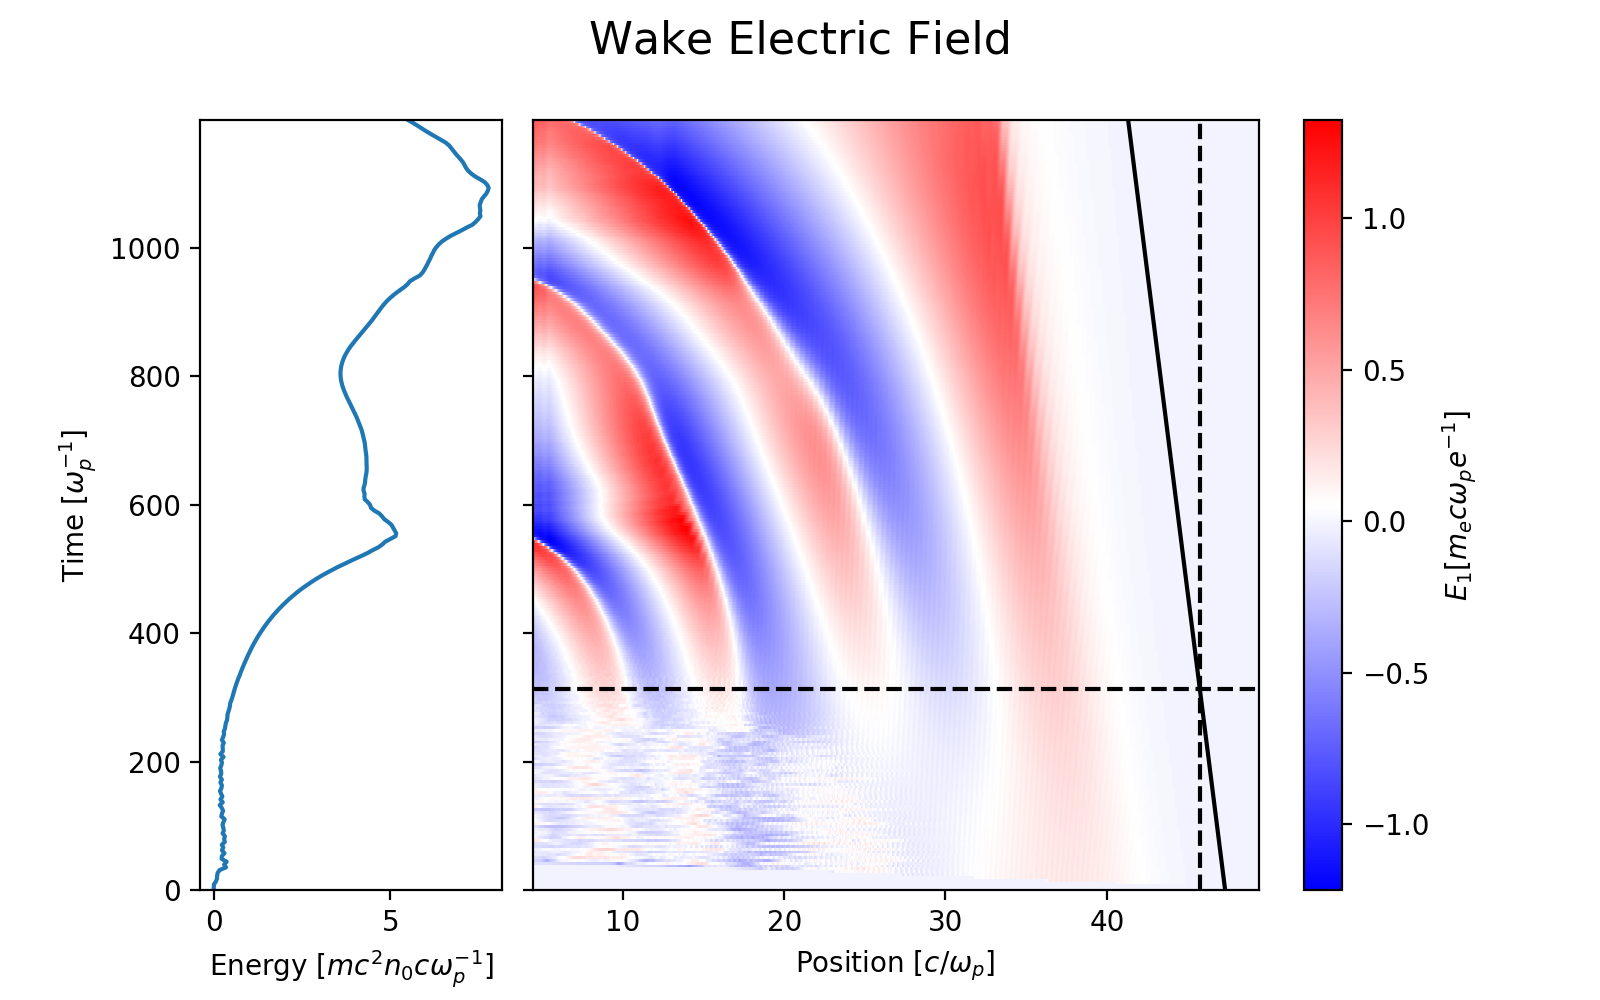

<IPython.core.display.Javascript object>


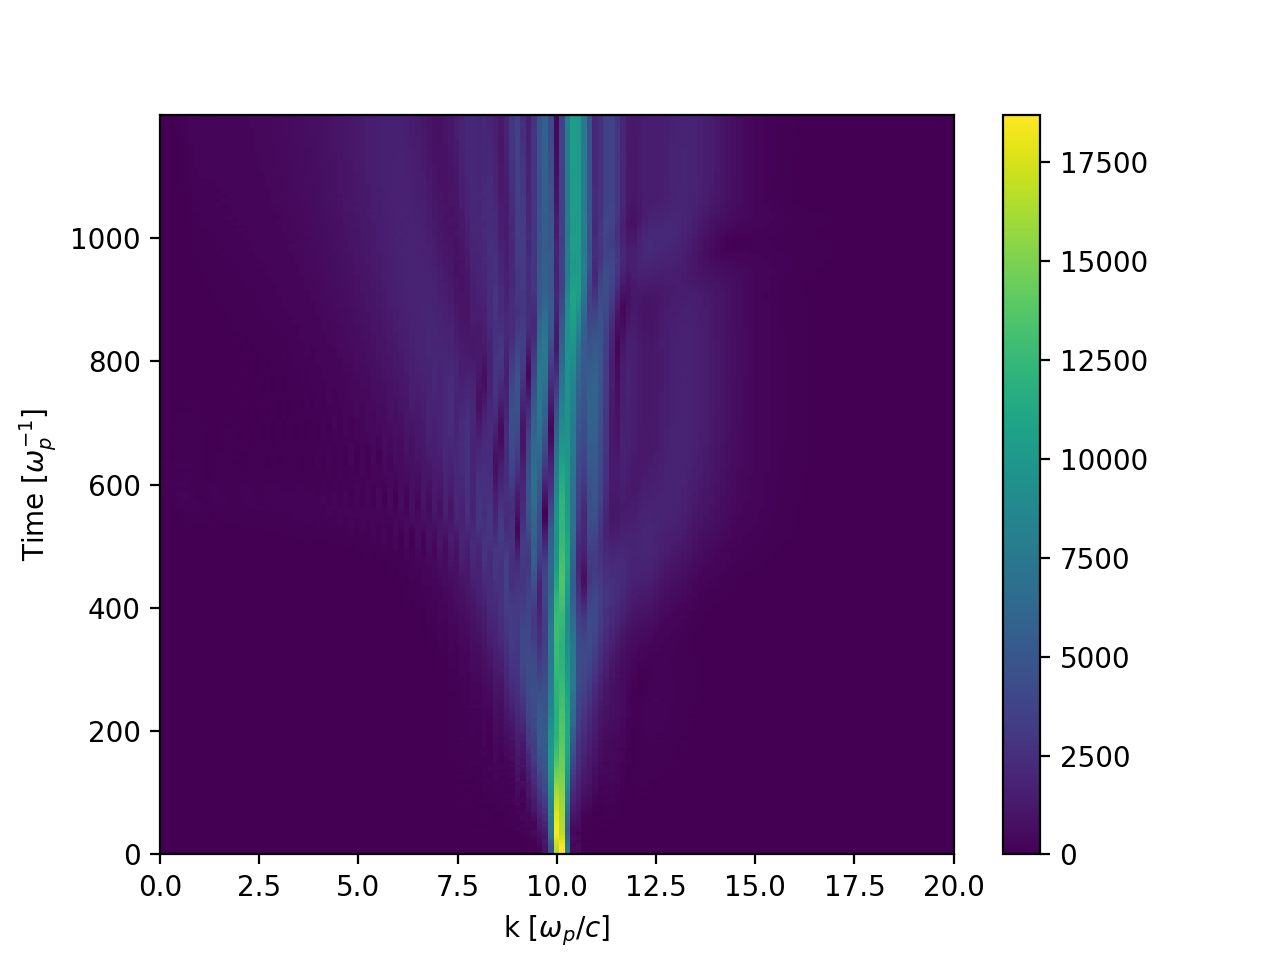

In [7]:
dirname = './nonlinear-a10-w10-long'
xt_and_energy_plot2(rundir=dirname, field = 'e2')
xt_and_energy_plot2(rundir=dirname, field = 'e1')
k_plot2(rundir = dirname)

## Customized case
The cell below allows you to explore different parameters

In [11]:
tajima_widget2()

d=FloatText(value=0.3, description='a0:', layout=Layout(width='55%'), style=DescriptionStyle(description_width='350px'))


interactive(children=(Text(value='linear-a03-w10.txt', description='Template Input File:', layout=Layout(width…

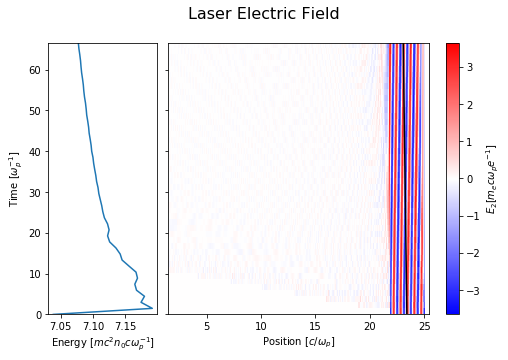

In [ ]:
dirname = './linear-a03-w7_2'
xt_and_energy_plot2(rundir=dirname, field = 'e2')
xt_and_energy_plot2(rundir=dirname, field = 'e1')
k_plot2(rundir = dirname)

<IPython.core.display.Javascript object>


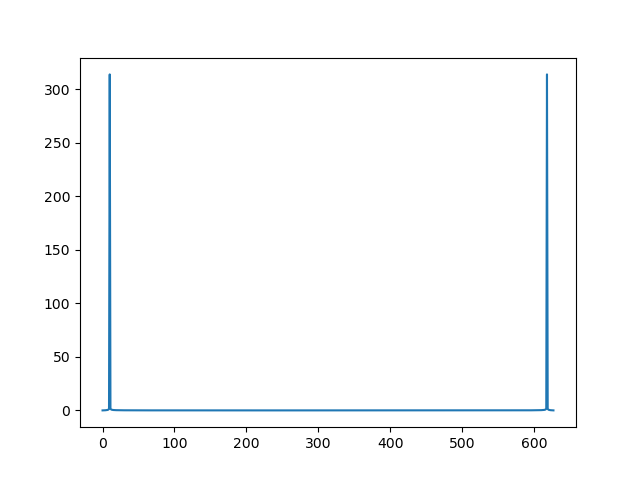

314.06577565375443
314.1581196347521
314.1581196347521


In [21]:
xaxis=np.arange(0,6.28,0.01)
signal=np.sin(xaxis*10)
xinv=np.abs(np.fft.fft(signal))
plt.figure()
plt.plot(xinv)
print(np.max(xinv))
print(np.sum(signal*signal))
print(np.sum(xinv*xinv)/628)

In [2]:
print(ml_deckmaker(lon_flat=5))

TypeError: float() argument must be a string or a number, not 'list'